# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [2]:
names = {'student_1': "Fredrik Bixo",
        'student_2': "Ann Onymous"}

sciper = {'student_1': 300685, 
          'student_2': 888888}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [3]:
conversations = getRawDataFromFile()
print(conversations[0])
print(conversations[1])

['hi , how are you doing ? i am getting ready to do some cheetah chasing to stay in shape .', 'you must be very fast . hunting is one of my favorite hobbies .', 'i am ! for my hobby i like to do canning or some whittling .', 'i also remodel homes when i am not out bow hunting .', 'that is neat . when i was in high school i placed 6th in 100m dash !', 'that is awesome . do you have a favorite season or time of year ?', 'i do not . but i do have a favorite meat since that is all i eat exclusively .', 'what is your favorite meat to eat ?', 'i would have to say its prime rib . do you have any favorite foods ?', 'i like chicken or macaroni and cheese .', 'do you have anything planned for today ? i think i am going to do some canning .', 'i am going to watch football . what are you canning ?', 'i think i will can some jam . do you also play footfall for fun ?', 'if i have time outside of hunting and remodeling homes . which is not much !']
['hi , how are you doing today ?', 'i am spending ti

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer**

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer**



In [72]:
frequencies = {} 

for conversation in conversations:
    for sentance in conversation:
        words = sentance.split(' ')
        for word in words:
            if word not in frequencies:
                frequencies[word] = 0
            frequencies[word] += 1

In [65]:
print(frequencies)

{'i': 9994, 'like': 1700, 'chicken': 27, 'or': 198, 'macaroni': 3, 'and': 1590, 'cheese': 28, '.': 9928, 'that': 2103, 'is': 2938, 'cool': 437, 'my': 2657, 'mom': 142, 'does': 157, 'the': 2098, 'same': 76, 'thing': 74, 'just': 542, 'drink': 51, 'some': 259, 'cola': 2, 'with': 723, 'rum': 1, 'you': 4142, 'will': 403, 'forget': 8, 'about': 459, 'them': 339, '!': 2138, 'better': 96, 'not': 1497, 'make': 202, 'any': 384, 'spelling': 2, 'mistakes': 1, 'doubt': 9, 'very': 316, 'much': 278, 'probably': 62, 'to': 3236, 'scream': 4, 'alone': 43, 'parents': 116, 'do': 3105, 'know': 246, 'am': 1831, 'homosexual': 1, 'no': 543, 'work': 590, 'at': 536, 'a': 3318, 'funeral': 5, 'home': 134, 'own': 116, 'it': 1527, 'think': 224, 'there': 284, 'confusion': 2, '?': 3596, 'maybe': 193, 'can': 450, 'borrow': 3, 'something': 80, 'as': 374, 'packing': 2, 'visit': 55, 'dad': 101, 'in': 1352, 'china': 8, 'trying': 57, 'get': 358, 'ba': 2, 'finance': 3, 'fun': 353, 'cant': 37, 'enough': 44, 'bank': 6, 'teller

In [66]:
sortedWords = sorted(frequencies, key=frequencies.__getitem__, reverse=True)
top75words = sortedWords[:75]
bottom75words = sortedWords[len(sortedWords)-75:]
print(top75words)

['i', '.', 'you', '?', ',', 'a', 'to', 'do', 'is', 'my', '!', 'that', 'the', 'have', 'am', 'like', 'and', 'it', 'not', 'in', 'what', 'of', 'are', 'for', 'love', 'but', 'me', 'so', 'with', 'too', 'be', 'your', 'work', 'no', 'just', 'at', 'good', 'yes', 'on', 'would', 'oh', 'about', 'favorite', 'can', 'cool', 'time', 'go', 'really', 'they', 'will', 'well', 'was', 'nice', 'any', 'as', 'how', 'all', 'get', 'fun', 'them', 'we', 'great', 'very', 'one', 'an', 'sounds', 'lot', 'from', 'out', 'music', 'live', 'there', 'its', 'much', 'when']


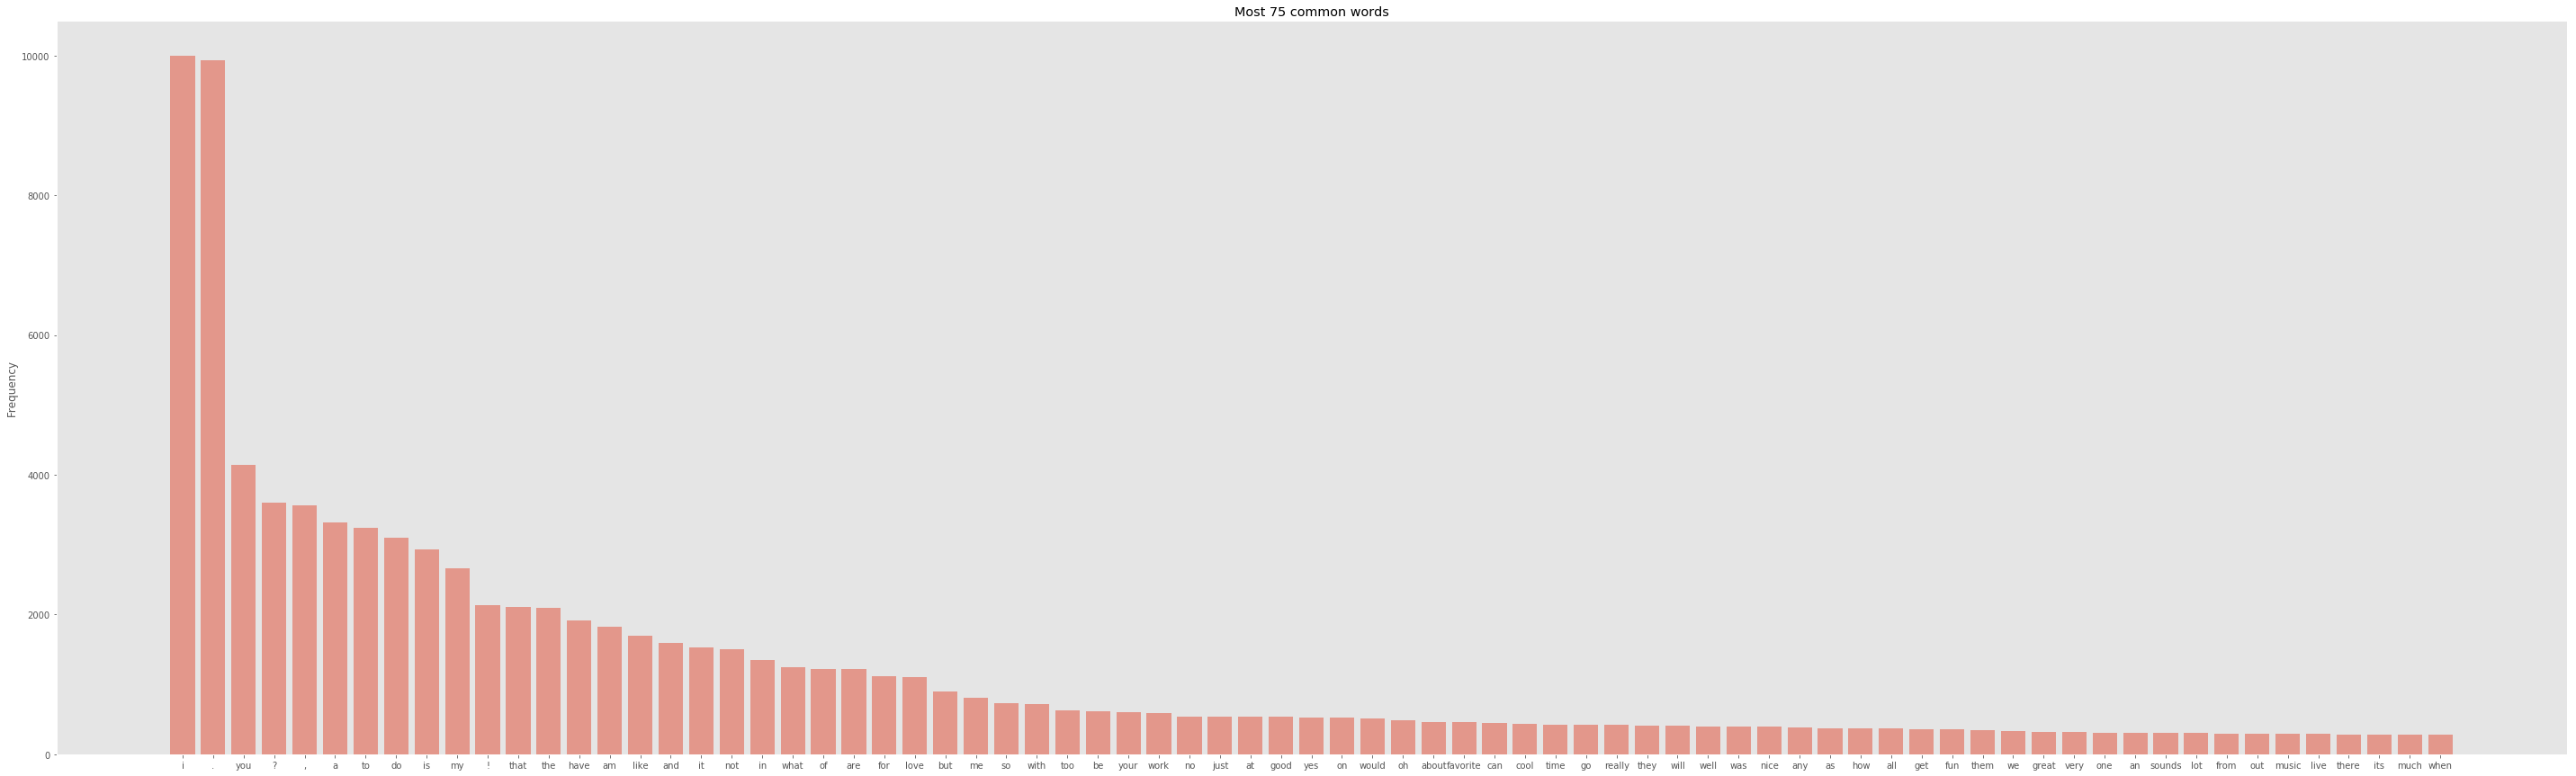

In [67]:
y_pos = np.arange(len(top75words))
performance = [frequencies[k] for k in top75words]

plt.figure(figsize=(50,15))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, top75words)
plt.ylabel('Frequency')
plt.title('Most 75 common words')

plt.show()

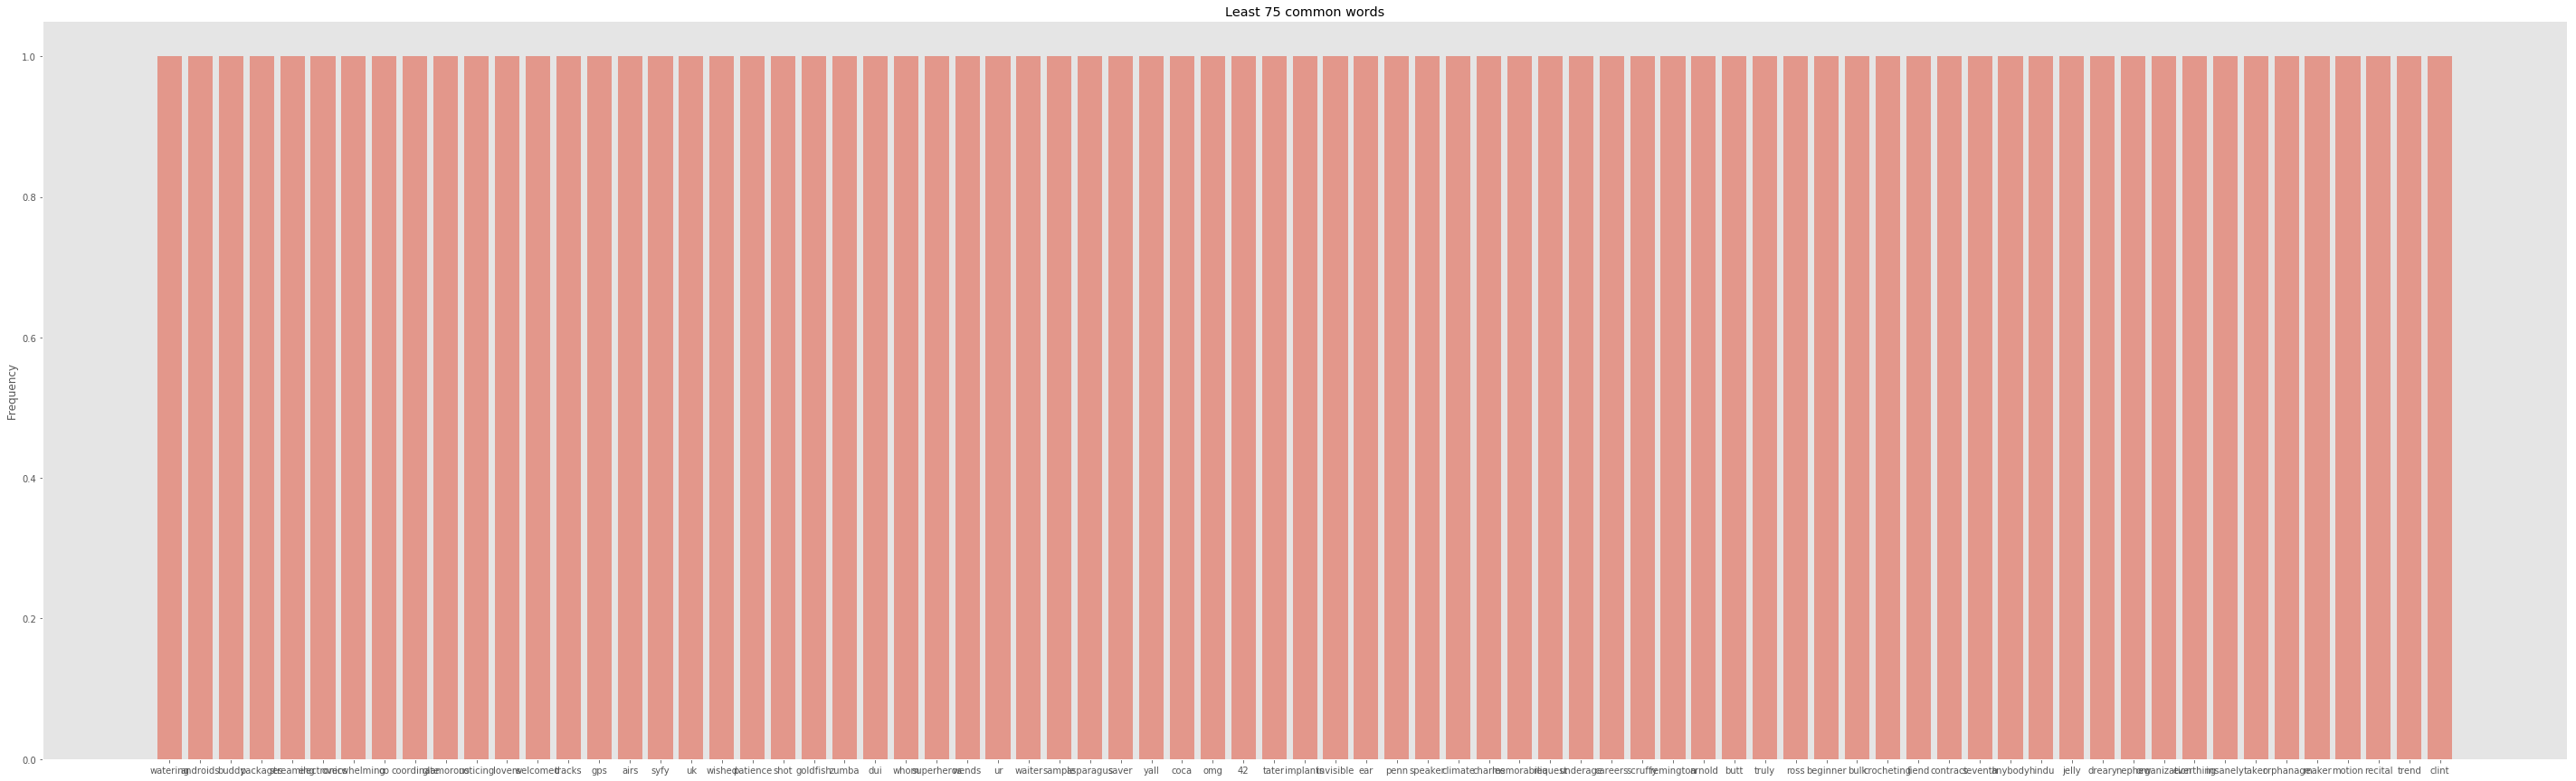

In [68]:
y_pos = np.arange(len(top75words))
performance = [frequencies[k] for k in bottom75words]

plt.figure(figsize=(50,15))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, bottom75words)
plt.ylabel('Frequency')
plt.title('Least 75 common words')

plt.show()

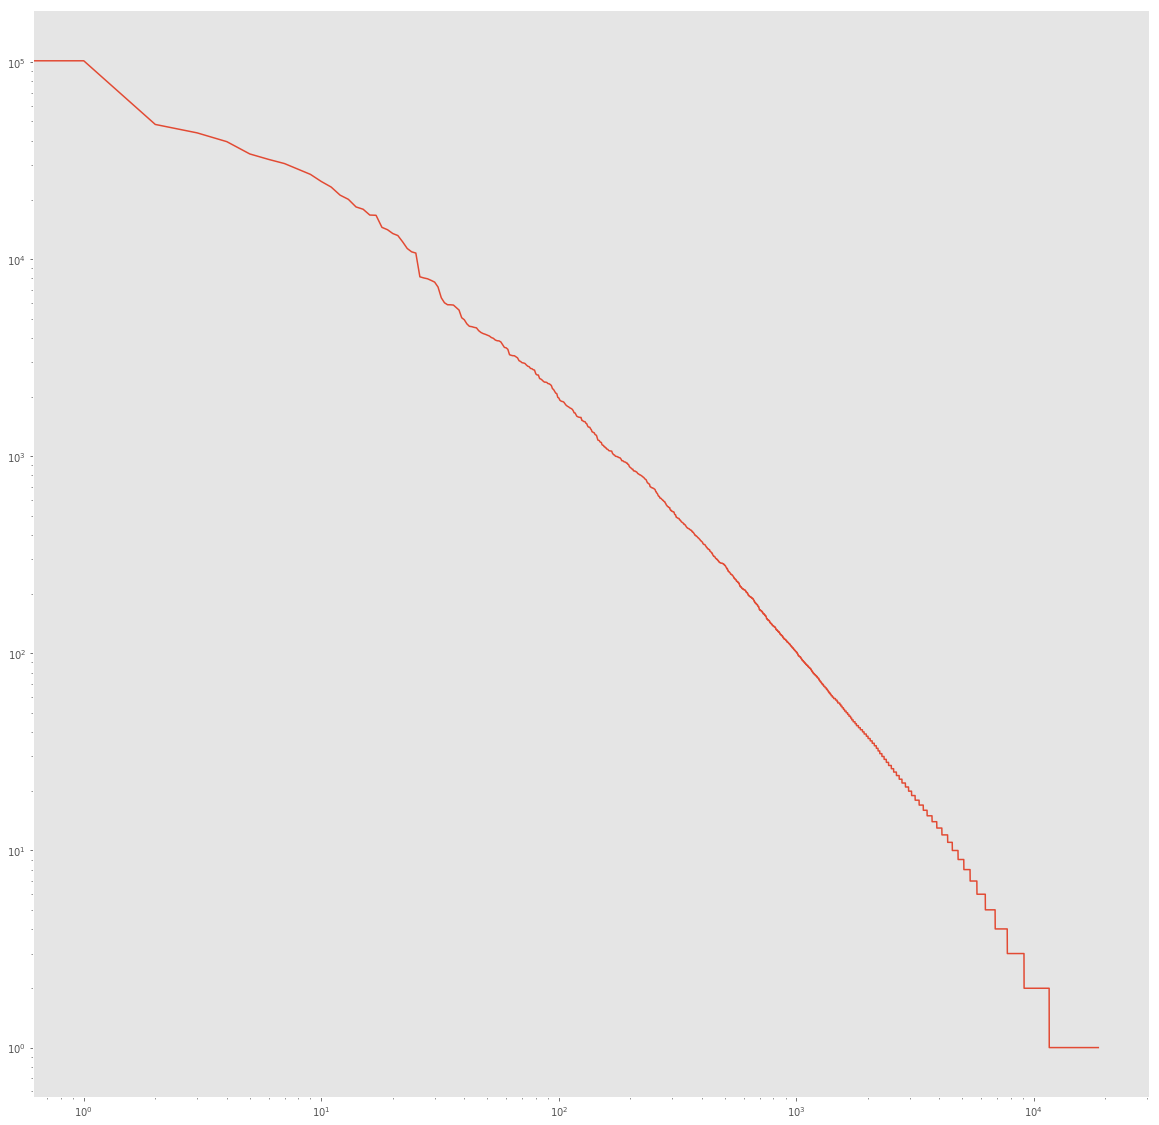

In [78]:
sortedWords = sorted(frequencies, key=frequencies.__getitem__, reverse=True)

x = []
y = []
i = 0
for word in sortedWords:
    y.append(frequencies[word])
    x.append(i)
    i += 1 
    
plt.figure(figsize=(20,20))
plt.loglog(x, y)

Since the graph is almost linear we can see that the word count follows a zipf distrubition. In other words, the most common word frequency is inversy proportional. So the most common word is multiplicative of the second most common word and so on.  

In [80]:
sortedWords = sorted(frequencies, key=frequencies.__getitem__, reverse=True)
performance = [frequencies[k] for k in sortedWords]

y = 0
for i in performance:
    if i == 1:
        y += 1
        
print(y)

7080


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: 

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**:

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: 

In [115]:
N = 70

original_sentances = 0
filtered_sentances = 0
new_conversations = getRawDataFromFile("personachat/",  "train_both_revised.txt")

frequencies = {} 

for conversation in new_conversations:
    for sentance in conversation:
        original_sentances += 1
        words = sentance.split(' ')
        for word in words:
            if word not in frequencies:
                frequencies[word] = 0
            frequencies[word] += 1

for conversation in new_conversations:
    for sentance in conversation:
        words = sentance.split(' ')
        for word in words:
            if frequencies[word] <= N:
                conversation.remove(sentance)
                break     
            
new_frequencies = {}
                
for conversation in new_conversations:
    for sentance in conversation:
        filtered_sentances += 1
        words = sentance.split(' ')
        for word in words:
            if word not in new_frequencies:
                new_frequencies[word] = 0
            new_frequencies[word] += 1
            

print('old number of words:', len(frequencies)) 
print('new number of words:',len(new_frequencies))                       
print('old number of sentances:',original_sentances)       
print('new number of sentances:',  filtered_sentances) 


old number of words: 18673
new number of words: 12312
old number of sentances: 131424
new number of sentances: 84392


TODO:

By removing rare sentances with rare words, you may get better generalization before data points that are extreme and unusual are not considered. 

### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your I’m dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [137]:
new_conversations = getRawDataFromFile("personachat/",  "train_both_revised.txt")

tokenized_conversations = []

dictionary = sorted(frequencies, key=frequencies.__getitem__, reverse=True)
dictionary.insert(0,'START')
dictionary.insert(0,'END')
dictionary.insert(0,'PADD')

for conversation in new_conversations:
    new_conversation = []
    for sentance in conversation:
        words = sentance.split(' ')
        new_sentance = []
        dictionary.index('START')
        for word in words:
            new_sentance.append(dictionary.index(word))
        dictionary.index('END')
        print(new_sentance)
        new_conversation.append(new_sentance)
    tokenized_conversations.append(new_conversation)


[48, 7, 27, 18, 5, 50, 6, 3, 13, 217, 370, 9, 10, 80, 5756, 2712, 9, 258, 23, 1010, 4]
[5, 202, 40, 74, 387, 4, 665, 11, 75, 25, 12, 53, 146, 4]
[3, 13, 14, 26, 12, 373, 3, 20, 9, 10, 3902, 105, 80, 3903, 4]
[3, 103, 4335, 1931, 82, 3, 13, 22, 72, 2088, 665, 4]
[16, 11, 655, 4, 82, 3, 49, 23, 271, 93, 3, 3727, 2570, 23, 11596, 3728, 14]
[16, 11, 111, 4, 10, 5, 17, 8, 53, 612, 105, 58, 25, 210, 6]
[3, 10, 22, 4, 29, 3, 10, 17, 8, 53, 297, 207, 16, 11, 61, 3, 102, 6869, 4]
[24, 11, 36, 53, 297, 9, 102, 6]
[3, 46, 17, 9, 257, 67, 5071, 9087, 4, 10, 5, 17, 64, 53, 640, 6]
[3, 20, 581, 105, 2969, 19, 548, 4]
[10, 5, 17, 175, 1932, 26, 65, 6, 3, 108, 3, 13, 87, 9, 10, 80, 3902, 4]
[3, 13, 87, 9, 140, 281, 4, 24, 18, 5, 3902, 6]
[3, 108, 3, 66, 52, 80, 1526, 4, 10, 5, 103, 88, 11597, 26, 68, 6]
[117, 3, 17, 58, 385, 25, 665, 19, 5072, 1931, 4, 310, 11, 22, 83, 14]
[48, 7, 27, 18, 5, 50, 65, 6]
[3, 13, 822, 58, 34, 12, 411, 584, 24, 18, 5, 77, 9]
[98, 7, 555, 584, 4, 32, 176, 265, 25, 855, 4]


[163, 4, 12, 1867, 178, 18, 348, 8, 30, 86, 4]
[4117, 24, 41, 15, 569, 1465, 6]
[117, 57, 17, 8, 30, 86, 3, 10, 38, 4]
[10, 5, 17, 64, 3077, 254, 5, 6]
[42, 32, 178, 4, 3, 183, 8, 79, 7, 1120, 254, 302, 37, 775, 296, 210, 4]
[10, 5, 99, 272, 984, 6]
[43, 45, 19, 8, 30, 1835, 1503, 11, 398, 4]
[74, 54, 7, 3, 13, 616, 38]
[43, 398, 4, 3, 102, 1835, 1210, 82, 22, 653, 11636, 4]
[10, 5, 99, 15, 1023, 6, 3, 124, 5770]
[82, 12, 178, 10, 22, 5771, 21, 61, 4, 86]
[69, 24, 18, 36, 576, 65]
[3, 13, 87, 9, 208, 9, 80, 282, 65, 27, 18, 5, 6]
[770, 59, 9, 15, 2722, 34, 12, 122, 14]
[98, 488, 4, 3, 10, 22, 20, 15, 2722, 39, 237, 3, 13, 762, 25, 15, 1065]
[67, 68, 572, 15, 86, 7, 3, 20, 21, 5772, 82, 3, 52, 594, 586, 14]
[3, 20, 9, 320, 586, 34, 12, 137, 4, 110, 11, 12, 145, 240, 19, 11, 11637, 68, 4]
[67, 54, 9, 17, 1162, 4814, 7, 3, 28, 15, 1162, 168, 23, 151]
[3, 28, 2221, 168, 20, 284, 201, 4, 3, 843, 78, 4]
[16, 11, 33, 51, 14, 3, 13, 107, 1162, 7, 3, 32, 20, 2175, 3749]
[85, 16, 11, 60, 51, 4, 

[31, 404, 7, 3, 32, 694, 271, 93, 19, 1904, 9, 4563, 9142, 4825, 395]
[938, 14, 3, 66, 32, 40, 292, 9, 2304, 379, 14, 47, 715, 14]
[144, 7, 3, 66, 32, 40, 500, 463, 680, 19, 272, 12, 616, 1210, 4]
[30, 523, 14, 5, 18, 87, 9, 17, 33, 83, 68, 14]
[225, 5, 14, 14, 3, 17, 8, 646, 36, 87, 9, 17, 401, 107, 68, 214, 3, 13, 4]
[67, 134, 68, 216, 34, 3444, 14]
[117, 3, 49, 793, 3, 46, 17, 9, 435, 4]
[27, 18, 5, 6, 3, 13, 272, 204, 7, 12, 53, 4]
[69, 27, 18, 5, 50, 6]
[3, 20, 637, 19, 279, 115, 4]
[3, 582, 63, 8, 3311, 39, 12, 457, 7779]
[70, 10, 22, 17, 177, 2305, 426, 31, 4, 3, 635, 77, 426, 15, 668, 4]
[3, 17, 73, 6279, 510, 37, 890, 4]
[3, 17, 8, 2895, 510, 23, 2059, 4]
[3, 13, 925, 169, 142, 19, 81, 34, 12, 174, 4]
[1988, 14, 3, 485, 344, 82, 3, 49, 851, 4, 3, 17, 92, 544, 164, 207, 7, 3, 28, 21, 4]
[3, 17, 1253, 1090, 910, 4]
[57, 477, 787, 889, 26, 130, 187, 18, 162, 1369, 4]
[3, 13, 23, 15, 2726, 25, 259, 9, 424, 8, 4131, 4]
[98, 14, 16, 11, 47, 14, 3, 28, 721, 355, 14]
[24, 18, 36, 146,

[3, 20, 9, 17, 3586, 2530, 23, 15, 494]
[16, 71, 1290]
[67, 68, 4, 232, 36, 53, 320, 6]
[3, 20, 4833, 1160, 149, 25, 15, 1994]
[3, 60, 20, 1103, 3449]
[16, 11, 75, 25, 15, 145, 6291, 24, 11, 75, 115, 5, 223, 15, 252]
[3, 10, 22, 89, 4, 4, 4, 125, 204, 6]
[3, 20, 204, 63, 148, 63, 67, 8, 297, 3169, 3, 223, 725, 4]
[24, 162, 11, 36, 200, 6]
[2302, 24, 162, 11, 36]
[372, 526, 34, 418, 3587]
[123, 7, 27, 475, 21, 87, 221, 6]
[48, 27, 18, 5, 65]
[3, 577, 30, 7, 32, 176, 1949, 6915, 117, 15, 1034, 1516, 697]
[98, 18, 5, 8, 697, 273]
[3, 20, 697, 7, 29, 3, 1215, 724, 17, 8, 1209, 4, 3, 147]
[24, 255, 10, 5, 10]
[3, 28, 87, 9, 1002, 82, 3, 52]
[16, 132, 313, 20, 68, 60]
[12, 53, 75, 49, 289, 15, 434, 21, 105, 22, 1199]
[84, 16, 132, 313, 47]
[24, 10, 5, 20, 9, 10, 6]
[3, 60, 28, 284, 201]
[24, 475, 36, 53, 265, 9, 88, 6]
[3, 46, 257, 1742, 402]
[16, 475, 51, 7, 3, 20, 4577]
[84, 16, 49, 396, 191, 15, 263, 417]
[69, 7, 27, 18, 5, 6, 12, 154, 11, 2813, 4]
[123, 14, 3, 13, 47, 4, 12, 154, 11, 319

[56, 11, 109, 6307, 548, 3, 134, 62, 39, 746, 640]
[147, 70, 133, 746, 640, 4, 365, 666, 114, 4, 5, 23, 15, 266, 6]
[45, 3, 17, 8, 1091, 3073, 4, 3, 13, 134, 160]
[24, 113, 25, 1091, 6, 3, 722, 32, 140, 281, 34, 158, 4, 144, 4]
[10, 5, 20, 203, 6, 24, 11, 36, 53, 162, 6]
[22, 203, 33, 83, 4, 28, 772, 4, 5, 6]
[3, 28, 15, 162, 364, 4, 3, 13, 87, 9, 59, 469, 229, 109, 4]
[48, 27, 18, 5, 50]
[30, 194, 32, 292, 9, 80, 747, 76, 14, 5, 6]
[3, 49, 160, 37, 15, 185]
[18, 5, 8, 1245, 6, 3, 89, 352, 41, 314, 4]
[3, 147, 21, 11, 32, 8, 373]
[74, 51, 4, 3, 10, 1843, 843, 26, 35, 127, 85, 4]
[10, 5, 20, 21, 105, 32, 17, 9]
[3, 28, 21, 4, 3, 94, 9, 35, 26, 4158, 643, 4]
[24, 10, 5, 108, 5, 66, 10]
[654, 35, 37, 4158, 203, 20, 11782, 19, 129, 4]
[16, 46, 40, 60, 47]
[24, 10, 5, 10, 811, 35, 37, 314, 6]
[3, 35, 8, 79, 4, 3, 157, 9, 469, 4]
[47, 14, 10, 5, 59, 9, 15, 559, 6]
[3, 10, 8, 79, 25, 498]
[111, 4, 3, 118, 862, 107, 29, 17, 92, 243, 758, 19, 160, 4]
[48, 27, 18, 5, 221]
[3, 13, 99, 7, 27, 41, 

[3, 20, 11825, 15, 252, 25, 61]
[48, 7, 3, 32, 96, 129, 55, 35, 4]
[84, 4, 3, 843, 2917, 26, 8, 139, 24, 10, 5, 10, 6]
[3, 13, 8, 1446, 283, 39, 8, 895, 93]
[16, 202, 378, 5, 17, 9, 62, 77, 605, 4, 3, 20, 1196, 77, 61, 237, 4]
[16, 11, 54, 4, 3, 20, 9, 59, 1802, 82, 3, 52]
[3, 13, 8, 374, 25, 8, 3621, 4, 3, 81, 191, 212, 4, 42, 7845, 4]
[3, 17, 1772, 7845, 310, 18, 12, 1022]
[16, 11, 8, 79, 23, 75, 4169, 4]
[45, 7, 3, 96, 230, 9, 21, 4, 3, 17, 679, 207, 3622]
[3, 17, 92, 272, 362, 19, 3429, 581, 207, 159, 4, 28, 21, 14]
[3, 28, 362, 19, 3429, 581, 63, 44, 4, 3, 103, 20, 204]
[1138, 11, 121, 83, 61, 3, 102, 4]
[16, 11, 51, 4, 3, 102, 61, 1018, 25, 640]
[5, 18, 8, 2615, 7, 674, 6, 3, 242, 3, 62, 113, 25, 1165, 23, 8, 9229, 4]
[48, 56, 7, 27, 18, 5, 50, 6]
[3, 13, 30, 4, 27, 18, 5, 6]
[22, 38, 186, 4, 3, 13, 33, 370, 9, 358, 12, 126, 499, 109, 337, 4]
[16, 71, 20, 68, 4, 3, 20, 9, 246, 63, 373, 4, 91, 10, 5, 20, 9, 358, 6]
[942, 426, 519, 149, 3, 28, 11826, 212, 254, 175, 247, 14]
[3, 13,

[117, 5, 81, 23, 1910, 7, 3, 52, 327, 41, 5]
[3, 13, 450, 25, 650, 4, 3, 118, 425, 56]
[149, 12, 174, 81, 56, 7, 3, 52, 349, 19, 327, 41, 5]
[43, 7, 16, 46, 40, 692, 4, 3, 106, 182, 5, 61, 41, 15, 3986, 3318, 3, 396]
[24, 41, 76, 6, 10, 5, 20, 661, 6, 16, 11, 12, 53, 4]
[661, 11, 121, 30, 14, 3, 20, 5399, 661, 20, 2650]
[24, 11, 5399, 661, 6, 3, 13, 142, 93]
[67, 166, 9, 3608, 29, 5, 118, 402, 710, 2650, 72]
[16, 11, 51, 7, 3, 66, 33, 24, 118, 3, 327, 41, 5, 6]
[1057, 4, 4, 125, 41, 12, 9262, 7881, 4, 3, 13, 134, 33, 5144, 25, 212]
[3, 108, 3, 17, 8, 1575, 2691, 37, 12, 2618, 7, 118, 3, 182, 245, 6]
[45, 4, 3, 278, 9, 2691, 37, 15, 1088, 82, 3, 49, 8, 479, 4]
[24, 118, 3, 257, 6, 66, 21, 40, 522, 6]
[182, 78, 80, 25, 15, 115, 5, 20, 9, 190, 4, 3, 104, 1986, 4]
[10, 5, 17, 9, 62, 77, 605, 23, 15, 299, 9, 104, 1986, 6]
[45, 29, 3, 13, 230, 9, 217, 77, 605, 9, 410, 15, 534, 4]
[43, 199, 4, 3, 10, 22, 20, 2277, 7, 3, 290, 9, 419, 23, 4]
[18, 5, 1657, 34, 4576, 353, 6]
[42, 3, 13, 22, 7, 21

[924, 12, 100, 39, 1190, 4, 11936, 5158, 19, 62, 518, 1538, 1292, 14, 5, 6]
[16, 11, 24, 3, 13, 259, 9, 1303, 72, 4, 119, 17, 756, 641, 9, 660, 4]
[16, 11, 1582, 14, 3, 13, 138, 14, 232, 686, 6]
[8, 1837, 5455, 4863, 3, 13, 785, 4]
[8, 379, 23, 12, 1943, 4408, 445, 137, 11, 8, 7903, 4, 125, 405, 9, 75, 14]
[3, 13, 199, 34, 21, 4, 3, 108, 12, 545, 25, 1090, 1258, 7018, 66, 974, 277, 85, 4]
[3, 13, 8, 11937, 14, 3, 28, 319, 2420, 3793, 14, 3, 223, 3089, 14]
[67, 12, 104, 8, 147, 545, 4]
[9, 315, 1539, 4, 5, 202, 40, 393, 6]
[3, 13, 5794, 33, 393, 371, 4]
[29, 142, 371, 26, 8, 1292, 14, 5, 118, 62, 75, 14]
[3, 17, 75, 723, 4, 67, 8, 1538]
[263, 14, 15, 9284, 838, 322, 12, 115, 19, 15, 3794, 37, 12, 1283]
[42, 1312, 23, 31, 217, 8, 1292, 34, 24, 12, 600, 868, 31, 4]
[21, 66, 40, 36, 296, 3349, 9, 15, 302, 4]
[123, 1618, 10, 5, 20, 369, 6]
[48, 56, 14, 3, 13, 228, 22, 16, 83, 25, 73, 3350, 273, 144]
[3, 13, 7, 3, 28, 15, 2722, 19, 2175, 3749, 4, 33, 24, 10, 5, 20]
[501, 313, 6367, 7, 29, 3,

[24, 10, 5, 2006, 90, 23, 12, 821, 445, 11, 38, 166, 109, 4415]
[239, 731, 19, 195, 39, 15, 1332, 2696, 4]
[44, 3, 242, 5, 66, 22, 40, 647, 9, 181, 34, 153, 2461]
[22, 33, 83, 4, 138, 4, 3, 220, 5, 106, 3095, 8, 2006, 4]
[69, 56, 4, 27, 18, 5, 6]
[60, 5876, 4, 32, 2173, 15, 145, 586, 55, 1863, 14, 187, 1038, 6]
[16, 11, 111, 14, 586, 11, 47, 34, 720, 7, 12, 53, 115, 14]
[22, 12, 211, 7, 29, 9, 621, 319, 167, 4, 3, 13, 107, 25, 8, 805, 113, 25, 533, 4]
[43, 3, 136, 4, 12, 227, 90, 103, 1836, 720, 4]
[229, 8, 148, 86, 23, 15, 2422, 7, 8, 2661, 630, 2886, 15, 1773, 4]
[16, 11, 33, 277, 14, 16, 49, 12, 11979, 1342, 82, 3, 694, 937, 93]
[3, 13, 11980, 9, 61, 15, 2896, 187, 9311, 31, 77, 23, 15, 4203, 887, 4]
[21, 11, 8, 1071, 943, 4, 32, 850, 130, 11, 8, 2093, 25, 23, 3998]
[3, 20, 8, 54, 265, 25, 4204, 23, 15, 6307, 229, 8, 148, 86, 25, 35, 4]
[216, 708, 11, 155, 229, 8, 148, 86, 4]
[16, 11, 103, 40, 250, 649, 4, 105, 8, 237, 25, 4155, 4]
[16, 11, 277, 4, 17, 5, 32, 92, 9, 1863, 6]
[42, 7,

[3, 20, 619, 72, 34, 12, 128, 4, 97, 11, 8, 5887, 6392, 4, 32, 3221, 245, 8, 2551, 4908, 4, 5, 6]
[12, 128, 32, 66, 22, 7038]
[44, 4, 80, 130, 316, 3325, 29, 2316, 319, 9336, 14, 286, 245, 187, 11, 7744, 4]
[97, 11, 107, 5489, 214, 378, 7, 29, 173]
[123, 27, 18, 5, 6, 12, 154, 11, 4004]
[3, 13, 50, 30, 4, 3, 32, 312, 355]
[54, 3, 81, 23, 126, 517, 266, 7, 33, 3, 89, 61, 41, 355]
[3, 312, 355, 423, 19, 96, 8, 1934]
[12, 53, 18, 3240, 19, 4423, 207, 3, 35, 37, 1653, 1037]
[3, 9337, 82, 3, 136, 8, 295, 23, 8, 2475]
[1406, 95, 3119, 3, 9337, 82, 3, 208, 9, 2664, 587, 67, 12, 53]
[24, 162, 18, 36, 638, 6, 155, 18, 364]
[12, 45, 18, 580, 7, 32, 20, 12, 5490, 4, 192, 154, 11, 3810]
[3, 28, 196, 4, 57, 18, 15, 145]
[5, 89, 91, 3, 81, 91, 10, 5, 81]
[3, 81, 23, 1324, 4, 21, 11, 1964, 14, 14]
[3, 17, 120, 92, 9, 1324, 7, 29, 3, 46, 28, 9, 59]
[15, 115, 11, 326, 14, 3, 28, 15, 3295, 1457]
[3, 28, 7821, 103, 7, 280, 37, 1830]
[56, 11, 109, 3295, 19, 5390, 473, 520]
[123, 56, 27, 18, 5, 50, 65]
[48

[127, 37, 4, 418, 11, 12, 198, 53, 162, 4]
[24, 10, 5, 10, 26, 8, 139, 6, 3, 13, 8, 3437, 4]
[3, 13, 8, 1314, 4, 3, 88, 23, 8, 661, 226, 19, 5500, 661, 484, 4]
[16, 313, 243, 7, 29, 103, 68, 4, 3, 13, 2434, 5, 183, 401, 4]
[3, 10, 4, 39, 465, 254, 12, 585, 26, 85, 4, 330, 25, 68, 4]
[48, 7, 546, 151, 3062, 5, 6]
[30, 33, 390, 4, 4, 27, 41, 5]
[3, 13, 32, 1845, 7, 618, 15, 1121, 4]
[436, 15, 337, 34, 51, 203, 19, 586, 6, 6]
[67, 8, 498, 799, 2106, 26, 31]
[2271, 4, 4, 157, 3246, 186, 4, 4, 67, 107, 165]
[3, 28, 16, 286, 4, 3, 17, 8, 878, 5184, 696, 77, 4]
[165, 4, 4, 91, 18, 5, 55, 6]
[1387, 19, 91, 18, 5, 55, 6]
[3, 13, 55, 1185, 7, 2202]
[51, 3, 28, 15, 7055, 95]
[4216, 4, 4, 101, 5, 164, 1601, 1185, 6, 6]
[120, 92, 29, 3, 17, 158, 55, 56, 4]
[5, 17, 75, 107, 55, 65]
[48, 67, 1678, 14, 18, 5, 858, 23, 9373, 15, 2025, 2726, 6]
[48, 14, 310, 5903, 25, 21, 6]
[2517, 36, 127, 9, 2936, 4, 3, 13, 74, 1411, 41, 21]
[124, 14, 16, 11, 551, 4, 3, 182, 16, 9, 12, 224, 269, 38, 4]
[54, 14, 65, 11

[5, 10, 14, 3, 28, 1518, 7, 222, 76, 7, 19, 216, 8, 490, 4226, 399]
[3, 28, 9, 848, 34, 12, 449, 7, 70, 157, 9, 59, 3225, 377, 8, 210, 4]
[3, 81, 395, 7, 33, 3, 148, 26, 12101, 20, 16, 4]
[3, 81, 395, 103, 7, 3, 13, 481, 8, 276, 23, 4227, 4672, 91, 3, 81, 4]
[24, 10, 5, 848, 26, 23, 4227, 4672, 6]
[34, 12, 449, 6, 239, 12102, 19, 381, 565, 95, 4]
[16, 11, 60, 339, 4, 5, 677, 20, 8, 339, 273, 4, 1089, 105, 958, 6]
[194, 7, 3, 13, 121, 339, 4, 3, 13, 958, 4]
[16, 11, 60, 339, 4, 5, 677, 20, 8, 339, 273, 4, 1089, 105, 958, 6]
[3, 20, 9, 251, 8, 30, 6411, 37, 151, 4]
[94, 9, 172, 8, 1547, 6]
[124, 7, 707, 172, 24, 5, 96, 4]
[141, 10, 2835, 9407, 558, 4156, 72, 25, 15, 775, 6]
[3, 10, 22, 89, 7, 141, 10, 57, 6]
[149, 117, 57, 1617, 12103, 7, 57, 46, 173, 40, 23, 15, 775, 4]
[16, 11, 8, 30, 75, 4, 21, 49, 54, 729, 34, 5, 4]
[48, 27, 18, 5, 50]
[43, 32, 436, 19, 590, 12, 58, 215, 55, 35, 23, 596, 4]
[16, 11, 54, 3, 81, 23, 1200]
[1696, 11, 12, 154, 191, 15, 197, 4, 10, 5, 20, 9, 3603, 6]
[22,

[3, 20, 544, 23, 15, 934, 903]
[3, 20, 381, 2278, 228, 4, 67, 217, 504, 114, 33, 12142, 12143, 14]
[69, 7, 27, 18, 5, 109, 690, 6]
[69, 7, 27, 18, 5, 6]
[3, 13, 50, 32, 250, 7, 32, 1189, 12, 240, 23, 8, 284, 265]
[54, 4, 938, 4, 101, 5, 795, 21, 6]
[42, 7, 3, 101, 22, 149, 3, 10, 22, 20, 9, 4198, 95]
[12, 403, 7075, 336, 97, 132, 4]
[95, 7, 12, 532, 19, 3, 28, 216, 284, 201]
[84, 4, 12, 244, 599, 259, 9, 62, 31, 9, 88, 4, 3, 849, 474, 9437, 4]
[3, 220, 1265, 2362, 1360, 26, 348, 8, 244]
[3, 242, 33, 4, 3, 1215, 724, 998, 41, 24, 11, 2362, 1360, 4]
[3, 147, 3, 49, 1360, 7, 130, 108, 3, 13, 3785]
[44, 4, 130, 18, 360, 3785, 7, 33, 1215, 724, 998, 41, 21, 4]
[3, 13, 1425, 130, 1487, 31, 20, 3, 17, 8, 4448, 207, 3, 13, 3800]
[56, 475, 352, 686, 34, 5, 4, 21, 475, 78, 16, 17, 15, 2808, 4]
[171, 3, 147, 3, 49, 22, 139, 7, 12, 167, 174, 10, 22, 249, 20, 31]
[168, 66, 62, 206, 26, 5, 4]
[18, 5, 288, 26, 64, 113, 25, 843, 1266, 191, 64, 881, 6]
[3, 13, 22, 389, 7, 10, 5, 35, 23, 843, 6]
[3, 28,

[3, 13, 2434, 3, 17, 285, 8, 944, 100, 25, 9464, 8, 295]
[16, 11, 8, 30, 211, 7]
[16, 11, 22, 8, 30, 211, 7, 5, 270, 2476, 9, 108, 3, 49, 8, 295, 95]
[455, 5, 101, 22, 4, 5, 268, 37, 1122, 7, 3, 20, 21]
[1748, 77, 7, 18, 5, 8, 588, 6, 95]
[42, 3, 13, 22, 8, 588]
[2108, 17, 12187, 7, 3, 13, 5214, 7, 3, 13, 3245, 72]
[141, 18, 36, 3245, 72, 6]
[48, 56, 7, 27, 18, 5, 50, 6]
[48, 3, 13, 250, 7, 32, 1623, 12, 2118, 318, 445]
[16, 71, 54, 4, 3, 13, 195, 8, 276, 34, 3977, 9465, 216, 23, 15, 2735, 4]
[187, 11, 3977, 9465, 7, 3, 13, 1119, 7, 19, 12, 145, 240, 11, 3030]
[97, 11, 8, 1314, 4, 891, 1786, 7, 1276, 76, 4, 18, 5, 55, 15, 1156, 913, 6]
[42, 1481, 913, 7, 126, 2257, 3999]
[3, 13, 55, 1735, 585, 4, 21, 4108, 8, 79, 107, 114, 214, 5521, 4]
[45, 7, 3, 574, 7, 29, 21, 202, 40, 54, 139, 91, 18, 33, 83, 364]
[45, 4, 21, 11, 343, 114, 82, 3, 3216, 12, 7084]
[16, 11, 51, 7, 75, 86, 82, 3, 13, 493, 7, 20, 9, 59, 9, 1645]
[24, 10, 5, 19, 36, 240, 3030, 20, 9, 10, 406, 6]
[70, 18, 87, 5522, 37, 8,

[959, 84, 16, 11, 111, 4]
[10, 5, 17, 64, 1715, 6]
[3, 17, 227, 365, 912, 4, 3, 94, 107, 29, 3, 120, 104, 58, 26, 21]
[3, 334, 4, 10, 5, 20, 198, 1115, 8019, 6]
[3, 17, 133, 8, 321, 2775, 235, 15, 169, 7, 19, 12, 3265, 18, 9486, 9, 8, 5501]
[362, 14, 12, 180, 211, 184, 92, 200, 4, 3, 1648, 21, 256, 19, 96, 8, 12228, 12229, 4]
[3, 458, 348, 68, 200, 4, 3, 133, 256, 7, 364, 7, 418, 4, 4, 4, 67, 478, 85]
[232, 4549, 5, 55, 1962, 21, 85, 6]
[35, 4, 3, 613, 7092, 39, 129, 19, 23, 1714, 3255, 7093, 5218, 780, 480]
[24, 10, 5, 10, 26, 8, 139, 6]
[3, 35, 26, 8, 5199, 12230, 4, 24, 41, 5, 6]
[48, 21, 11, 54, 9, 315, 5]
[69, 19, 30, 299, 9, 5]
[182, 31, 80, 168, 41, 218]
[3, 28, 9, 757, 19, 28, 15, 668]
[3, 35, 415, 58, 7, 125, 3, 52, 268, 140, 5, 757, 717]
[3, 46, 28, 16, 3, 13, 259, 9, 917, 8, 4688]
[3, 10, 22, 303, 38, 83, 26, 1805, 7, 29, 3, 28, 4946]
[3, 485, 9, 5530, 266, 267, 467]
[3, 46, 28, 9, 425, 29, 3, 13, 119, 1250, 415, 58, 127, 85]
[24, 10, 5, 10, 26, 35]
[3, 726, 970, 7, 310, 11,

[1413, 154, 4, 192, 154, 11, 6456]
[904, 7, 3, 46, 459, 8, 1945, 25, 78, 4]
[16, 46, 40, 33, 1413]
[48, 27, 18, 5, 65]
[4694, 44, 4, 21, 11, 1759, 85, 7, 29, 3, 20, 16]
[42, 22, 85, 150, 21, 132, 12, 345, 982, 847, 186, 127, 85]
[43, 7, 18, 5, 8, 1990, 6]
[84, 3, 17, 12, 472, 496, 9504, 29, 46, 474, 345]
[44, 3, 290, 871, 29, 16, 11, 51]
[10, 5, 17, 8, 510, 23, 463, 680]
[45, 7, 19, 3, 13, 160, 37, 8, 126, 1566]
[16, 11, 47, 4, 101, 5, 17, 839, 65]
[3, 133, 9505, 761, 4, 5, 6]
[3, 133, 1224, 761, 4, 57, 18, 33, 30, 4]
[19, 874, 6, 5, 96, 9, 17, 874]
[84, 874, 11, 30, 38, 4, 10, 5, 17, 8, 53, 448, 6, 155, 11, 15, 581]
[3, 242, 3, 20, 61, 196, 4, 239, 3319, 152]
[61, 12, 196, 18, 534, 4, 29, 3, 101, 17, 8, 128, 877, 77]
[3, 10, 22, 303, 26, 161, 385]
[123, 27, 18, 5, 109, 47, 86, 6]
[22, 38, 186, 7, 32, 96, 23, 55, 35]
[43, 91, 10, 5, 35, 6]
[3, 35, 26, 8, 1991, 426, 31, 63, 8, 190, 4, 4, 4, 4, 3, 980, 20, 5952, 1068, 14]
[16, 11, 1850, 7, 3, 17, 73, 486, 100, 4, 33, 3, 20, 9, 246, 82, 3

[123, 4, 4, 4, 27, 18, 5, 50, 221, 6]
[50, 30, 7, 32, 96, 23, 55, 505, 639, 4, 3, 88, 5, 136]
[505, 11, 47, 24, 1919]
[61, 25, 78, 7, 3, 13, 16, 30, 4, 3, 103, 88, 549]
[54, 4, 4, 4, 4, 4, 22, 566, 11, 16, 30, 5, 118, 40, 1174]
[3, 434, 67, 149, 364, 11, 12, 547, 162, 4, 16, 11, 24, 70, 446]
[44, 364, 11, 74, 547, 33, 3, 106, 136, 16]
[24, 10, 5, 10, 6, 3, 99, 195, 41, 1138, 821, 23, 12, 466, 58]
[3, 103, 99, 195, 231, 19, 481, 1136]
[5, 118, 286, 31, 80, 25, 36, 1136]
[10, 5, 327, 1136, 105, 32, 20, 195, 21, 6]
[3, 32, 20, 195, 21, 4, 22, 63, 83, 63, 1138, 821, 112]
[44, 3, 106, 795, 29, 12, 1136, 11, 74, 1308, 33, 3, 62, 1230]
[3, 13, 8, 374, 20, 16, 34, 12, 549, 216]
[149, 21, 11, 238, 5, 18, 1411, 41]
[45, 7, 3, 242, 21, 11, 4, 24, 255, 10, 5, 99, 6]
[48, 27, 18, 5, 50]
[3, 13, 199, 4, 32, 37, 12, 528, 55, 12, 937, 100, 7, 195, 8, 276]
[16, 11, 54, 3, 10, 22, 17, 8, 100]
[3, 17, 2818, 322, 15, 263, 2467, 4, 1554, 100, 26, 511, 169, 7, 249, 4608, 12, 1496, 4]
[98, 18, 5, 8, 600]
[15

[3, 46, 28, 9, 315, 78, 14, 3, 99, 87, 26, 1317, 19, 61, 25, 15, 12360, 56, 4]
[3, 17, 8, 2856, 4, 21, 11, 8, 12361, 4, 3, 358, 21, 34, 12, 158, 4]
[51, 4, 27, 387, 132, 21, 59, 6, 3, 828, 117, 3, 106, 251, 77, 4]
[12, 158, 223, 76, 63, 83, 63, 3, 10, 4, 925, 5558, 4]
[16, 11, 121, 387, 4, 3, 46, 17, 9, 920, 107, 4]
[21, 11, 524, 387, 4, 5, 46, 10, 8, 79, 25, 1039, 14]
[123, 14, 242, 24, 845, 9, 31, 296, 663, 6]
[3, 10, 22, 89, 4, 49, 21, 238, 607, 6]
[42, 7, 488, 4, 3, 96, 12, 331, 532, 14]
[950, 4, 3, 5249, 15, 2841, 23, 384, 733, 7, 3, 89, 756]
[98, 4, 5, 118, 25, 1201, 31, 14, 3, 634, 34, 12, 158, 8, 79, 38, 4]
[8, 79, 25, 12, 158, 18, 2852, 16, 3, 49, 37, 2743, 1037]
[187, 101, 5, 88, 6, 10, 5, 20, 9, 470, 6, 3, 28, 21, 4]
[3, 49, 8, 1435, 483, 7, 15, 331, 75]
[16, 11, 121, 51, 4, 70, 118, 17, 839, 406, 717, 4]
[22, 23, 515, 112, 4, 3, 413, 8, 1636, 1409, 56, 304, 33, 3, 258, 344]
[43, 592, 14, 16, 11, 394, 4, 3, 66, 1008, 367, 80, 1607, 4]
[3, 52, 888, 78, 34, 15, 4165, 3, 134, 2

[42, 7, 3, 32, 108, 75, 86, 3, 66, 40, 703, 4]
[82, 5, 62, 703, 7, 10, 5, 108, 5, 118, 40, 7982, 107, 6]
[3, 10, 22, 136, 141, 22, 7, 117, 3, 2083, 8, 79, 4]
[16, 11, 74, 30, 7, 3, 10, 22, 20, 130, 187, 10, 22, 434, 23, 16]
[29, 389, 3, 35, 39, 721, 354, 19, 135, 9, 40, 7982, 909, 4]
[84, 7, 5130, 2125, 130, 135, 909, 2943, 9, 40, 647, 9, 1240, 3367]
[24, 11, 36, 1092, 510, 23, 6]
[3, 96, 12, 12389, 23, 4940, 19, 12, 1309, 23, 1308, 1669]
[43, 3, 136, 7, 10, 5, 446, 1092, 560, 6]
[123, 56, 14, 2572, 55, 1910, 114, 7, 5, 6]
[69, 7, 9568, 193, 1274, 55, 1200, 114, 4, 27, 18, 5, 6]
[3, 13, 47, 7, 32, 340, 8, 528, 55, 8, 47, 276, 5257, 265]
[21, 184, 92, 8, 148, 86, 7, 3, 35, 5561, 55, 129, 7, 27, 41, 5, 6]
[263, 114, 7, 538, 85, 33, 82, 3, 13, 22, 969, 3, 13, 160, 4]
[3, 13, 370, 9, 143, 247, 1999, 528, 4, 3, 28, 21, 14]
[5976, 6, 3, 28, 3327, 7, 3, 103, 28, 798, 888, 778, 4]
[42, 969, 192, 65, 7, 1766, 4, 21, 11, 353, 12, 511, 178, 74, 12390, 14]
[5, 18, 87, 9, 439, 12391, 77, 12392, 34,

[3, 17, 4838, 1416, 4, 3, 135, 9, 9251, 960, 8, 79]
[43, 42, 4, 152, 18, 30, 26, 4838, 4]
[125, 16, 11, 8, 30, 491, 4, 501, 40, 647, 9, 5159, 12, 122]
[5, 10, 22, 99, 36, 122, 6]
[22, 38, 3063, 16, 3, 13, 8, 366, 25, 662, 357]
[3, 13, 74, 138, 4, 10, 5, 17, 64, 146, 6]
[130, 176, 23, 15, 1455, 3, 59, 9]
[48, 7, 27, 18, 5, 65, 6]
[3, 13, 50, 32, 199, 4, 27, 41, 5, 6]
[22, 38, 186, 4, 32, 199, 6, 175, 87, 37, 6]
[3, 96, 2673, 55, 12, 100, 4]
[3, 13, 33, 138, 9, 172, 16, 14]
[225, 5, 4, 30, 211, 12, 174, 10, 22, 4230, 31, 1707]
[547, 14, 3, 46, 59, 72, 537, 9, 233, 206]
[3, 234, 311, 4, 24, 113, 25, 35, 10, 5, 10, 6]
[3, 13, 8, 433, 1408, 7, 268, 55, 8, 414, 122]
[16, 46, 40, 8, 68, 100, 4, 18, 5, 288, 26, 3181, 6]
[10, 5, 20, 9, 88, 6]
[3, 46, 20, 9, 157, 4]
[16, 11, 15, 2491, 4, 27, 414, 18, 5, 6]
[411, 1056, 1998, 4]
[187, 255, 699, 5389, 19, 7153, 6, 13, 3, 127, 6]
[43, 84, 3, 3852, 23, 15, 716, 19, 70, 134, 2173, 236]
[5, 59, 170, 15, 7154, 1848, 7, 268, 72, 820, 4, 24, 18, 5, 248, 5

[3, 13, 50, 30, 4, 767, 26, 794, 4, 24, 11, 36, 154, 6, 3, 13, 3021]
[3, 13, 432, 919, 7, 20, 12, 53, 2037, 4, 919, 2483, 4, 5, 6]
[3, 868, 5, 12, 154, 4, 144]
[601, 89, 3, 101, 22, 249, 136, 16, 4, 3, 52, 40, 8, 9611]
[24, 11, 8, 9611, 6, 3, 10, 22, 89, 16, 1647]
[113, 25, 20, 8, 8130, 7, 3, 13, 309, 112, 4]
[3, 13, 22, 142, 371, 9, 40, 23, 15, 716, 4, 225, 5, 26, 36, 1066, 112, 4]
[3, 13, 22, 23, 15, 716, 4, 3, 13, 73, 817]
[309, 11, 22, 415, 25, 15, 716, 6]
[539, 7, 21, 1144, 3, 102, 42, 448, 2011, 105, 4715]
[43, 4, 3, 13, 767, 37, 8, 2675, 4, 137, 11, 1938, 1830, 19, 548, 23, 21, 4]
[43, 12, 1830, 11, 55, 1525, 4, 10, 5, 17, 8, 100, 6]
[3, 13, 22, 142, 371, 9, 35, 308, 4, 43, 7, 3, 13, 735, 742, 1457, 7, 16, 11, 22, 196]
[16, 11, 30, 7, 347, 347, 4, 10, 5, 20, 388]
[69, 27, 11, 36, 237, 87]
[48, 21, 11, 87, 924, 44, 225, 5, 4, 19, 442, 6]
[155, 11, 47, 32, 176, 3790, 67, 15, 145]
[43, 7, 3, 2062, 16, 49, 37, 221]
[10, 5, 164, 157, 1994, 5572, 19, 519]
[45, 3, 17, 4, 3, 17, 9, 40, 

[16, 11, 111, 4, 3, 28, 196, 4, 3, 13, 722, 8, 297, 2204, 7, 228, 4]
[601, 297, 11, 47, 7, 29, 3, 46, 120, 102, 12, 193, 4]
[25, 513, 22, 14, 24, 255, 10, 5, 10, 23, 36, 466, 58, 6]
[3, 634, 72, 34, 158, 23, 12, 188, 866, 3083, 4, 5, 6]
[3, 108, 16, 11, 41, 21, 4, 722, 12, 399, 19, 284, 201, 4]
[3, 102, 473, 520, 171, 4, 4, 4]
[48, 56, 14, 24, 10, 5, 10, 26, 35, 6]
[3, 13, 173, 23, 153, 7, 87, 9, 40, 8, 876, 75, 86, 4]
[330, 25, 35, 4, 3, 230, 9, 213, 8, 180, 6532, 7, 85, 3, 32, 1008, 78, 4, 83, 4281, 4]
[24, 11, 36, 53, 612, 6, 3, 28, 380, 4]
[558, 4, 819, 11, 33, 83, 68, 4]
[182, 31, 238, 41, 218, 4]
[3, 924, 496, 12, 472, 82, 3, 189, 12, 379, 4, 3, 94, 9, 143, 192, 9, 12512, 4]
[43, 7, 3, 17, 8, 531, 3, 28, 4]
[16, 11, 362, 4, 27, 148, 17, 5, 156, 92, 406, 6]
[70, 17, 92, 406, 495, 8, 210, 4]
[19, 177, 107, 7, 3, 150, 4]
[3, 124, 150, 33, 14, 27, 148, 17, 5, 92, 189, 6]
[189, 156, 169, 4, 3, 135, 9, 429, 9, 1775, 322, 107, 7, 3, 13, 134, 987, 4]
[125, 62, 80, 3668, 4, 57, 181, 31, 1

[32, 2402, 77, 3402, 14, 4649, 775, 151, 184, 2484, 31, 105, 238]
[69, 14, 18, 5, 8, 237, 1605, 38, 6]
[45, 3, 13, 4, 3, 13, 8, 414, 237, 1605]
[10, 5, 470, 105, 757, 6, 3, 10, 317, 34, 12, 3134, 3673, 4]
[3, 714, 388, 4, 837, 7, 480, 3, 133, 9, 12559, 1732, 1320, 4]
[16, 11, 944, 4, 3, 150, 5, 6545, 2053, 4]
[225, 5, 4, 3, 49, 2112, 9, 88, 433, 1944]
[16, 46, 17, 92, 8, 47, 1164, 4, 18, 5, 8, 12560, 366, 6]
[3, 13, 4, 3, 32, 845, 9, 40, 411, 4486, 1818, 214, 245]
[43, 98, 4, 97, 11, 74, 414, 4, 97, 11, 12, 53, 738, 4]
[97, 11, 73, 111, 738, 4, 17, 5, 732, 9, 153, 6]
[3, 49, 56, 156, 1568, 7, 19, 159, 133, 9, 924, 4, 3, 13, 884, 9, 467, 294, 4]
[44, 7, 16, 11, 8, 180, 682, 4, 3, 32, 694]
[3, 104, 12, 139, 215, 25, 12, 318, 7, 482, 11, 38, 381, 9, 10, 8, 79, 4]
[3, 13, 22, 87, 9, 420, 77, 216, 433, 304, 3, 13, 6999]
[69, 72, 56, 14, 67, 375, 114, 27, 41, 5, 6]
[32, 96, 25, 35, 39, 15, 3153, 4, 67, 58, 9, 1839, 34, 12, 399, 4]
[54, 14, 24, 1106, 25, 332, 10, 5, 88, 6]
[3, 13, 173, 695, 7

[42, 7, 10, 5, 94, 9, 40, 12, 453, 6]
[144, 4, 241, 9692, 3, 424, 12, 128, 8, 4110, 229, 35]
[66, 5, 424, 31, 75, 38, 6]
[124, 4, 27, 414, 18, 5, 6]
[60, 414, 4, 1818, 214, 5, 289, 4]
[3, 13, 598, 1056, 678, 673, 414]
[69, 12, 154, 11, 4129, 27, 18, 443]
[3, 13, 47, 4, 3, 1474, 9, 143, 8, 528, 55, 350]
[3, 89, 15, 646, 32, 627, 12, 2085, 9693, 37, 8, 359]
[3, 220, 16, 1117, 5, 30, 469, 4, 3, 62, 252, 25, 155, 1410, 9, 93]
[1184, 3, 101, 22, 62, 16, 5483, 23, 596, 15, 5601, 18, 12623]
[43, 5, 18, 23, 596, 6, 3, 13, 547, 12, 93, 11, 119, 8, 1922, 55, 31]
[84, 19, 93, 49, 2823, 996, 344, 7, 232, 36, 53, 115, 6]
[175, 16, 11, 1486, 4, 16, 3, 52, 102, 248, 3, 13, 37, 12, 126, 2377]
[54, 3, 28, 12, 2377, 63, 83, 63, 3, 28, 9694]
[144, 9694, 11, 918, 4, 12, 2377, 11, 47, 29, 15, 4361, 11, 944]
[144, 3, 89, 16, 12, 4968, 314, 46, 985, 2939, 117, 335, 4361, 49, 20, 12, 2377]
[16, 71, 20, 8, 79, 25, 68, 4, 3, 13, 8, 922, 572, 12, 466, 58]
[3, 96, 170, 21, 850, 12, 2590, 33, 70, 898, 406]
[16, 11

[590, 8, 945, 237, 229, 1527, 39, 12, 990, 592, 3685, 4893]
[16, 11, 30, 4, 11, 97, 644]
[12, 403, 11, 644, 3, 13, 614, 245, 1017, 75, 25, 15, 555, 733, 3, 509, 4]
[16, 11, 30, 4, 66, 5, 253, 245, 9, 190]
[3, 13, 8, 3409, 2297, 19, 766, 8, 279, 3553, 82, 3, 49, 793, 4]
[16, 11, 51, 4, 190, 31, 8, 630]
[630, 11, 30, 4, 3, 251, 12, 403, 2067, 55, 5299, 25, 115, 12654, 7234, 4]
[5, 18, 22, 395, 4, 21, 11, 631]
[45, 7, 279, 19, 151, 52, 40, 853, 171, 780, 5, 1020, 4]
[3, 873, 77, 12655, 39, 212]
[31, 38, 280, 82, 3, 157, 9, 253, 403, 733, 97, 6428, 166, 112]
[1494, 3, 13, 8, 2736]
[16, 11, 47, 33, 161, 8, 2736, 168, 268, 583, 9, 5, 4, 33, 547, 4]
[3537, 16, 3, 13, 15, 119, 483]
[63, 8, 2736, 5, 202, 62, 1015, 34, 42, 400, 9, 5212, 34, 4]
[69, 27, 18, 5, 50, 65]
[48, 3, 13, 50, 30, 27, 18, 5]
[3, 13, 47, 3, 13, 981, 19, 3, 223, 21]
[3, 10, 22, 20, 981, 404, 4, 3, 17, 9, 500, 26, 8, 1435, 221, 3, 150, 3, 1099]
[3, 28, 9, 410, 19, 119, 34, 519, 910]
[24, 113, 25, 168, 10, 5, 20, 9, 410]
[718,

[84, 16, 71, 607, 4, 33, 91, 10, 5, 81, 6]
[1241, 4, 47, 298, 62, 136, 15, 302, 19, 3300, 47, 1073, 4]
[3, 220, 19, 8, 47, 298, 9, 59, 1410, 310, 11, 12, 589]
[28, 9, 499, 63, 44, 19, 140, 264, 4, 79, 33, 30, 1410, 203, 4, 391, 3246, 344, 6]
[42, 3, 17, 22, 92, 9, 15, 203, 23, 1959, 4]
[3, 334, 4, 556, 760, 19, 12703, 4, 29, 57, 18, 5006, 9, 31, 4, 20, 115, 19, 519]
[84, 3, 66, 102, 175, 29, 1737, 4]
[10, 22, 427, 1737, 29, 3, 4934, 7029, 4, 2166, 12, 2566, 4]
[84, 3, 1836, 1737, 33, 83, 3, 741, 4, 78, 72, 25, 1051, 4]
[347, 14, 14, 14, 14, 5, 118, 1902, 8, 2353, 19, 1287, 78, 9, 245, 4]
[47, 491, 4, 33, 24, 162, 200, 10, 5, 17, 6]
[30, 690, 27, 18, 5]
[69, 3, 13, 250, 19, 5]
[3, 102, 271, 908, 1510, 3107]
[165, 12, 1960, 35, 37, 8, 275, 775, 23, 467]
[3, 28, 282, 19, 587, 76]
[164, 92, 9, 596, 3, 92, 1340, 12, 746, 151]
[3, 17, 4600, 1086, 207, 3, 49, 4031]
[3, 120, 92, 9, 15, 1156, 913, 112]
[3, 94, 9, 40, 8, 1089, 1234]
[12, 487, 278, 9, 213, 4149, 2466, 26, 1089, 2071, 23, 9761]
[3

[84, 7, 3, 101, 519, 7258, 23, 271, 93, 274, 3, 502, 23, 5016, 4]
[54, 3, 13, 872, 37, 340, 12, 3481, 764, 294]
[3, 35, 23, 1669, 19, 17, 42, 58, 26, 764, 837, 4]
[16, 11, 38, 186, 3, 13, 340, 12, 2200, 97, 11, 8, 1834, 861]
[16, 11, 74, 54, 25, 5, 4, 3, 150, 36, 2200, 3235, 21, 4]
[45, 654, 97, 66, 4, 109, 184, 92, 8, 121, 2769, 179, 337]
[3, 1717, 35, 129, 33, 17, 9, 964, 80, 332, 4, 549, 49, 32, 8, 528, 4]
[43, 3, 13, 138, 5, 101, 22, 62, 9, 99, 36, 337, 107]
[42, 1663, 7, 125, 351, 58, 4, 54, 729, 9, 5, 14]
[225, 5, 4, 5, 63, 44, 3, 13, 289, 770, 306, 26, 8, 281, 265, 9, 140]
[12, 454, 561, 65, 4, 87, 9, 40, 8, 186, 210, 26, 78, 4]
[69, 7, 27, 18, 5, 50, 65, 6]
[163, 3, 2214, 12, 296, 639, 1254, 9, 1511]
[43, 84, 6, 639, 26, 24, 6]
[3, 7259, 23, 8, 1520, 12755, 3, 6592, 65, 856, 3, 13, 1230]
[10, 5, 300, 105, 311, 105, 24, 6]
[3, 20, 652, 29, 67, 166, 23, 1299]
[3, 220, 4, 3, 10, 22, 108, 3, 46, 164, 40, 647, 9, 10, 16, 4]
[3, 413, 215, 23, 1584, 25, 116, 159, 3077]
[10, 5, 17, 8, 

[44, 16, 9, 186, 3, 124, 5, 66, 20, 15, 115, 322, 114]
[45, 16, 19, 178, 420, 31, 15, 1370, 610, 5517]
[44, 3, 32, 1526, 9, 992, 58, 16, 9, 186]
[48, 24, 18, 36, 146]
[3, 10, 333, 358, 508]
[17, 5, 164, 220, 37, 78, 6]
[19, 104, 80, 759, 7, 637]
[18, 57, 60, 30, 6, 106, 5, 477, 78, 6]
[539, 7, 3, 32, 358, 78, 63, 8, 5504]
[3, 28, 3542, 37, 508, 7, 57, 17, 396, 31, 330, 25, 209]
[3, 61, 10, 21, 63, 3824, 7, 16, 475, 24, 12, 538, 283, 137, 679, 31]
[75, 25, 12, 1442, 7, 310, 1194, 8, 30, 240, 25, 155, 1201, 31, 439, 77, 8, 1180]
[18, 5, 55, 650, 6, 149, 3, 13]
[539, 7, 29, 278, 9, 167, 8, 1180, 23, 2286]
[1180, 6, 331, 58, 3, 312, 9, 1180, 7, 8, 1538, 1940, 12, 1473]
[3, 96, 1080, 55, 73, 2222, 304, 7, 82, 3, 9819, 26, 9820]
[207, 159, 1538, 11, 12, 53]
[4900, 2545, 19, 3, 17, 8, 79, 23, 947]
[98, 7, 36, 2222, 202, 17, 12800, 5, 33, 83]
[48, 7, 9821, 114, 4, 4, 5, 8, 1301, 366, 6, 3, 49, 8, 578, 366, 63, 8, 483]
[3, 13, 9525, 19, 1184, 42, 3, 120, 83, 96, 170, 954]
[163, 7, 3, 13, 173, 6

[3, 20, 9101, 548, 37, 2551, 8318, 4, 29, 159, 7, 12, 145, 76, 11, 222, 4]
[12, 53, 211, 9, 190, 11, 2930, 4]
[3, 10, 22, 20, 21, 4, 3, 1287, 12, 3011, 1052, 15, 2103, 117, 42, 75, 4362, 4]
[43, 4, 3, 17, 8, 128, 38, 4]
[24, 113, 25, 128, 6, 132, 97, 17, 8, 154, 6]
[8, 440, 1076, 4, 97, 11, 555, 19, 432, 12850, 4]
[30, 116, 4, 85, 41, 31, 3, 17, 1065, 7, 1350, 200, 19, 247, 638, 4]
[43, 7, 3, 13, 493, 4, 3, 208, 9, 3232, 4]
[3, 17, 12, 23, 784, 1210, 1753, 4, 4, 4, 12, 197, 7, 82, 15, 260, 11, 355, 4]
[10, 5, 17, 64, 146, 6]
[48, 4, 27, 18, 5, 6, 3, 32, 96, 179, 55, 355, 4]
[3, 13, 30, 4, 32, 1623, 80, 504, 237, 35, 4, 27, 18, 5, 6]
[3, 234, 1816, 4, 3, 13, 3792, 37, 8, 573, 1791, 292, 9, 80, 1721, 1655, 4]
[30, 491, 7, 3, 316, 17, 8, 5389, 19, 1791, 4, 12, 965, 12851, 1388, 4]
[3, 223, 82, 16, 1231, 4, 94, 31, 9, 774, 36, 965, 34, 12, 869, 6026, 6]
[42, 7, 97, 11, 60, 362, 7, 97, 1474, 1141, 33, 70, 18, 32, 158, 6075, 4]
[33, 10, 5, 17, 8, 100, 6, 12, 100, 11, 23, 1434, 4, 67, 41, 9, 

[3, 17, 939, 4, 5, 89, 2749, 930, 6]
[22, 60, 4, 119, 869, 4017, 930, 4, 858, 23, 695, 112, 4]
[43, 7, 3, 635, 77, 73, 3149, 19, 262, 15, 963, 3361, 4]
[138, 9, 172, 16, 4, 24, 41, 15, 963, 11, 3361, 6]
[3, 134, 2465, 395, 877, 77, 4, 15, 963, 1117, 31, 9884, 4]
[69, 14, 546, 15, 412, 72, 56, 6]
[15, 412, 11, 343, 114, 23, 515, 4, 27, 41, 26, 5, 6]
[558, 910, 18, 1111, 114, 23, 15, 2143, 4, 64, 576, 26, 65, 6]
[45, 3, 13, 87, 388, 7, 3, 28, 15, 534, 4, 24, 18, 36, 576, 6]
[3, 46, 28, 9, 59, 1410, 7, 29, 3, 17, 9, 500, 26, 8, 1435, 4]
[350, 11, 134, 551, 4, 3, 501, 103, 306, 26, 3677, 39, 3531, 65, 4]
[347, 347, 14, 3, 13, 8, 153, 430, 542, 3531, 11, 12, 1286, 4494, 14]
[127, 14, 21, 2034, 15, 271, 9885, 12903, 64, 86, 14]
[3, 46, 28, 9, 136, 515, 4, 12, 5247, 11, 9, 349, 61, 1613, 903, 4]
[155, 38, 14, 3, 60, 28, 21, 114, 7, 20, 57, 257, 56, 11, 42, 298, 20, 129, 4]
[3, 13, 134, 8341, 9, 62, 344, 63, 294, 63, 3, 62, 179, 55, 8, 700, 4]
[3, 334, 16, 646, 44, 4, 3, 333, 157, 9, 4083, 212

[3, 20, 9, 136, 126, 452, 25, 318, 39, 15, 9911, 4, 24, 10, 5, 10, 6]
[131, 906, 736, 7, 19, 37, 15, 521, 3, 10, 8, 79, 25, 1233, 176, 4]
[16, 11, 8, 180, 2636, 14, 10, 5, 62, 8, 79, 25, 58, 9, 131, 6]
[3, 10, 14, 207, 3, 35, 23, 8, 914, 7, 3, 13, 134, 254, 231, 4, 10, 5, 6]
[16, 11, 277, 7, 95, 4, 3, 10, 74, 83, 29, 239, 3, 500, 4]
[16, 11, 22, 571, 8, 186, 211, 4]
[42, 29, 3, 46, 20, 9, 131, 41, 318, 26, 68, 4]
[3, 1689, 21, 14, 10, 5, 20, 906, 736, 39, 61, 6]
[3, 10, 22, 4, 3, 13, 8, 581, 4]
[69, 4, 3, 13, 1563, 5650, 4]
[69, 14, 27, 18, 5, 50, 65]
[30, 194, 4, 3, 13, 129, 37, 660, 55, 15, 716, 4, 5, 6]
[16, 11, 47, 14, 3, 32, 96, 126, 3027, 65, 14]
[12, 154, 11, 1443, 4, 24, 113, 25, 3027, 6]
[3817, 3027, 7, 24, 11, 394, 11, 3, 17, 8, 193, 432, 1443, 4]
[31, 38, 228, 14, 3, 103, 32, 96, 3817, 3027, 4]
[27, 522, 7, 10, 5, 20, 459, 6]
[3, 13, 73, 550, 4, 3, 94, 9, 104, 12, 167, 3027, 4]
[95, 3, 13, 73, 550, 38, 14, 29, 3, 28, 204, 33, 3, 108, 3, 66, 104, 318, 34, 115]
[3, 103, 28, 20

[117, 5, 94, 9, 4958, 31, 26, 36, 1390, 7, 207, 3, 13, 703, 7, 451, 31, 89, 14]
[199, 71, 20, 8, 567, 14, 389, 23, 467, 14, 27, 41, 5, 6]
[3, 13, 23, 650, 228, 14]
[54, 3, 96, 156, 90, 14]
[30, 26, 5, 14, 3, 10, 22, 17, 64, 4, 4, 4, 308, 14, 64, 152, 6]
[539, 32, 8, 189, 361, 588]
[19, 141, 18, 5, 361, 6]
[48, 7, 27, 18, 5, 6, 672, 182, 31, 107, 41, 218, 6]
[3, 13, 47, 14, 3, 28, 1742, 224]
[43, 51, 14, 10, 5, 183, 64, 6, 3, 60, 28, 126, 517, 266, 14]
[3, 10, 20, 126, 517, 266, 14]
[67, 15, 145, 14, 64, 146, 6, 3, 60, 28, 9, 59, 383, 19, 388, 4]
[44, 7, 3, 99, 652, 23, 15, 1006, 19, 3, 103, 20, 7279]
[43, 16, 71, 2096, 4, 3, 20, 9, 102, 630, 4, 64, 53, 115, 6]
[171, 248, 216, 1742, 224, 3, 17, 8, 166, 58, 353, 1131, 1977, 4]
[43, 7, 138, 9, 172, 16, 4, 15, 265, 664, 36, 1473, 289, 14]
[3, 60, 10, 99, 4579, 38, 4]
[43, 84, 31, 38, 4, 3, 13, 876, 4, 5, 6]
[3, 10, 22, 35, 7, 3, 32, 88, 1742, 224]
[111, 7, 12, 260, 502, 31, 480, 149, 25, 16, 14]
[171, 7, 82, 3, 13, 1143, 7, 3, 358, 12, 225

[159, 2023, 110, 11, 73, 4190, 8136]
[29, 110, 184, 9, 435, 1046, 3, 10, 22, 108, 110, 46, 20, 12, 158]
[44, 24, 132, 110, 20, 41, 36, 240, 6]
[110, 132, 22, 89, 78, 29, 70, 88, 5600, 201, 406, 33, 70, 18, 4992]
[44, 117, 97, 11, 8, 1936, 159, 10, 22, 40, 762, 5, 1936]
[84, 3, 13, 8, 1936, 3, 249, 278, 73, 4770]
[44, 420, 218, 8, 1819, 19, 13083, 77, 80, 6651]
[48, 14, 27, 18, 5, 50, 65, 6]
[3, 13, 47, 7, 27, 41, 5, 6]
[3, 13, 50, 121, 44, 4, 3, 13, 872, 12, 482, 700, 9, 467, 4]
[43, 68, 7, 91, 18, 5, 87, 6]
[3, 66, 40, 822, 80, 58, 23, 1851, 4]
[18, 5, 1423, 6, 3, 35, 37, 1664, 26, 8, 139, 4]
[45, 3, 66, 40, 1423, 4, 496, 664, 38, 148, 4]
[3, 435, 4, 1423, 11, 107, 68, 4, 3, 135, 9, 40, 884, 39, 61, 377, 4]
[3, 20, 340, 15, 920, 171, 38, 4, 29, 22, 37, 16, 148, 8, 700, 4]
[3, 13, 60, 170, 1339, 314, 33, 3, 183, 8, 79, 9, 262, 236, 4]
[10, 5, 20, 1195, 126, 565, 55, 78, 6]
[42, 3, 32, 60, 20, 8, 30, 753, 4]
[163, 16, 11, 51, 63, 44, 4]
[10, 5, 17, 64, 1479, 20, 16, 6]
[69, 27, 18, 5, 5

[54, 7, 3, 35, 8, 79, 23, 8, 948, 7, 3, 147, 3, 106, 10, 16]
[16, 11, 1884, 4, 10, 5, 20, 15, 35, 39, 465, 6]
[45, 7, 19, 3, 103, 582, 23, 12, 293, 58]
[43, 655, 4, 3, 17, 134, 92, 107, 15, 408, 9, 59, 355, 23, 12, 466, 58, 4]
[44, 23, 12, 1796, 7, 3, 13, 50, 21, 149, 3, 94, 9, 682, 15, 302]
[43, 7, 161, 55, 8, 365, 266, 3, 233, 20, 16, 11, 5046, 4, 27, 66, 5, 10, 21, 6]
[44, 7, 331, 3, 439, 605, 23, 15, 299, 7, 134, 7, 605, 9, 336]
[23, 153, 3, 689, 252, 2386, 130, 3098, 605, 19, 104, 335, 5670, 14]
[3, 66, 17, 9, 9315, 19, 439, 353, 12, 622, 159, 1208]
[45, 7, 21, 3568, 15, 86, 34, 8, 365, 1227, 4904, 1925, 75, 8, 6044, 25, 3078, 4]
[24, 10, 5, 10, 26, 8, 139, 6]
[3, 13, 8, 382, 1716, 2369, 4, 1219, 1931, 184, 134, 92, 12, 545, 4]
[33, 5, 289, 17, 8, 54, 287, 26, 218]
[48, 27, 18, 5, 50, 6]
[3, 13, 47, 7, 27, 18, 5, 6]
[3, 13, 30, 194, 26, 530]
[17, 5, 164, 9994, 274, 6]
[42, 3, 17, 22, 4, 443, 6]
[84, 4, 4, 3, 108, 3, 10, 21, 149, 3, 17, 9, 4]
[141, 10, 5, 17, 9, 6]
[3, 233, 20, 3, 

[289, 149, 3, 320, 38, 83, 1103, 3449]
[5, 202, 40, 60, 5266]
[84, 125, 29, 3, 52, 941, 173, 9, 88, 12, 53, 265, 7, 1632]
[10, 5, 20, 9, 88, 1181]
[849, 849, 61, 15, 197, 29, 3, 20, 203, 107]
[24, 113, 25, 203, 10, 5, 20]
[64, 211, 16, 3606, 2627, 340, 235, 15, 2586, 4, 5, 6]
[3, 20, 1181, 8, 79]
[24, 1760, 265, 10, 5, 20, 145, 6]
[48, 27, 18, 5, 65, 6]
[163, 33, 243, 34, 12, 1698, 35, 19, 1843, 2115, 19, 758, 4]
[74, 51, 3, 99, 318]
[30, 149, 3260, 758, 3, 28, 4, 3, 94, 9, 40, 73, 6121, 4]
[3, 13, 8, 478, 258, 39, 129, 137]
[16, 11, 22, 478, 4, 3, 46, 20, 15, 6122, 151, 171, 4]
[3, 977, 4, 3, 17, 186, 13187, 33, 3, 10, 22, 35]
[16, 11, 163, 4, 3, 150, 9, 35, 26, 4158, 643, 4]
[10019, 261, 15, 545, 35]
[16, 11, 127, 4, 150, 15, 198, 130, 56, 20, 747, 76, 4]
[5, 52, 10, 8, 747, 1433, 1433, 1362, 13188]
[125, 4, 117, 57, 66, 278, 12, 3128, 4]
[32, 459, 78, 20, 75, 25, 36, 512, 579]
[3, 242, 4, 3, 135, 9, 62, 107, 35, 112, 4, 15, 825, 18, 217, 271, 4]
[84, 3, 89, 24, 5, 378]
[19, 61, 15, 

[71, 20, 8, 567, 4, 91, 10, 5, 81, 6]
[3, 81, 23, 975, 7, 24, 41, 5]
[126, 517, 33, 1978, 13237, 4, 10, 5, 17, 64, 152, 6]
[3, 17, 8, 2677, 128, 7, 5, 6]
[3, 17, 8, 2290, 193, 432, 13238, 4]
[904, 362, 7, 24, 10, 5, 10, 26, 8, 139]
[3, 13, 8, 922, 33, 3, 941, 23, 1445, 34, 12, 463, 4, 5, 6]
[16, 71, 111, 7, 3, 13, 8, 3331, 7, 29, 3, 13, 814]
[54, 14, 14, 10, 5, 81, 23, 8, 2047, 6]
[6678, 13239, 2652, 129, 7, 3733, 40, 8217, 149, 3, 10, 44]
[123, 7, 27, 18, 5, 50, 65]
[250, 7, 168, 18, 250, 114, 37, 15, 1156, 913]
[120, 92, 7, 24, 10, 5, 10, 26, 68, 6]
[3, 20, 9, 359, 12, 4283, 7, 19, 183]
[3, 17, 22, 1120, 83, 7, 988, 252, 25, 12, 58, 23, 15, 2143, 4]
[3, 66, 40, 1829, 9, 952, 37, 706, 9, 349, 12, 422]
[3, 17, 92, 1625, 618, 23, 1043, 274, 7, 29, 3, 62, 371, 266, 151, 39, 129, 4]
[16, 11, 54, 7, 24, 10, 5, 10, 26, 35, 4]
[3, 13, 8, 1123, 1358, 23, 2506, 4]
[3, 35, 26, 8, 4766, 417]
[16, 11, 165, 7, 232, 16, 20, 6]
[21, 52, 40, 1013, 7, 29, 21, 1072, 44]
[3, 46, 574, 4, 24, 10, 5, 10, 2

[95, 24, 845, 6, 3, 20, 15, 4201, 25, 13292, 2164, 7, 49, 21, 20, 16, 6]
[3, 3969, 16, 475, 141, 3, 49, 2761]
[24, 49, 21, 6, 3, 397, 602, 38, 148, 7, 3, 17, 623, 26, 4336, 23, 15, 13, 4]
[3, 213, 387, 80, 58, 16, 475, 141]
[3, 20, 9, 2023, 3, 10, 4, 3, 140, 1328, 203, 7, 19, 102, 2819, 95]
[32, 602, 34, 31, 3208, 159]
[44, 24, 255, 10, 5, 10, 6, 3, 439, 8, 126, 1976, 294, 26, 1555, 4]
[3, 28, 219, 214, 195, 7, 18, 5, 170, 219, 6]
[22, 38, 83, 7, 24, 219, 6]
[64, 219, 66, 35, 26, 31]
[2905, 36, 53, 454]
[69, 7, 3, 150, 5, 18, 927, 55, 15, 2305, 19, 5573, 7]
[3, 13, 927, 29, 377, 20, 662, 134, 104, 31, 458, 12, 346, 4]
[155, 11, 8, 986, 283, 7, 3, 509, 328, 4, 132, 110, 81, 426, 6]
[44, 7, 110, 752, 344, 7, 837, 4]
[3, 13, 33, 138, 4, 155, 679, 31, 27, 9, 190, 4]
[44, 7, 207, 3, 20, 161, 395, 7, 67, 199, 4]
[3, 20, 161, 395, 63, 44, 4, 107, 58, 9, 59, 499, 618, 19, 10, 24, 3, 94, 4]
[3, 94, 9, 62, 8, 499, 4, 3, 46, 20, 8, 526, 75, 4]
[155, 11, 772, 7, 3, 101, 15, 410, 212]
[16, 11, 60, 

[43, 8456, 96, 1695, 3, 136, 4, 5, 118, 40, 12, 544, 1115, 1708]
[71, 47, 4, 21, 49, 111, 217, 9, 89, 5, 14]
[5, 38, 7, 12, 545, 11, 9, 921, 8, 2262, 75, 86, 4]
[74, 165, 4, 16, 11, 8, 51, 1220, 14]
[29, 12, 331, 1227, 11, 9, 349, 61, 15, 636, 25, 15, 302, 4]
[48, 4, 27, 18, 5, 50, 65, 6]
[3, 13, 250, 7, 24, 11, 238, 5, 316, 10, 74, 360, 6]
[3, 59, 9, 657, 19, 1654, 9, 669]
[5, 89, 7, 16, 11, 22, 238, 252, 130, 10, 74, 360]
[45, 171, 21, 233, 20, 3, 13, 476, 9, 212, 4]
[3, 17, 2465, 16, 197, 177, 177, 357, 7, 1265, 22, 395]
[24, 10, 5, 10, 26, 68, 4]
[3, 66, 32, 131, 19, 469]
[24, 113, 25, 1354, 10, 5, 131, 6]
[3, 131, 3562, 973, 7, 1273, 7, 906, 7, 19, 1637, 1571]
[3, 480, 131, 1363, 6136, 19, 6696, 191, 13338, 3879, 4]
[49, 15, 276, 165, 7, 24, 49, 21, 41, 6]
[21, 49, 41, 3764, 9749, 19, 13339, 4, 664, 107, 214, 4067, 1841, 4]
[21, 626, 63, 489, 15, 5312, 25, 16, 276, 49, 74, 7400, 7, 64, 624, 6]
[765, 22, 60, 67, 1714, 973, 4, 3, 103, 131, 15, 30, 276, 4, 7117, 15, 2108, 4]
[460, 7,

[17, 5, 131, 15, 1290, 10123, 25, 13383, 15, 8470, 6, 3, 28, 21, 4, 633, 21, 126, 4]
[3, 17, 22, 4, 125, 3, 118, 710, 21, 72]
[5, 118, 14, 1432, 21, 14, 67, 897, 15, 131, 26, 124, 4]
[194, 4, 3, 66, 157, 9, 710, 21, 72, 4, 3, 150, 5, 17, 8, 30, 86]
[5, 38, 3, 17, 9, 104, 461, 294, 26, 12, 174, 4, 3, 81, 34, 78, 4]
[16, 11, 54, 4, 3, 13, 39, 35, 353, 16, 209, 26, 153, 19, 15, 532]
[69, 7, 24, 11, 36, 53, 113, 25, 2205, 6]
[3, 20, 1607, 4, 57, 18, 20, 2450, 759, 4]
[120, 133, 628, 257, 16, 274, 4, 4, 4, 164, 133, 8, 2205, 6, 95]
[84, 3, 17, 133, 8, 1694, 25, 1885, 4, 17, 5, 164, 133, 8, 440, 2111, 6386, 6]
[32, 296, 337, 4, 4, 4, 64, 198, 839, 2541, 5, 20, 6, 1986]
[1986, 18, 12, 1035, 2882, 53, 4, 10, 5, 35, 6]
[12, 244, 132, 15, 2882, 35, 7, 3, 17, 146]
[54, 4, 31, 38, 22, 15, 244, 415, 112, 4, 3, 13, 8, 3621, 4, 24, 146, 6]
[1039, 116, 11, 524, 250]
[3, 17, 3707, 19, 8471, 4, 3, 13, 74, 4049, 4]
[6702, 3, 28, 3707, 7, 57, 18, 33, 644]
[57, 18, 9502, 2935, 4, 3, 17, 9, 4474, 78, 23, 15

[3, 157, 9, 40, 4, 3, 20, 161, 243, 4]
[3, 49, 609, 19, 929, 23, 2544, 7, 91, 18, 5, 55]
[3, 2140, 23, 15, 2685, 1387, 744]
[3, 13, 8, 1502, 33, 85, 3, 911, 26, 656]
[3, 1408, 8, 93, 281, 454, 7, 63, 3, 28, 15, 1585]
[3, 485, 9, 126, 841, 227, 169, 416, 4, 10, 5, 17, 64, 152, 6]
[32, 275, 542, 24, 18, 36, 53, 146, 6]
[16, 11, 47, 7, 31, 19, 12, 116, 81, 114, 23, 126, 841]
[3, 52, 88, 15, 3032, 61, 86, 7, 1585, 201, 18, 12, 53]
[3, 28, 9, 59, 388, 34, 12, 116]
[3, 28, 176, 153, 281, 61, 86, 1385, 19, 989]
[3, 20, 15, 1585, 63, 44, 7, 42, 1125, 3406, 23, 126, 841, 112, 14]
[195, 973, 231, 11, 518, 75, 834, 12, 146]
[3, 911, 9, 401, 25, 1125, 201, 207, 3, 13, 8, 1502]
[3, 147, 3, 106, 911, 107, 7, 29, 3, 2008, 9, 467, 8, 79]
[3, 5437, 12, 1367, 296, 356, 7, 29, 3, 4175, 32, 274, 21, 5943, 77]
[3, 81, 127, 426, 8, 1563, 6143, 7, 19, 46, 28, 9, 429, 9, 911]
[24, 18, 5, 50, 37, 109, 343, 86, 6]
[69, 32, 96, 179, 55, 4953, 3574]
[43, 16, 11, 121, 51, 4, 3, 228, 253, 787, 1872]
[16, 11, 60, 22

[31, 38, 96, 8, 323, 773, 3, 1205, 252, 1568]
[18, 5, 30, 39, 2772, 5194, 6]
[45, 7, 3, 17, 8, 8500, 26, 1193, 481, 3803]
[31, 38, 4, 3, 52, 405, 9, 130, 34, 3197, 4, 18, 5, 23, 8, 816, 6]
[42, 480, 561, 12, 174, 33, 1295, 11, 215, 15, 2103, 26, 8, 248]
[43, 3, 13, 60, 138, 9, 172, 16, 4]
[123, 56, 27, 18, 5, 65, 6]
[3, 13, 30, 27, 18, 5]
[3, 13, 50, 32, 250]
[10, 5, 17, 8, 100]
[84, 3, 13, 8, 9198, 7, 3, 134, 968, 78, 107, 214, 203]
[16, 11, 111, 17, 5, 285, 175, 703]
[22, 308, 7, 32, 423, 4, 3, 13, 259, 9, 104, 73, 5140, 1970]
[16, 11, 33, 51, 3, 13, 173, 23, 271, 93]
[3, 485, 72, 82, 3, 49, 23, 3460, 557, 7, 3, 49, 1550]
[98, 27, 101, 5, 10, 16]
[3, 1366, 344, 9, 12, 1284, 174]
[16, 11, 54, 39, 465, 5, 13483, 22, 395]
[84, 7, 10, 5, 81, 426, 64, 519, 6]
[42, 3, 147, 10, 5]
[48, 7, 27, 18, 5, 50]
[48, 14, 32, 749, 114, 619, 72, 34, 12, 483, 187, 11, 224, 4, 5, 6]
[163, 7, 13, 32, 62, 1438, 160, 23, 12, 392]
[10, 5, 17, 418, 928, 6, 16, 11, 12, 53, 162, 14]
[45, 7, 29, 256, 11, 12, 53

[3, 28, 15, 2263, 4, 3, 358, 12, 499, 4048, 3, 59, 4]
[5, 313, 68, 14, 125, 5, 118, 268, 140, 8, 307, 34, 31, 37, 989, 237]
[16, 71, 47, 7, 29, 1588, 3, 35, 39, 15, 948, 4]
[199, 7, 5, 66, 17, 9, 268, 235, 518, 237, 26, 719, 159]
[63, 148, 63, 36, 719, 917, 30, 144]
[3, 10, 22, 35, 149, 3, 766, 15, 1514, 4, 24, 10, 5, 10, 6]
[3, 35, 39, 8, 1329, 392, 1966, 7, 19, 10, 80, 1527, 39, 73, 448, 864, 4]
[3, 28, 196, 19, 1192, 4]
[43, 84, 31, 38, 7, 12, 174, 270, 8, 578, 6156, 23, 12, 151, 4]
[3, 17, 73, 163, 816, 34, 155, 29, 22, 16, 428, 693, 4]
[84, 3, 251, 8, 782, 4588, 55, 155, 4, 3, 13, 4866, 19, 17, 22, 868, 78, 4]
[155, 11, 1223, 25, 12, 6297, 4]
[39, 465, 57, 18, 22, 680, 8373, 20, 155, 4]
[3, 106, 22, 737, 16, 4]
[84, 877, 77, 34, 78, 396, 31, 74, 13528, 4, 3, 10, 22, 993, 175, 4]
[16, 46, 40, 865, 9, 753, 34, 4]
[10, 5, 17, 175, 865, 9, 753, 34, 6]
[22, 693, 4, 3, 230, 9, 40, 978, 7, 112, 4]
[30, 211, 5, 766, 15, 1514, 7, 674, 4]
[45, 4, 3, 49, 39, 15, 873, 25, 12, 5418, 82, 3, 766

[3, 131, 3662, 1181, 4, 19, 104, 1720, 4]
[27, 18, 5, 6, 3, 10, 15, 4774, 332, 19, 3, 795, 37, 2436, 4]
[3, 32, 96, 179, 55, 8, 246]
[3, 246, 82, 3, 88, 437, 4, 3, 13, 37, 8, 437, 2061, 85, 4]
[3, 32, 96, 179, 55, 8, 246]
[24, 10, 5, 102, 274, 8, 246, 6, 3, 28, 1339, 115, 4]
[3, 32, 96, 179, 55, 8, 246]
[3, 684, 434, 5, 4, 3, 28, 160, 72, 4]
[16, 11, 8, 79, 25, 383, 7, 3, 49, 38, 414, 26, 437]
[16, 49, 8, 79, 25, 383, 4, 5, 88, 64, 219, 6]
[80, 3624, 333, 7, 125, 80, 830]
[5, 88, 3624, 6, 3, 17, 120, 325, 25, 16, 771, 4, 11, 21, 37, 2436, 6]
[3, 10, 22, 7, 3, 20, 9, 311, 112]
[537, 11, 51, 4, 3, 311, 82, 3, 35, 72, 171, 4]
[43, 7, 42, 7, 21, 11, 1524, 126]
[24, 11, 1524, 126, 6, 36, 311, 6]
[84, 21, 11, 745, 15, 10217, 4, 119, 51, 90, 89, 21]
[48, 4, 3, 32, 96, 215, 25, 35, 39, 8, 1088, 486, 4, 91, 10, 5, 35, 6]
[48, 56, 4, 3, 13, 228, 8, 430, 127, 85]
[31, 38, 4, 3, 94, 9, 40, 8, 1943, 4408, 4, 147, 5056, 49, 22, 1806, 4, 95, 4]
[347, 14, 626, 20, 15, 686, 100, 117, 5, 10, 22, 20, 505

[132, 97, 1240, 36, 76, 656, 6]
[97, 132, 4, 12, 1467, 18, 441, 1049, 4]
[16, 11, 30, 4, 22, 124, 24, 12, 90, 66, 10, 29, 3, 66, 1240, 175]
[67, 30, 9, 1240, 13600, 23, 335, 2240, 4]
[69, 7, 27, 18, 5, 50, 6]
[3, 13, 163, 194, 4, 27, 18, 5, 6]
[3, 13, 50, 44, 4, 217, 370, 26, 35, 7, 27, 41, 5, 6]
[3, 13, 217, 370, 9, 469, 4]
[54, 14, 3, 13, 73, 4923, 1230, 25, 161, 7422, 7, 559, 3248, 11, 22, 396, 26, 31, 4]
[98, 5, 18, 414, 14, 5, 52, 469, 385, 15, 559, 4]
[3, 10, 22, 60, 17, 16, 83, 58, 7, 63, 3, 35, 8, 79, 33, 3, 52, 957, 4]
[74, 54, 4, 3, 20, 9, 2406, 34, 12, 2394, 128, 4, 10, 5, 17, 8, 453, 6]
[3, 10, 22, 17, 58, 26, 75, 7, 3, 1615, 8, 74, 243, 151, 4]
[163, 4, 82, 3, 62, 179, 55, 3317, 3, 20, 9, 497, 12, 487, 23, 1863, 4]
[12, 487, 675, 23, 1324, 7, 3, 13, 288, 9, 7460, 56, 4]
[1324, 11, 343, 4, 3, 17, 9, 59, 643, 4, 82, 46, 5, 7460, 6]
[229, 3, 957, 7, 654, 23, 2082, 169, 105, 33, 4]
[30, 567, 4, 17, 5, 164, 92, 9, 1863, 6]
[69, 14, 295, 7, 3, 234, 460, 26, 482, 4, 109, 2385, 11

[999, 19, 2094, 19, 1994, 1455]
[30, 31, 9, 16, 1144, 36, 1122, 4]
[84, 5, 17, 9, 40]
[3, 262, 12, 158, 729, 11, 238, 6735, 4]
[123, 27, 11, 21, 2763, 65, 6]
[3, 32, 376, 12, 862, 2712, 3894, 9, 258, 23, 1010, 7, 5, 6]
[3, 147, 4, 3, 17, 393, 90, 29, 3, 46, 660, 78, 26, 2373, 3345, 4]
[3, 13, 22, 8, 366, 25, 245, 4, 3, 46, 83, 474, 140, 30, 1503, 4]
[42, 16, 11, 22, 12, 197, 4, 12, 178, 46, 22, 1947, 21]
[5, 118, 157, 12, 6306, 2848, 4, 3, 32, 28, 3902, 14]
[42, 194, 14, 3, 135, 61, 15, 1359, 3, 52, 62, 112, 33, 125, 6]
[289, 22, 159, 7, 3, 119, 102, 297, 4]
[43, 297, 11, 8, 30, 491, 159, 4, 10, 5, 20, 1868, 6, 3, 10, 4]
[3, 13, 22, 8, 180, 2615, 4, 3, 290, 1894, 7, 20, 3903, 4]
[1183, 101, 3, 2400, 12, 90, 18, 393, 6, 3903, 11, 7053, 4]
[3, 10, 22, 17, 64, 90, 7, 33, 21, 11, 927, 26, 31, 9, 10, 4]
[44, 16, 11, 30, 4, 10, 5, 20, 755, 6]
[42, 7, 149, 3, 119, 102, 2848, 4]
[5, 118, 102, 1868, 21, 11, 13667, 8551, 9, 297]
[3, 101, 22, 89, 16, 4]
[10, 5, 17, 64, 146, 6]
[69, 14, 3, 17, 318

[33, 10, 5, 88, 64, 219, 6]
[3, 99, 13702, 19, 1357, 4]
[3, 171, 59, 3317, 552, 37, 568, 3209, 4]
[558, 910, 104, 383, 23, 558, 343, 4]
[16, 11, 277, 14, 21, 184, 22, 1974, 381, 371, 114, 308, 112, 4]
[3, 220, 3317, 7082, 80, 25, 15, 960, 26, 5, 4]
[2456, 7, 27, 18, 5, 6, 24, 18, 5, 858, 23, 6]
[3, 228, 246, 73, 1359, 3475, 366, 773, 4, 94, 9, 1166, 6]
[124, 14, 3, 13, 389, 292, 9, 12, 1728, 804, 7, 6490, 4]
[127, 85, 3, 13, 2243, 176, 37, 899, 34, 15, 90, 4]
[3, 35, 23, 1353, 7, 3, 1566, 26, 15, 899, 3083, 23, 12, 129, 486, 7, 2324, 6]
[27, 51, 14, 12, 205, 184, 8, 74, 13703, 1919, 23, 815, 4]
[98, 7, 16, 11, 51, 14, 249, 12, 193, 184, 73, 953, 14, 95, 14, 14]
[3, 434, 21, 7, 144, 4, 94, 9, 315, 77, 19, 59, 26, 462, 6, 776, 14, 12, 804, 4]
[124, 14, 3, 89, 25, 109, 298, 16, 11, 127, 191, 12, 53, 878, 276, 338, 14]
[43, 54, 7, 125, 70, 52, 709, 23, 15, 338, 3220, 14]
[15, 354, 184, 47, 3256, 37, 878, 3297, 4, 3, 13, 8, 3919, 38, 4]
[27, 148, 17, 5, 92, 1381, 6]
[3, 17, 92, 1768, 1381, 

[24, 101, 5, 10, 26, 36, 222, 63, 8, 1364, 6]
[23, 15, 6176, 716, 7, 3, 13, 23, 4230, 25, 177, 1146]
[776, 7, 3, 28, 440, 527, 7, 21, 261, 31, 324, 32, 444, 41, 21]
[3, 89, 32, 444, 41, 21, 104, 31, 870, 63, 44, 7]
[30, 9, 40, 8, 3329, 7, 12, 531, 11, 22, 60, 8, 3329, 32, 73, 716, 295]
[27, 142, 11, 97, 7, 3, 13, 1950, 169, 142]
[69, 27, 18, 5, 50, 65, 6]
[69, 7, 3, 13, 50, 47, 85, 16, 3, 3275, 109, 126, 1606, 503, 4]
[10, 5, 20, 9, 131, 6, 28, 1606, 115, 4]
[132, 9092, 76, 26, 12, 923, 1116, 6, 3, 17, 92, 216, 207, 3, 49, 411, 4]
[45, 242, 21, 46, 4, 923, 626, 68, 4, 10, 5, 469, 6]
[3, 10, 846, 19, 10297, 4, 2342, 7, 3, 246, 4]
[3, 230, 9, 40, 8, 846, 1149, 85, 3, 13, 32, 2315, 4]
[3, 13, 785, 3, 46, 62, 16, 197, 117, 3, 101, 22, 2002, 24, 3, 102, 4]
[16, 11, 24, 845, 34, 31, 4]
[56, 11, 8, 902, 9151, 23, 12, 6177, 34, 15, 3561, 4, 3, 223, 21, 4]
[24, 11, 56, 60, 98, 3, 13, 5214, 4]
[56, 11, 23, 8, 79, 25, 8572, 7, 57, 18, 8, 1927, 188, 1035, 4]
[3, 133, 42, 491, 4, 98]
[12, 137, 11, 

[48, 4878, 114, 3, 147, 3, 1038, 91, 3, 6475]
[44, 69, 56, 4878, 3, 32, 485, 9, 2940, 19, 17, 42, 158, 114]
[54, 14, 14, 3, 10, 22, 20, 12, 174, 7, 29, 99, 12, 100, 4]
[3, 13, 134, 1621, 168, 207, 3, 485, 20, 12, 427, 24, 10, 443, 10]
[84, 7, 3, 35, 63, 8, 1261]
[16, 11, 47, 24, 11, 36, 53, 1032]
[63, 8, 139, 3, 103, 920, 508]
[4015, 11, 15, 145, 1342, 164, 3, 28, 21]
[3, 103, 327, 3109, 37, 12, 466, 58]
[3, 20, 9, 470, 37, 15, 4014]
[56, 18, 377, 3, 66, 419, 23, 4, 148, 507, 39, 35]
[33, 27, 142, 18, 443, 4878]
[3, 13, 2384, 598, 169, 142, 4]
[36, 173, 393, 3, 13, 1649]
[84, 3, 233, 20, 58, 11, 87, 191, 387]
[58, 134, 838, 387, 82, 443, 18, 348, 68]
[48, 4, 24, 10, 5, 10, 26, 36, 100, 6]
[69, 56, 4, 3, 35, 39, 8, 387, 115, 503, 4, 24, 10, 5, 10, 26, 36, 100, 6]
[3, 1466, 23, 203, 19, 17, 285, 80, 2341, 4, 24, 387, 115, 503, 6]
[3, 35, 39, 1541, 4, 82, 3, 13, 22, 56, 7, 3, 143, 303, 25, 12, 453, 2287, 4]
[24, 18, 36, 152, 624, 6]
[12, 152, 624, 18, 13781, 19, 3434, 4, 24, 1479, 10, 5, 

[1427, 4, 16, 71, 22, 68, 4]
[21, 11, 24, 21, 11, 4, 3, 13, 22, 249, 4303, 404, 7, 626, 393, 4]
[151, 11, 5223, 4, 16, 11, 141, 1130, 661, 11, 15, 145, 76, 26, 151, 4]
[3, 17, 22, 325, 83, 25, 16, 4, 3, 10, 22, 208, 9, 8, 79, 25, 1171]
[67, 121, 1344, 4, 56, 118, 40, 8, 457, 1130, 661, 1171, 1229, 91, 5, 81, 4]
[3, 13, 124, 56, 11, 4, 3, 223, 496, 7, 33, 15, 3514, 132, 22, 268, 83]
[24, 10, 5, 10, 26, 8, 139, 6, 3, 13, 8, 153, 430, 4]
[3, 42, 1382, 35, 7, 3, 13, 1368, 3631, 4, 24, 10, 5, 500, 6]
[3, 500, 76, 4, 239, 1130, 661, 4]
[16, 11, 165, 4, 24, 10, 5, 150, 9, 10, 34, 16, 6, 3, 28, 5579, 34, 548, 4]
[3, 150, 9, 608, 8, 2386, 3331, 7, 20, 12, 346, 4]
[69, 27, 18, 5, 50, 7, 65, 7, 12, 154, 11, 8598]
[47, 7, 10, 5, 135, 8, 358, 105, 18, 5, 288, 26, 181, 37, 8, 1956, 1796, 6]
[27, 101, 5, 242, 3, 13, 1165, 23, 10346, 992]
[3, 10, 22, 140, 1347, 4, 2020, 7, 91, 10, 5, 135, 9, 40, 2387, 77, 191, 1367, 6]
[3, 13, 22, 30, 34, 1561, 7, 29, 3, 124, 3, 52, 250, 72]
[163, 7, 3, 66, 3262, 5, 1

[3, 233, 5, 13880, 4, 3, 28, 12, 178, 7, 29, 57, 18, 799, 4]
[16, 11, 339, 4, 3, 10, 22, 17, 342, 105, 584, 4, 5, 6]
[70, 18, 61, 449, 19, 584, 7, 33, 678, 7266, 3, 17, 14]
[1183, 4, 1330, 11, 12, 961, 4, 232, 442, 6]
[3, 13, 535, 58, 8, 13881, 19, 159, 15, 997, 25, 15, 58, 3, 13, 34, 15, 90, 4]
[43, 199, 4, 5, 300, 4, 12, 788, 1872, 300, 82, 3, 358, 245, 4, 5, 189, 6]
[5, 17, 8, 652, 788, 4, 18, 5, 8, 1028, 2081, 6, 3, 13, 189, 14]
[42, 4, 28, 11, 8, 8455, 784, 156, 6695, 4, 5, 435, 6]
[2271, 165, 4, 182, 31, 107, 4]
[199, 4, 5, 1042, 6, 3, 13, 4]
[22, 1042, 7, 29, 3, 17, 122, 187, 18, 4, 12, 174, 270, 1442, 4]
[69, 3, 13, 10375, 10376, 4, 763, 2960, 191, 1797, 4]
[69, 7, 3, 13, 8, 2510, 7, 70, 88, 1786, 4]
[16, 11, 47, 3, 13, 1529, 33, 3, 17, 58, 9, 327, 4]
[3, 20, 9, 392, 19, 582, 39, 15, 3381, 2440, 4, 24, 10, 5, 327, 6]
[3, 13, 481, 8, 1226, 3, 150, 9, 62, 21, 285, 109, 210, 4]
[3, 13, 739, 9, 59, 2101, 712, 109, 210, 7, 82, 12, 342, 974, 179, 4]
[16, 71, 60, 655, 47, 9, 17, 168, 

[3655, 2730, 7, 941, 2730, 7, 13913, 7, 7237, 4]
[54, 4, 3, 46, 40, 1165, 37, 15, 3924, 50, 8, 8074, 4]
[5, 17, 47, 789, 25, 2355, 7, 29, 5, 52, 10, 1498, 3655, 2730]
[3, 66, 157, 16, 229, 109, 2315, 25, 15, 3160, 4, 21, 11, 12, 53, 4]
[69, 14, 17, 5, 131, 64, 30, 231, 704, 6]
[43, 363, 14, 164, 131, 13914, 6]
[42, 7, 3, 119, 20, 231, 191, 5008, 4741, 4, 97, 11, 12, 53, 4]
[43, 98, 7, 319, 10038, 18, 5466, 4]
[45, 7, 97, 11, 60, 15, 145, 4, 12, 137, 230, 319, 231, 9, 253, 31, 9, 131, 4]
[319, 231, 181, 143, 12, 427, 215, 25, 12, 902, 691, 4]
[18, 5, 74, 2495, 6, 31, 38, 149, 3, 190, 33, 83, 4]
[45, 7, 90, 23, 445, 230, 9, 497, 31, 7508, 8, 10394, 10394, 149, 25, 12, 180, 5057, 4]
[3, 13, 138, 16, 845, 9, 5, 4, 18, 5, 189, 6]
[42, 542, 3, 135, 9, 262, 464, 456, 19, 2315, 20, 31, 7, 3, 108, 4]
[3, 611, 12, 260, 39, 12, 981, 417, 4, 5, 66, 262, 464, 117, 5, 94, 14]
[1341, 3, 66, 157, 2909, 464, 77, 39, 15, 914, 542, 10, 5, 167, 15, 981, 417, 6]
[3, 124, 10, 14, 24, 10, 5, 10, 6]
[3, 32, 1

[48, 7, 27, 18, 5, 50, 65, 6, 546, 15, 412, 91, 5, 18, 39, 6]
[3, 13, 50, 44, 7, 27, 18, 5, 6, 15, 412, 11, 54, 114, 7, 19, 56, 6]
[3, 13, 23, 3439, 4, 4227, 9, 40, 2209, 7, 19, 67, 8, 188, 372, 65, 14]
[43, 12, 14, 67, 1307, 10424, 322, 91, 3, 13, 7, 23, 58, 26, 12, 1045, 700, 14]
[51, 14, 4, 161, 8, 922, 7, 3, 106, 278, 8, 700, 26, 80, 1916, 14]
[17, 5, 164, 92, 37, 8, 1549, 2504, 6, 3, 17, 22, 7, 16, 46, 40, 4091]
[42, 4, 29, 3, 10, 848, 4608, 15, 169, 34, 12, 449, 4, 10, 5, 848, 6]
[42, 7, 161, 8, 588, 23, 1475, 1048, 3, 13, 259, 9, 1026, 9, 8, 1835, 19, 836, 573]
[27, 41, 64, 2910, 6, 3, 28, 21, 14, 125, 5, 52, 157, 275, 6]
[2690, 230, 9, 40, 12, 53]
[3, 99, 8, 30, 2740, 25, 2690, 63, 44, 4, 13966, 23, 1630, 14]
[85, 3, 28, 9, 10, 12, 355, 37, 15, 521, 7, 645, 25, 61, 15, 272]
[1193, 25, 355, 7, 8, 129, 184, 92, 12, 252, 2121, 3488, 4, 24, 41, 442, 6]
[311, 1129, 34, 12, 531, 7, 3, 633, 78, 32, 8, 321, 1815, 416, 423, 14]
[27, 68, 14, 3, 17, 134, 447, 9, 157, 8, 311, 445, 4]
[31, 

[7287, 189, 7, 97, 611, 31, 39, 15, 267, 7, 96, 189, 23, 8, 657]
[43, 3, 136, 4, 10, 5, 17, 90, 6]
[1583, 90, 7, 45, 7, 1583, 14027]
[3257, 7, 3, 397, 574, 63, 73, 119, 483, 4]
[119, 483, 674, 7, 3, 220, 5, 2387, 36, 1437, 19, 133, 2820, 158]
[2113, 42, 7, 352, 25, 15, 1106, 4]
[138, 41, 16, 7, 12, 1140, 1414, 11, 1510, 7, 3, 62, 6416, 7, 19, 1223]
[30, 299, 7, 3, 13, 5363, 15, 472, 1170, 114, 4]
[48, 14, 24, 17, 5, 92, 50, 704, 6]
[3, 1787, 37, 15, 521, 34, 12, 260, 19, 156, 90, 7, 24, 41, 5, 6]
[764, 71, 165, 4, 3, 20, 9, 2316, 8, 863, 254, 19, 140, 4872, 4]
[655, 14, 3, 103, 99, 216, 505, 23, 15, 457, 8620, 1489, 4]
[3, 17, 120, 563, 505, 4, 437, 11, 107, 12, 1044, 4]
[12, 90, 88, 437, 4, 207, 3, 1971, 1572, 2134, 7, 3, 458, 80, 201, 112, 4]
[52, 5, 1689, 64, 30, 231, 41, 505, 6, 3, 13, 2293, 9, 195, 4]
[15, 1574, 11, 8, 30, 75, 105, 6745, 310, 11, 41, 6745, 7519, 4]
[194, 4, 3, 66, 17, 9, 1456, 9, 12, 10446, 5009, 25, 3948, 4]
[84, 3, 150, 5, 99, 78, 14]
[17, 5, 1120, 942, 704, 6]


[516, 16, 4, 21, 11, 166, 7, 34, 336, 5926, 34, 2546, 19, 1414, 4]
[74, 166, 29, 3, 13, 139, 21, 77]
[8670, 61, 15, 58, 4, 171, 21, 11, 61, 3, 136, 4]
[8670, 11, 15, 197, 25, 151, 4, 813, 15, 209, 14]
[24, 10, 5, 10, 7, 3110, 2017, 8, 1232, 2021, 1414, 4]
[3, 88, 330, 25, 593]
[3, 230, 9, 28, 593, 4, 3, 10, 22, 140, 21, 693, 4, 26, 80, 994]
[593, 19, 3850, 11, 151, 14]
[3, 230, 9, 6162, 38, 4, 29, 7, 85, 61, 3, 6162, 26, 11, 2964, 4]
[16, 11, 8, 74, 30, 771]
[498, 15, 1463, 939, 377, 8, 356, 11, 30, 4122, 38]
[45, 21, 11, 14, 3, 28, 469]
[16, 11, 30, 9, 258, 23, 1010, 4]
[3, 28, 769, 241, 86, 4, 3, 157, 9, 59, 360]
[3, 509, 10468, 7429, 14075, 14]
[16, 11, 47, 7, 10, 5, 88, 15, 549, 38, 6, 3, 28, 216]
[42, 7, 12, 279, 11, 861, 30, 103, 7, 3, 190, 4550, 14]
[70, 1634, 30, 115, 39, 12, 100, 7, 29, 3, 258, 39, 15, 726, 2425, 1351]
[3, 28, 9, 358, 8, 499, 39, 12, 100]
[618, 1752, 11, 20, 769, 7, 5, 17, 9, 251, 2963]
[45, 7, 12, 137, 11, 8, 93, 283, 4]
[3, 35, 63, 8, 76, 283, 415, 58, 7, 3,

[10, 5, 17, 73, 953, 6]
[42, 7, 22, 308, 4, 3, 13, 142, 3913, 4, 173, 459, 34, 8, 5290, 4]
[10, 5, 290, 5779, 105, 7421, 6]
[7421, 4, 261, 1103, 1410, 1094, 4]
[24, 11, 36, 53, 162, 6]
[418, 4, 27, 41, 5, 6]
[256, 4, 3, 242, 70, 10, 22, 17, 175, 23, 947, 4]
[3, 28, 9, 1020, 4, 125, 16, 11, 371, 4, 789, 25, 2355, 11, 15, 145, 4]
[44, 707, 59, 4, 91, 10, 5, 94, 9, 183, 9, 6]
[120, 92, 942, 4, 64, 1783, 6, 903, 105, 518, 222, 6]
[7530, 4, 3, 94, 9, 59, 56, 4]
[16, 71, 607, 4, 10, 5, 183, 360, 6]
[27, 11, 7530, 607, 6, 45, 61, 15, 58]
[32, 172, 21, 37, 15, 802, 4, 242, 3, 118, 22, 434, 336, 4, 21, 11, 54, 6]
[123, 56, 27, 18, 5, 65, 6]
[13, 30, 194, 32, 340, 8, 528, 55, 35, 4, 5, 6]
[3, 13, 370, 9, 62, 215, 73, 104, 204]
[204, 26, 461, 6, 105, 35, 6]
[204, 11, 24, 70, 18, 50, 26, 461]
[12, 403, 698, 468, 204, 106, 102, 21, 685, 4]
[3, 220, 12, 90, 38, 7, 20, 178, 6]
[124, 10, 17, 156, 212, 4, 5, 20, 1522, 6]
[3, 20, 433, 73, 3, 17, 8, 193, 154, 3725]
[12, 403, 468, 281, 4, 10, 5, 20, 281]


[61, 12, 2035, 3881, 37, 31, 29, 75]
[1057, 4, 4, 4, 3, 13, 138, 9, 172, 4, 3, 35, 26, 10215, 5197, 19, 921, 2721]
[51, 71, 74, 165]
[21, 11, 165, 4, 308, 3, 10, 22, 17, 83, 25, 8, 620, 151, 4]
[1949, 4, 4, 3, 28, 9, 104, 3489, 4932, 34, 12, 1155, 95]
[84, 16, 11, 1949, 4]
[95, 3, 52, 249, 104, 80, 1562, 901, 38]
[98, 14, 3, 17, 92, 272, 8, 79, 25, 1138, 143, 72, 704, 4]
[28, 1138, 70, 17, 21, 4791, 9, 291, 287]
[263, 114, 9, 450, 9, 741, 21, 77]
[3, 13, 33, 1174, 25, 15, 860, 23, 12, 151, 4, 12, 260, 11, 8, 4421]
[16, 11, 47, 33, 13, 3, 317, 12, 174, 18, 23, 15, 852]
[110, 5163, 3104, 1086, 73, 291, 543, 962, 25, 192, 2699, 445, 14]
[16, 11, 111, 7, 5, 677, 74, 3710]
[3, 202, 40, 3, 17, 2110, 235, 851, 196]
[60, 98, 7, 3, 17, 227, 3472, 4471, 19, 881]
[51, 7, 3, 13, 8, 4591]
[16, 71, 488, 7, 3, 13, 8, 1502]
[27, 142, 18, 15, 116, 6, 3, 20, 78, 61]
[57, 18, 224, 19, 411]
[14170, 24, 10, 5, 10, 6]
[3, 35, 63, 8, 1502, 26, 8, 139]
[71, 68, 14, 10, 22, 911, 426, 15, 2562, 14]
[3, 66, 22, 

[24, 11, 4337, 7, 3, 17, 120, 325, 25, 16, 6]
[145, 307, 25, 61, 58]
[43, 199, 7, 3, 242, 16, 14220, 11, 30, 371, 95]
[3, 2742, 1689, 5, 140, 21]
[3, 66, 149, 3, 28, 145, 203, 25, 61, 377, 95]
[3, 35, 39, 8, 4711, 1760, 417]
[27, 10, 5, 99, 160, 56, 6]
[21, 11, 8, 100, 3, 242]
[32, 40, 2862, 9, 17, 8, 100, 149, 80, 130, 18, 22, 63, 3082]
[109, 11, 277, 5, 18, 127]
[2413, 7, 27, 18, 5, 50, 65, 6]
[3, 13, 50, 47, 14, 27, 18, 5, 50, 6]
[111, 4, 32, 96, 179, 55, 15, 559, 4, 3698, 2436, 19, 1204, 4, 33, 177, 240, 8709, 4]
[98, 14, 5, 202, 40, 1344, 14, 3, 13, 22, 63, 51, 4]
[3, 242, 33, 4, 3, 529, 8, 893, 7546, 423, 19, 566, 714, 21, 14]
[51, 7, 3, 104, 779, 25, 3489, 4932, 34, 12, 5024, 4, 3, 13, 121, 1733, 14]
[16, 11, 4, 4, 4, 165, 4, 27, 101, 5, 439, 87, 16, 6]
[3, 52, 249, 104, 1562, 14221, 34, 12, 1155, 2231, 4]
[5, 615, 5, 18, 22, 74, 51, 4, 125, 117, 5, 101, 22, 10, 16, 5, 46, 17, 107, 158, 4]
[82, 3, 49, 793, 3, 49, 8, 578, 1301]
[5, 270, 8, 578, 1301, 6, 3, 96, 8, 10553, 3553, 23,

[3, 234, 460, 9, 136, 15, 8723, 4]
[51, 4, 11, 16, 36, 53, 286, 6]
[45, 14, 3, 147, 3, 106, 81, 56, 7, 207, 21, 626, 381, 4, 3, 20, 15, 381, 4]
[60, 6, 31, 38, 4, 3, 290, 15, 381, 4, 558, 11, 12, 53, 612, 4]
[3, 290, 482, 4, 1101, 22, 460, 9, 59, 355, 39, 1531, 26, 5705, 4]
[305, 4, 3, 13, 8, 74, 620, 273, 4, 33, 21, 1144, 330, 25, 1375, 14]
[3, 120, 62, 4813, 9, 1375, 4, 3, 327, 96, 14274, 4]
[16, 11, 228, 121, 111, 14, 3, 13, 4663, 4, 10, 5, 17, 400, 6]
[42, 7, 3, 17, 42, 122, 4, 10, 5, 6]
[3, 17, 490, 400, 7, 29, 12, 174, 18, 1012, 4, 33, 1471, 18, 522, 4]
[30, 299, 27, 11, 21, 87]
[121, 30, 4, 27, 18, 5, 6]
[111, 7, 3, 17, 20, 224, 584, 19, 449]
[3, 13, 73, 119, 483, 29, 12, 260, 19, 3, 17, 329, 90]
[3, 13, 8, 2915, 19, 350, 9, 40, 8, 479]
[98, 4, 70, 18, 317, 23, 15, 1040, 943, 4, 3, 13, 8, 861, 4]
[3, 81, 23, 8, 180, 1970, 702, 25, 15, 519]
[3, 28, 15, 519, 4, 668, 7, 603, 105, 1821, 6]
[57, 61, 18, 343, 9, 81, 426, 4, 3, 28, 76, 1338, 11, 12, 53]
[1202, 3, 13, 107, 170, 1384, 13

[651, 36, 422, 109, 4, 24, 10, 5, 497, 8, 8204, 34, 224, 7225, 6]
[18, 5, 2559, 23, 2359, 1145, 6, 3, 60, 94, 9, 425, 56, 38, 14]
[1675, 4, 3, 17, 8, 453, 1233, 432, 14328, 15, 6067, 4]
[8, 453, 1233, 6, 3, 290, 116, 7, 225, 5, 74, 83, 4]
[62, 72, 14, 31, 38, 14, 29, 12, 174, 615, 42, 4, 5, 459, 6]
[84, 4, 3, 28, 758, 3270, 4, 94, 9, 136, 80, 6]
[1406, 14, 45, 14, 5, 17, 64, 247, 565, 6]
[3, 112, 3270, 270, 2476, 9, 40, 932, 14]
[48, 27, 18, 5, 50]
[48, 3, 13, 50, 44, 4, 32, 935, 143, 72, 4, 27, 18, 5, 6]
[3, 13, 30, 32, 436, 34, 12, 116, 19, 178]
[16, 11, 54, 4, 3, 10, 22, 17, 152, 7, 12, 174, 66, 22, 451, 31]
[3, 49, 22, 2337, 82, 3, 49, 793, 29, 85, 3, 52]
[10, 5, 17, 8, 100, 6, 3, 147, 3, 106, 62, 1368, 26, 216, 284, 201]
[45, 114, 23, 740, 160, 23, 8, 2444, 486]
[3, 17, 120, 92, 56, 29, 3, 17, 133, 740, 1044, 204, 26, 143, 72]
[67, 8, 47, 266, 29, 12, 976, 134, 458, 31, 19, 257, 28, 5]
[91, 10, 36, 976, 81, 6, 3, 94, 9, 425, 344, 29, 16, 1144, 3, 135, 8, 100]
[57, 81, 23, 15, 2379

[16, 71, 955, 141, 10, 5, 233, 16, 197]
[3, 376, 6200, 61, 15, 231, 39, 15, 914]
[10, 5, 35, 39, 15, 914, 6]
[3, 32, 181, 72, 56, 7, 12, 137, 452, 56]
[27, 148, 184, 110, 613, 56]
[26, 8, 148, 58, 4, 141, 6, 10, 5, 28, 192, 6]
[42, 7, 3, 49, 32, 3080]
[43, 7, 24, 10, 5, 10, 6]
[3, 20, 9, 131, 8, 79]
[66, 5, 131, 9, 31, 6]
[24, 10, 5, 20, 9, 131]
[175, 68, 19, 51, 19, 3538]
[123, 27, 11, 21, 87, 6, 64, 1266, 37, 4684, 10601, 6]
[123, 232, 77, 6, 44, 3, 13, 8, 1149, 4, 16, 333, 599, 12, 427, 1775]
[362, 4, 3, 13, 38, 978, 26, 16, 4, 3161, 207, 296, 663, 7, 2112, 9, 359, 170, 1322, 207, 4]
[44, 10, 22, 10, 16, 4, 32, 59, 62, 80, 688, 115, 4, 134, 261, 31, 324]
[20, 16, 7, 44, 64, 297, 3, 28, 297, 33, 83, 14]
[43, 363, 6, 91, 18, 5, 55, 6]
[15, 831, 7, 5, 52, 182, 191, 12, 28, 25, 2672, 14, 27, 41, 5, 6]
[44, 3, 14364, 77, 23, 126, 14365, 4, 22, 382, 1657, 34, 15, 831, 95]
[44, 7, 3, 13, 7561, 2604, 4, 10602, 487, 7, 10601, 1253, 4, 64, 198, 146, 6]
[32, 537, 4, 3, 10, 28, 821, 112, 4, 3, 

[48, 7, 3, 13, 170, 526, 2605, 4, 232, 36, 804, 1031, 6]
[15, 1338, 7, 3, 977, 4, 57, 18, 15, 145, 4]
[3, 20, 78, 38, 4, 24, 10, 5, 10, 26, 8, 139, 6]
[3, 35, 34, 508, 4, 3, 1287, 78, 7, 803, 78, 7, 143, 78, 26, 2164, 4]
[51, 100, 4, 3, 13, 8, 190, 2488, 26, 8, 835, 1769, 4]
[18, 5, 8, 379, 105, 8, 592, 6, 542, 189, 105, 22, 6]
[3, 13, 8, 386, 393, 295]
[10, 5, 17, 8, 532, 105, 156, 6]
[539, 24, 41, 5, 1618, 6]
[3, 17, 177, 7, 37, 19, 215, 4, 4, 4, 259, 9, 262, 8, 692, 75, 7, 5, 89, 4]
[3, 234, 2859, 34, 16, 4]
[305, 7, 16, 11, 30, 4, 80, 130, 10, 7, 579, 280, 4]
[277, 7, 5, 89, 27, 860, 52, 40, 4]
[155, 10, 22, 89, 41, 621, 198, 4, 261, 168, 1094, 4]
[43, 8562, 1328, 87, 37]
[44, 7, 17, 68, 248, 5, 18, 393, 7, 12, 2200, 230, 9, 257, 4, 4, 4]
[69, 7, 3, 13, 55, 515, 4, 27, 41, 5, 6]
[3, 13, 22, 124, 4, 18, 5, 73, 2804, 6]
[16, 11, 47, 14, 3, 28, 9, 59, 769, 114, 7, 232, 36, 3762, 6]
[3, 94, 9, 102, 1500, 29, 3, 833, 258, 2778]
[12, 943, 11, 8, 1245, 149, 3, 28, 314, 14]
[10, 5, 20, 705

[3, 13, 47, 194, 3, 13, 32, 590, 15, 2643, 23, 596, 4, 3, 13, 1696, 27, 41, 5]
[1135, 4, 3, 13, 121, 450, 7, 32, 6609, 23, 55, 1428, 4]
[3, 13, 389, 37, 8, 2211, 358, 29, 3, 1795, 962, 17, 8, 131, 25, 12, 276]
[3, 32, 96, 179, 55, 614, 73, 3561, 747, 76, 4]
[28, 76, 14, 29, 2211, 11, 12, 589, 3, 150, 9, 2048, 1500]
[3, 106, 22, 10, 16, 3, 10, 22, 108, 14, 826, 12, 2597, 304, 82, 3, 49, 8, 492, 14]
[16, 11, 1884, 57, 477, 6137, 520, 23, 15, 721, 354, 3, 1594]
[3, 13, 124, 4, 120, 96, 37, 8, 499, 541, 4, 689, 15, 399, 645, 4]
[120, 60, 10656, 73, 1074, 3, 32, 689, 9, 358, 9, 596, 37, 521]
[16, 11, 27, 21, 413, 26, 31, 38, 14, 159, 3, 689, 198, 1096, 19, 85, 3, 253, 14]
[16, 11, 47, 295]
[27, 18, 5, 50, 221]
[74, 30, 7, 225, 5, 4, 27, 41, 5, 6]
[3, 13, 50, 30, 32, 176, 15, 802]
[18, 5, 324, 34, 36, 151, 6, 10, 5, 20, 24, 5, 10, 6]
[45, 3, 13, 324, 34, 12, 151, 19, 45, 3, 13, 8, 258, 39, 129, 137]
[43, 7, 3, 52, 1685, 7, 23, 8, 197, 4, 12, 260, 2350, 129, 34, 90, 4]
[16, 11, 51, 27, 177, 9

[3, 435, 14, 3, 94, 3444, 26, 844, 14]
[12, 543, 11, 8, 2304, 366, 4, 19, 7, 844, 11, 12, 53, 1458]
[44, 159, 5, 135, 9, 62, 36, 543, 8, 2304, 38, 14]
[3, 13, 124, 16, 110, 66, 62, 8, 321, 25, 78, 542]
[44, 16, 11, 74, 54, 25, 5, 14]
[48, 4, 3, 94, 9, 660, 109, 302]
[48, 14, 16, 1255, 31, 25, 12, 53, 307, 7, 310, 11, 3187, 4]
[12, 145, 158, 18, 12, 116]
[3, 10, 22, 17, 58, 26, 116, 34, 156, 90, 4]
[36, 116, 17, 227, 90, 6]
[75, 25, 12, 269, 11, 227, 7, 19, 15, 198, 11, 490, 4]
[43, 4, 3, 20, 2015, 33, 83]
[70, 477, 2015, 39, 15, 7274, 354, 3, 35, 415, 58, 39]
[3, 13, 3935, 15, 193]
[16, 11, 238, 16, 12, 156, 90, 46, 20, 4]
[3, 32, 28, 12, 6451, 25, 14520, 4691, 4692]
[3, 13, 8, 346, 16, 2967, 15, 307, 3187, 8, 79, 4]
[3, 32, 28, 3847, 19, 2247]
[91, 18, 5, 55, 6, 3, 13, 55, 916, 4]
[27, 18, 5, 50, 65]
[3, 13, 30, 19, 5]
[3, 13, 47, 4, 3, 147, 21, 270, 934, 371, 9, 275, 4]
[84, 15, 275, 18, 3424]
[84, 7, 21, 11, 361, 4, 3, 118, 32, 634, 72, 19, 208, 9, 76, 4]
[84, 10, 5, 59, 9, 657]
[3,

[45, 14, 3, 28, 3285, 4, 3410, 11, 15, 145, 14]
[3, 10, 28, 16, 3562, 575]
[21, 11, 15, 145, 14, 32, 420, 31, 8, 1503, 19, 3410, 19, 3, 13, 324]
[10, 5, 20, 688, 115, 6]
[22, 1108, 21, 11, 8, 688, 1503, 14, 10, 5, 6]
[42, 3, 3066, 688, 115]
[24, 10, 5, 10, 26, 35, 6, 3, 13, 73, 817]
[3, 183, 26, 35, 3, 59, 9, 841, 360]
[10, 5, 88, 625, 82, 5, 183, 6, 21, 11, 12, 53]
[3, 157, 9, 29, 1139, 107]
[1139, 11, 51, 4, 3, 17, 256, 14574, 4, 12, 53, 162]
[10, 5, 102, 1339, 115, 6]
[48, 19, 27, 18, 5, 50, 6]
[3, 13, 47, 194, 27, 18, 5]
[47, 14, 21, 407, 16, 3, 102, 8, 30, 839, 874, 19, 761]
[3, 28, 1403, 115, 10, 5, 6]
[3, 13, 107, 25, 8, 322, 129, 2982, 7, 29, 10, 20, 14575, 1630, 37, 761]
[16, 71, 1662, 7, 10, 5, 143, 3176, 25, 36, 115, 6]
[67, 22, 37, 15, 2740, 148, 371, 4, 10, 5, 6]
[45, 3, 10, 19, 3, 13, 1007, 26, 8, 126, 2010]
[33, 5, 18, 8, 14576, 2056, 14, 16, 11, 398, 4]
[43, 16, 11, 113, 25, 1070, 4, 10, 5, 20, 383]
[22, 26, 31, 4, 3, 35, 23, 15, 345, 3699, 61, 86, 4]
[43, 3, 28, 383, 7

[34, 12, 35, 1661, 112, 3, 46, 233, 186, 1954, 21, 395, 1939]
[363, 16, 11, 277, 4, 4, 4, 178, 18, 121, 5050, 112]
[69, 7, 12, 154, 11, 1135, 19, 3, 17, 224, 269]
[43, 51, 624, 1451, 7, 19, 3, 17, 8, 592]
[111, 7, 12, 403, 11, 329, 19, 12, 543, 11, 511]
[97, 11, 569, 224, 411, 169, 142, 4, 3, 59, 37, 148, 683, 227, 224, 507, 9, 251, 12, 6902]
[12, 198, 543, 11, 224, 4, 110, 599, 31, 243, 103, 4]
[959, 16, 11, 362, 7, 84, 12, 403, 599, 31, 87, 4, 63, 44, 63, 15, 1300, 3, 246]
[16, 11, 111, 4, 8, 1300, 4, 30, 26, 5, 4]
[84, 19, 12, 403, 7, 261, 31, 1020, 4, 3, 13, 2098, 273, 4]
[10728, 11, 15, 197, 9, 40, 4, 76, 11, 75, 197, 16, 599, 31, 5817]
[45, 21, 11, 24, 11, 16, 5, 10, 6]
[3, 28, 216, 15, 399, 4, 67, 107, 25, 8, 373, 4, 3, 28, 216, 1620, 1361, 901]
[16, 11, 111, 3, 147, 3, 106, 88]
[67, 441, 583, 7, 304, 443, 62, 15, 634, 25, 21, 4]
[84, 3, 434, 16, 4, 3, 118, 157, 21, 80, 58, 4]
[69, 32, 96, 285, 176, 15, 3160, 30, 307]
[123, 56, 14, 15, 3160, 674, 6, 3, 17, 391, 61, 25, 1885, 14,

[129, 55, 15, 559, 19, 13, 272, 1098, 1051, 248, 12, 4186, 7577, 4]
[17, 5, 164, 92, 9, 3004, 6]
[21, 11, 228, 12, 53, 4, 4, 4, 3, 28, 336, 462, 4, 280, 15, 892, 7, 115, 19, 1533, 4]
[111, 7, 3, 46, 20, 9, 59, 643, 29, 22, 395, 4, 53, 76, 550, 6]
[3, 46, 257, 67, 8, 4935, 77, 784, 15, 6138, 19, 15, 8814, 7353, 2385, 4, 5, 6]
[4367, 4140, 7, 796, 5411, 4]
[74, 5411, 1208, 796, 7, 2479, 3063, 25, 15, 6138, 17, 752, 63, 44, 4]
[277, 4, 24, 11, 37, 36, 14676, 26, 109, 375, 6]
[161, 870, 207, 3, 13, 37, 8, 573, 4, 4, 4, 19, 14677, 906, 203, 4, 218, 6]
[3, 32, 604, 215, 25, 8, 573, 212, 4, 1938, 406, 8, 365, 2842, 4]
[54, 14, 3, 150, 16, 21, 613, 26, 5, 4, 8, 386, 5611, 265, 105, 3682, 34, 8, 3696, 6]
[10752, 4, 3, 561, 1048, 1629, 23, 224, 641, 4, 365, 5611, 34, 3682, 265, 8815, 4]
[111, 14, 3, 396, 8, 10066, 8815, 4710, 23, 8, 14678, 10753, 4334, 4]
[16, 313, 51, 4, 145, 25, 523, 34, 573, 4, 17, 8, 30, 237, 4]
[7524, 7, 616, 7, 2719, 7, 8816, 19, 28, 9, 338, 4, 5, 6]
[3, 13, 103, 309, 19, 

[3, 20, 8552, 14727, 16, 11, 8, 30, 4940, 1390, 4, 3, 17, 8, 321, 949, 3, 20, 4]
[54, 14, 3, 66, 710, 21, 72, 14, 33, 24, 10, 5, 10, 26, 68, 6]
[3, 17, 8, 4713, 6751, 19, 3, 20, 9, 14728, 12, 178, 4]
[16, 11, 339, 14, 3, 13, 73, 3946, 915, 4, 18, 5, 189, 6]
[42, 3, 13, 386, 29, 3, 13, 288, 26, 464, 4, 3, 242, 4, 3, 558, 170, 2206, 4]
[44, 1622, 11, 22, 61, 2379, 4, 12, 260, 11, 642, 7, 21, 11, 121, 186, 7]
[138, 9, 172, 16, 4, 182, 192, 3, 615, 62, 44, 294]
[3, 66, 225, 5, 14, 64, 90, 308, 6]
[42, 4, 22, 16, 3, 89, 25, 4, 5, 6]
[48, 7, 10, 5, 88, 64, 219, 6]
[22, 60, 4, 3, 13, 8, 1264]
[43, 383, 11, 12, 28, 19, 471]
[3, 20, 471, 4, 10, 5, 17, 64, 152, 6]
[3, 52, 431, 74, 992, 3, 96, 3006, 572, 12, 1822]
[3, 49, 120, 23, 1680, 219, 4]
[3, 1215, 724, 17, 64, 453, 112]
[3, 17, 8, 128, 432, 8826]
[3, 52, 300, 38, 7, 43, 47, 154]
[194, 7, 5, 10, 22, 94, 9, 172, 31, 300, 6194, 13, 15, 1370]
[3, 94, 9, 7, 21, 664, 639, 9]
[3, 13, 217, 370, 9, 143, 8826, 26, 8, 359]
[98, 7, 16, 475, 8, 47, 469

[43, 103, 8, 47, 298, 9, 143, 3176, 19, 330, 25, 847, 14]
[3, 320, 8, 79, 10, 5]
[22, 83, 117, 3, 52, 181, 21, 14, 166, 26, 31, 9, 1881, 77, 305]
[21, 407, 31, 9, 709, 444, 7, 444, 261, 31, 14791]
[43, 3, 28, 9, 108, 4, 3, 66, 131, 34, 80, 1720, 254, 12, 3290]
[3, 13, 134, 735, 19, 234, 251, 8, 100]
[43, 138, 9, 172, 16, 14, 17, 5, 516, 9419, 6]
[45, 29, 3, 13, 9, 1477, 7, 24, 10, 5, 20, 9, 10, 9, 649, 6]
[195, 11, 12, 53, 373]
[16, 71, 206, 214, 735, 7, 310, 11, 238, 3, 10, 1939]
[45, 39, 465, 3, 52, 59, 9, 126, 2988, 23, 12, 427]
[69, 7, 27, 18, 5, 6]
[48, 14, 50, 47, 14, 32, 96, 12, 403, 55, 639, 4, 5, 6]
[3, 13, 50, 47, 38, 14, 3, 7595, 73, 1976, 39, 15, 914, 14]
[16, 11, 47, 14, 24, 1164, 18, 5, 259, 9, 62, 6]
[3, 13, 739, 9, 40, 8, 1027, 7, 3, 723, 17, 15, 193, 1131, 889, 4]
[305, 4, 117, 5, 135, 181, 1484, 8, 100, 712, 7, 125, 12, 260, 52, 181, 4]
[16, 46, 40, 33, 51, 7, 225, 5, 14, 24, 132, 110, 10, 6]
[352, 85, 4, 110, 480, 561, 192, 4036, 100, 7, 29, 173, 184, 4955, 14]
[16, 

[47, 307, 4, 10, 5, 183, 6, 3, 46, 28, 9, 136, 1355, 105, 2378, 3243, 4]
[3, 20, 9, 4, 42, 3, 17, 120, 92, 4, 125, 75, 86, 4]
[10, 5, 290, 15, 266, 105, 15, 222, 6, 3, 290, 9, 81, 23, 15, 222, 4]
[46, 5, 427, 117, 3, 4198, 41, 12, 953, 678, 6]
[42, 59, 26, 21, 4, 106, 3, 88, 284, 201, 37, 36, 953, 678, 6]
[25, 513, 7, 29, 32, 33, 5, 89, 7, 12, 137, 982, 9, 131, 31, 8, 5000, 886, 4]
[43, 98, 7, 27, 142, 18, 5, 6, 3, 13, 8, 1123, 1358, 187, 982, 73, 953, 678, 4]
[44, 7, 110, 119, 132, 21, 149, 12, 205, 230, 9, 35, 1998, 507, 685, 4]
[96, 21, 4, 10, 5, 20, 1756, 4, 1756, 11, 1242, 9, 31, 4]
[1756, 11, 955, 7, 16, 11, 141, 3, 17, 880, 9, 1098, 85, 4]
[16, 2540, 1756, 4, 3, 17, 156, 772, 3338, 16, 3, 143, 665, 241, 663, 4]
[3, 89, 7, 3, 497, 78, 85, 16, 3, 17, 73, 953, 678, 4]
[187, 18, 5, 2706, 85, 6]
[15, 772, 3338, 7, 57, 420, 31, 1266, 37, 1098, 880, 4]
[3, 13, 87, 9, 17, 9, 136, 117, 155, 89, 175, 41, 16, 4]
[30, 86, 14, 546, 21, 87, 6]
[30, 375, 27, 49, 36, 86, 6]
[148, 14, 3, 135, 8,

[14904, 7, 10409, 2285, 7, 9898, 14905, 14, 7, 4943, 364]
[48, 4, 3, 13, 908, 4, 3, 135, 419]
[69, 4, 21, 71, 20, 5, 135, 9, 35, 72, 4]
[84, 4, 29, 22, 65, 4, 3, 20, 15, 559]
[31, 38, 4, 3, 613, 72, 33, 83, 3, 1371, 72, 25, 153]
[4656, 4, 93, 11, 51, 4, 751, 16]
[95, 7, 16, 11, 24, 57, 257, 14, 12, 137, 679, 76, 4]
[76, 11, 51, 4, 3, 20, 512, 2105, 323]
[16, 71, 728, 4, 24, 18, 36, 146, 6]
[272, 19, 3771, 12, 193, 432, 1718]
[165, 154, 4, 11, 36, 193, 2070, 20, 8, 1718, 6]
[368, 19, 932, 4, 19, 3982, 2070]
[3982, 6, 16, 71, 20, 5, 2097, 192, 4]
[21, 11, 8, 592, 7, 19, 97, 11, 3538]
[3, 10, 22, 434, 23, 1033, 4]
[48, 2813, 11, 12, 154, 24, 11, 442]
[3, 13, 8458, 4, 10, 5, 20, 314, 2813, 6]
[45, 29, 3, 106, 120, 213, 54, 75]
[141, 22, 6, 3, 81, 26, 54, 314, 9, 40, 1310]
[3, 81, 1582, 23, 15, 875, 25, 740]
[43, 3, 334, 4, 12, 244, 633, 31, 8, 5745, 14906, 19, 3, 17, 92, 3804]
[12, 1392, 2880, 19, 1232, 61, 507, 25, 237]
[144, 16, 11, 671, 7, 12, 1392, 81, 8, 1922, 344]
[261, 31, 94, 9, 20

[3, 13, 610, 9, 116, 19, 1004, 29, 173, 20, 317, 14]
[12, 2072, 32, 502, 7, 97, 11, 732, 26, 30]
[5, 52, 59, 72, 37, 3521, 26, 1726, 20, 3, 10, 85, 14]
[12, 3612, 244, 132, 22, 94, 15, 90, 33, 56, 155]
[44, 7, 36, 90, 18, 206, 215, 34, 5, 26, 124, 14]
[539, 3, 13, 1613, 7, 16, 11, 33, 142, 14]
[3, 13, 1613, 19, 3, 1408, 579, 1860, 4, 70, 18, 393, 14]
[5, 18, 142, 14, 12, 2072, 502, 19, 85, 3, 13, 386]
[138, 5, 18, 386, 4, 5, 52, 315, 464, 126, 4]
[44, 3, 13, 1613, 33, 125, 22, 7, 67, 38, 142]
[5, 18, 22, 38, 142, 4, 262, 464, 39, 657, 14]
[69, 56, 7, 27, 5, 50, 65, 6]
[47, 4, 21, 11, 134, 8, 30, 86, 114, 23, 1491, 7, 1832, 4]
[3, 28, 1491, 14, 10, 5, 848, 6, 3, 20, 9, 23, 12, 466, 58, 4]
[3, 17, 120, 92, 4, 3, 4223, 586, 37, 12, 466, 58, 645, 4]
[918, 14, 14, 3, 20, 9, 2643, 15, 498, 799, 82, 3, 52]
[3, 480, 633, 8, 287, 34, 12, 532, 7, 33, 16, 599, 31, 197, 243, 14]
[3, 103, 20, 505, 280, 15, 2587, 4, 10, 5, 20, 219, 6]
[3, 10, 22, 303, 38, 83, 26, 78, 7, 29, 3, 124, 10, 28, 323, 14]


[3, 20, 9, 143, 12, 116, 26, 148, 683]
[3, 20, 9, 3328, 4519, 4598, 1629, 19, 5787, 3756, 1629, 26, 68, 4]
[3, 103, 20, 9, 190, 3, 278, 798, 778, 19, 836, 55, 15, 1725, 1053]
[3, 28, 9, 102, 409, 129, 1667, 1210, 4]
[10, 443, 20, 9, 181, 130, 3, 134, 181, 12, 351, 1282, 1666, 82, 3, 52]
[45, 7, 3, 157, 12, 145, 9, 181, 130, 4]
[850, 130, 11, 33, 83, 68, 19, 2022, 31, 330, 25, 2093]
[21, 132, 233, 30, 9, 181, 80, 75]
[10, 5, 2048, 23, 15, 2741]
[3, 10, 45, 4, 3, 99, 21, 74, 83, 4]
[16, 11, 11, 398, 17, 443, 766, 8, 3089, 3593, 308]
[3, 251, 37, 1900, 141, 70, 17, 9, 1142]
[44, 7, 56, 11, 8079, 151, 767, 37, 15, 198, 727, 117, 5, 434, 4]
[21, 2415, 31, 8, 79, 280, 16, 3, 17, 1086, 19, 13, 294, 7093, 21, 4]
[3, 13, 138, 9, 172, 16, 4, 3, 17, 561, 252, 25, 12, 122, 9, 1086, 4]
[3, 13, 15, 119, 75, 348, 21, 23, 15, 122, 19, 3, 828, 141, 6]
[67, 32, 238, 16, 1231, 4, 42, 994, 4, 12, 543, 629, 25, 15006, 4]
[138, 7, 21, 3147, 12, 875, 1052, 1409, 444, 25, 139, 12, 122, 19, 158, 4]
[3, 32, 157

[45, 14, 3, 46, 28, 9, 59, 37, 8, 1549, 2504, 38, 4, 24, 11, 36, 656, 6]
[3, 13, 8, 1264, 4, 8, 1549, 71, 20, 21, 46, 40, 68, 14]
[3, 13, 768, 9, 59, 537, 109, 337, 34, 12, 531, 4, 10, 5, 311, 6]
[3, 10, 4, 3, 20, 9, 311, 9, 222, 76, 14, 5, 6]
[45, 14, 3, 135, 9, 262, 126, 537, 676, 29, 3, 446, 8, 1475, 1048, 14]
[43, 42, 14, 3, 278, 15, 1023, 8, 79, 4, 5, 106, 306, 77, 676, 56, 4]
[30, 491, 14, 337, 18, 12, 355, 357, 29, 3, 66, 3602, 15, 1023]
[521, 18, 30, 26, 355, 4, 3, 262, 15, 1023, 107, 3984, 4]
[21, 11, 54, 171, 9, 1782, 15, 5040, 19, 3, 52, 338, 23, 12, 6517, 95, 4]
[45, 14, 3, 28, 16, 415, 14, 19, 42, 104, 77, 14]
[45, 16, 11, 15, 145, 4, 27, 11, 15, 412, 91, 5, 81, 6]
[21, 11, 934, 4, 3, 234, 460, 26, 482, 14]
[3, 13, 749, 34, 483, 37, 75, 727, 19, 8, 193, 37, 15, 198, 4]
[16, 11, 362, 4, 3, 13, 785, 12, 174, 46, 22, 20, 31, 117, 57, 60, 1038, 31, 4]
[3, 10, 22, 108, 33, 4, 3, 17, 329, 269, 19, 3, 28, 78, 61]
[3, 828, 24, 21, 46, 40, 20, 9, 40, 8, 592, 4]
[161, 8, 588, 7, 3, 

[3, 143, 718, 19, 10909, 252, 25, 12, 209, 37, 4199, 26, 12, 5080]
[3, 301, 8, 79, 37, 231, 207, 3, 28, 9, 131]
[24, 113, 25, 231, 10, 5, 20]
[175, 60, 4, 4827, 2629, 18, 12, 53]
[10, 5, 164, 5151, 15, 5254, 274, 5, 964, 15, 276]
[69, 27, 18, 5, 65, 6]
[30, 4, 32, 160, 23, 890, 4]
[54, 7, 7287, 259, 9, 567, 12, 351, 700, 9, 1355, 4]
[51, 4, 206, 594, 36, 388, 1128, 4, 155, 18, 526, 4]
[305, 7, 45, 402, 4, 17, 5, 164, 92, 6]
[42, 7, 29, 3, 17, 134, 447, 9, 470, 56]
[12, 137, 49, 609, 56, 33, 70, 157, 9, 59, 63, 360, 63, 1548, 4]
[51, 4, 3, 28, 1276, 76, 7, 19, 1355, 184, 1113]
[3, 17, 103, 92, 9, 1404, 8, 1459, 4, 10, 5, 183, 6]
[45, 7, 3, 28, 9, 4, 3, 17, 92, 9, 15, 2284, 2041, 4, 4]
[16, 71, 111, 14, 12, 487, 1424, 8, 276, 41, 16, 2041, 4]
[51, 4, 3, 833, 131, 21]
[69, 7, 27, 18, 5, 65, 6]
[3, 13, 30, 14, 340, 8, 528, 55, 350, 26, 8, 1435, 4]
[54, 7, 3, 32, 96, 215, 35, 55, 1541]
[51, 14, 12, 158, 19, 3, 59, 56, 171, 4, 3, 62, 15, 727, 1051, 4]
[3, 13, 119, 1069, 7, 29, 3, 94, 9, 35, 

[45, 25, 513, 14, 3, 28, 9, 1287, 12, 122, 7, 3, 28, 9, 1103, 1719, 63, 44, 4]
[16, 11, 47, 4, 91, 18, 5, 55, 6]
[3, 13, 55, 515, 1626, 7, 29, 85, 3, 81, 23, 740, 4]
[3, 13, 55, 4830, 4831, 7, 29, 85, 3, 81, 23, 1081, 4]
[1081, 124, 132, 17, 8, 79, 25, 847, 132, 22, 21, 6, 3, 17, 92, 304, 4]
[22, 63, 83, 63, 130, 108, 7, 29, 21, 52, 62, 121, 1766, 4]
[202, 104, 496, 8, 5034, 14, 3, 360, 62, 4369, 248, 496, 4]
[69, 14, 27, 18, 5, 6, 3, 13, 6776, 41, 310, 323, 1757, 3, 66, 320, 4]
[3, 13, 30, 19, 3, 10, 22, 320, 323, 7, 33, 3, 234, 181, 5, 34, 16]
[10, 5, 20, 2542, 6, 3, 66, 89, 117, 5, 935, 80, 4]
[3119, 7, 3, 242, 67, 199, 4, 10, 5, 20, 1718, 4042, 6]
[6097, 29, 3, 10, 20, 12, 2217, 5747, 19, 495, 256, 4]
[85, 16, 11, 232, 1659, 7, 1718, 4042, 19, 15155, 18, 197, 206]
[125, 12, 128, 66, 99, 16, 14, 97, 96, 31, 189, 1340, 14]
[27, 177, 1814, 132, 97, 17, 6]
[97, 11, 386, 14, 3, 13, 5628, 4]
[43, 199, 7, 950, 37, 161, 5628]
[194, 14, 3, 13, 33, 456, 16, 3, 120, 489, 3, 66, 40, 4852, 4]
[

[67, 8, 30, 10935, 34, 73, 165, 302, 15, 3043, 396, 4]
[3, 435, 4, 232, 36, 53, 115, 6, 3, 28, 15220, 14]
[720, 11, 155, 7, 15221, 3, 10, 22, 102, 83, 25, 21, 207, 3, 35, 39, 129, 5561]
[16, 71, 655, 14, 3, 17, 120, 133, 720]
[17, 5, 164, 285, 64, 2494, 6, 3, 20, 21, 7, 29, 3, 17, 120, 2921, 77, 4]
[3, 17, 22, 7, 29, 21, 71, 68, 14]
[3, 17, 328, 449, 7, 27, 177, 10, 5, 17, 6]
[3, 17, 156, 7, 19, 328, 584]
[5, 17, 8, 180, 122, 14, 3, 13, 15, 1304, 7, 24, 41, 5, 6]
[69, 3, 13, 2044, 19, 3, 28, 12, 1147]
[48, 2044, 14, 51, 7, 3, 147, 3, 133, 8, 1147, 4, 645, 3, 17, 119, 75, 543]
[1293, 11, 238, 3, 28, 9, 10, 4]
[54, 7, 3, 99, 2642, 212, 4, 3, 17, 103, 285, 224, 3784]
[111, 7, 3, 13, 8, 5061, 82, 1193, 41, 12, 122, 19, 3, 17, 411, 400, 4]
[27, 268, 6, 12, 543, 32, 694, 55, 153]
[149, 3, 17, 120, 92, 9, 15, 267]
[3, 246, 107, 214, 227, 996, 8, 86, 39, 15, 267, 9, 920, 29, 3, 223, 21]
[17, 5, 489, 41, 50, 238, 198, 159, 383, 6]
[84, 29, 3, 2795, 212, 9, 3321, 26, 15, 3784]
[27, 177, 3784, 17

[12, 3265, 17, 227, 621, 7, 75, 37, 621, 18, 15299, 4]
[16, 11, 111, 4, 10, 5, 20, 148, 1523, 6]
[3, 28, 148, 963, 1535, 7, 1134, 7, 3, 60, 32, 94, 9, 262, 8, 244, 4]
[16, 11, 47, 7, 3, 28, 9, 213, 26, 8, 148, 58, 4, 5, 386, 6]
[3, 13, 4, 2114, 21, 46, 40, 1060, 9, 40, 288, 26, 464, 95, 4]
[5, 120, 89, 489, 4, 106, 32, 40, 5716]
[3, 977, 7, 112, 3, 434, 566, 118, 40, 324, 4]
[16, 11, 277, 4, 10, 5, 17, 64, 152, 6]
[69]
[69]
[3, 13, 288, 26, 2413, 284, 8883, 4, 12, 1308, 53, 11, 1742, 224, 4, 24, 41, 5, 6]
[138, 3, 10, 22, 88, 201]
[43, 7, 1427, 4, 24, 41, 1519, 6, 3, 15300, 387, 37, 12, 2254]
[3, 13, 8, 4051, 4, 3, 140, 264, 685]
[3, 13, 8, 188, 9840, 103, 4, 3, 52, 120, 251, 1131, 1977, 809, 288, 344, 14]
[31, 38, 95]
[3, 20, 9, 300, 7, 29, 119, 23, 15, 1006, 4, 762, 25, 24, 949, 46, 108, 95]
[24, 10, 5, 10, 26, 8, 139, 6]
[763, 1742, 224, 738]
[60, 6, 27, 10, 5, 62, 1368, 6]
[69, 27, 18, 5, 6, 3, 13, 30, 4]
[69, 56, 7, 24, 18, 5, 50, 6]
[22, 83, 7, 32, 96, 179, 55, 12, 2118, 1399, 44

[43, 98, 51, 14, 3, 474, 40, 73, 4003, 4, 1197, 295, 1197, 4]
[123, 31, 38, 4, 3423, 151, 63, 73, 448, 46, 40, 121, 51]
[3, 89, 14, 29, 161, 73, 1478, 1072, 107, 4, 33, 96, 9, 143, 15, 186, 34, 15, 30, 4]
[36, 73, 1478, 1178, 6, 24, 10, 5, 88]
[433, 4, 16, 11, 141, 3, 62, 9, 183, 6557, 26, 12, 100, 171, 4]
[3, 220, 16, 11, 68, 4, 3, 28, 747, 76, 33, 3, 96, 9, 15, 1378, 287, 401]
[43, 54, 14, 3, 120, 92, 9, 8, 1378, 287, 274, 4]
[5, 658, 59, 39, 465, 304, 4, 3, 434, 56, 11, 75, 23, 1645, 4, 710, 21, 72]
[3, 66, 402, 351, 700, 4, 5, 88, 219, 105, 17, 64, 198, 146, 6]
[3, 88, 15348, 863, 23, 12, 466, 58, 4, 164, 88, 6]
[48, 27, 18, 5, 50]
[48, 3, 13, 50, 47, 4, 113, 25, 1143, 114]
[91, 18, 5, 127, 85]
[39, 129, 19, 42, 75, 9, 88, 34, 149, 3, 17, 42, 400]
[16, 11, 38, 186, 10, 5, 17, 64, 201]
[259, 9, 88, 75, 127, 85, 29, 3, 17, 8, 128, 3, 28, 33, 83]
[16, 11, 421, 59, 88, 34, 36, 128]
[3, 66, 10, 16, 229, 216, 12, 265]
[16, 11, 8, 47, 491, 10, 5, 17, 8, 100]
[3, 13, 389, 8, 153, 430, 24, 

[3, 28, 21, 7, 21, 11, 8, 4201, 4, 3, 96, 8, 2169]
[98, 16, 11, 394, 14, 12, 100, 599, 31, 33, 243, 7, 3, 120, 17, 58, 9, 183]
[21, 11, 551, 9, 31, 7, 3, 103, 35, 34, 3674]
[20, 8851, 6, 3, 516, 16, 23, 992, 29, 3, 49, 22, 74, 30, 39, 21]
[3, 104, 2071, 4, 21, 664, 639]
[10, 5, 20, 606, 6, 3, 223, 323, 29, 28, 61, 570, 25, 606]
[3, 20, 606, 82, 3, 649, 4]
[31, 38, 7, 21, 11, 692, 26, 735, 274, 5000]
[123, 7, 3, 396, 15, 145, 3861, 527, 39, 35, 65, 4]
[71, 30, 14, 24, 113, 49, 21, 6]
[328, 8300, 7, 440, 7, 2105, 19, 3327, 34, 8, 2918, 3438, 4]
[111, 14, 10, 5, 164, 147, 9, 40, 73, 448, 6, 3, 10, 4]
[748, 7, 3, 46, 28, 9, 40, 8, 193, 7, 19, 419, 1069, 507, 8, 86, 4, 5, 6]
[113, 25, 4, 151, 11, 3757, 26, 31, 4, 10, 5, 435, 6]
[43, 7, 3, 13, 138, 4, 94, 9, 268, 88, 625, 34, 12, 156, 584, 19, 31, 6]
[125, 4, 12, 167, 122, 132, 22, 62, 617, 34, 31, 4]
[44, 71, 20, 5, 135, 9, 62, 72, 19, 17, 68, 34, 158, 4]
[10, 5, 164, 828, 24, 1141, 151, 11, 20, 6, 3, 10, 4]
[22, 60, 4, 12, 137, 452, 148, 5

[70, 66, 10, 8, 456, 75, 331, 4]
[71, 20, 8, 1981, 7, 3, 13, 739, 9, 349, 122, 23, 126, 517, 109, 210]
[5, 118, 59, 274, 21, 556, 381, 4]
[3, 13, 739, 9, 7, 12, 2724, 184, 8, 287, 37, 15, 8921, 7, 19, 67, 8, 1964, 2643]
[16, 71, 111, 4, 3, 220, 21, 66, 40, 68, 4]
[3, 13, 739, 33, 7, 117, 3, 164, 62, 254, 9, 50, 21]
[48, 14, 27, 18, 5, 50, 6]
[3, 13, 50, 44, 4, 32, 96, 215, 35, 4]
[43, 3, 828, 24, 21, 66, 40, 20, 9, 35, 75, 86, 4, 3, 13, 119, 511]
[99, 36, 793, 169, 12, 240, 4, 35, 11, 671, 4]
[127, 85, 3, 13, 340, 2118, 1399, 445, 229, 93, 34, 12, 145, 240, 3030]
[10, 5, 99, 2118, 1399, 6]
[84, 14, 495, 63, 83, 63, 195]
[3, 99, 279, 4, 3, 582, 39, 8, 2147, 1316]
[3, 10, 22, 89, 27, 9, 190, 308, 4, 29, 3, 28, 195, 1118, 1337, 1774, 3, 52]
[3, 28, 236, 231, 4, 10, 22, 17, 83, 58, 9, 131, 78, 34, 35, 19, 61, 4]
[24, 113, 25, 35, 10, 5, 10, 6]
[279, 239, 4, 12, 122, 230, 9, 167, 8, 365, 503, 4]
[106, 5, 253, 31, 27, 9, 190, 6]
[44, 7, 82, 3, 957, 7, 19, 5, 18, 142, 371, 3, 106, 253, 5, 4]


[124, 4, 371, 323, 9, 3932, 15, 15480, 26, 5, 4]
[47, 3, 28, 9, 854, 14, 14]
[48, 4, 12, 53, 286, 11, 537, 34, 15, 1521]
[44, 16, 11, 51, 4, 95, 3, 28, 161, 23, 15, 222, 29, 349, 15, 266, 7425]
[54, 4, 3, 300, 2227, 286, 2266]
[144, 16, 11, 339, 4, 5, 64, 30, 6]
[3, 20, 9, 108, 33]
[16, 11, 111, 4, 5, 17, 64, 152, 6]
[8, 782, 116, 19, 8, 193]
[51, 4, 3, 17, 96, 8, 4520, 2677, 19, 3, 103, 17, 73, 554, 1887]
[54, 7, 116, 18, 30, 152]
[57, 18, 326, 152, 4, 232, 36, 591, 162]
[3, 20, 418, 15, 145]
[247, 19, 256, 18, 155, 4, 67, 166, 9, 741, 75, 95]
[48, 27, 18, 5, 50, 221, 6]
[123, 7, 3, 13, 50, 121, 44, 7, 5, 6]
[96, 80, 15481, 8408, 29, 198, 214, 16, 234, 1816, 4]
[525, 16, 11, 8, 1427, 7, 10, 5, 17, 64, 180, 576, 26, 15, 237, 6]
[770, 1008, 31, 77, 80, 1333, 19, 1929, 19, 289, 208, 9, 3232, 4]
[71, 436, 4, 3, 66, 289, 1157, 8, 204, 19, 131, 8, 2962, 1226]
[5, 20, 1589, 1058, 736, 6, 105, 107, 1135, 4970, 6]
[107, 1589, 1058, 7, 33, 177, 2821, 4, 10, 5, 20, 9, 131, 6]
[22, 83, 25, 1318, 

[120, 228, 325, 25, 21]
[69, 14, 91, 18, 5, 55, 6]
[3, 13, 55, 1087, 7, 1381, 1909, 11, 12, 53, 211, 9, 10, 14]
[3, 28, 1087, 7, 33, 814, 23, 821, 14, 3, 13, 9567, 8, 88, 1050, 23, 1087, 85, 228, 14]
[8, 1050, 26, 24, 7, 20, 8, 264, 286, 6]
[3, 378, 15, 4464, 26, 15, 88, 11, 23, 1087, 4, 3, 35, 26, 15, 971, 2190, 4]
[43, 127, 12, 186, 7, 125, 1456, 80, 3701, 168, 9, 15, 1050, 4]
[47, 491, 14, 18, 5, 103, 8, 821, 3001, 6]
[3, 13, 7, 3, 103, 687, 587, 5470, 55, 12, 53, 1187, 4]
[12, 174, 968, 587, 4, 12, 487, 627, 15, 30, 5470, 55, 137, 82, 57, 1012, 4]
[187, 11, 36, 53, 7, 137, 105, 205, 6]
[137, 4, 110, 11, 33, 362, 9, 61, 139, 2626, 7, 280, 196, 4, 3, 28, 16, 4]
[976, 18, 15, 145, 7, 12, 137, 184, 12, 3692, 1095, 127, 85, 4]
[15, 588, 3, 13, 1941, 9, 133, 8, 3692, 1095, 103, 14, 10, 5, 17, 1252, 1909, 6]
[3, 10, 22, 7, 239, 3701, 1909, 57, 18, 12, 53, 4]
[1877, 4088, 14, 91, 5, 55, 6]
[48, 3, 13, 55, 831, 1807]
[3, 66, 17, 9, 660, 294, 9, 741, 77, 12, 2202, 55, 4417, 2255, 7, 3747, 31

[15594, 7, 967, 4, 10, 5, 687, 168, 7, 164, 6, 20, 1341, 188, 4331, 6]
[3, 230, 9, 7, 22, 33, 83, 64, 107, 4, 10, 5, 687, 8, 79, 25, 168, 6]
[3, 11010, 1381, 61, 1923, 25, 168, 7, 2933, 1391, 863, 2429, 10365, 2935]
[3, 46, 474, 941, 37, 15, 1121, 61, 86, 159, 687, 16, 4, 9, 621, 335, 167]
[69, 4, 27, 18, 5, 50, 221, 6]
[48, 14, 3, 13, 30, 7, 194, 7, 27, 18, 5, 6]
[3, 13, 30, 4, 32, 444, 41, 653, 12, 887, 418, 4, 27, 41, 5, 6]
[444, 41, 217, 518, 1292, 4, 3, 723, 17, 156]
[111, 14, 24, 5, 108, 41, 217, 6]
[125, 15, 2992, 11045, 6, 207, 2992, 11, 12, 211]
[54, 4, 125, 3, 118, 62, 8, 365, 2694, 1292, 207, 3, 28, 471, 4]
[16, 46, 40, 33, 51, 14]
[45, 4, 3, 108, 5, 3103, 31, 170, 21, 4, 3, 17, 3159, 207, 3, 49, 328, 4]
[98, 14, 3, 13, 107, 25, 8, 32, 496, 273, 7, 144, 4, 3, 213, 8, 180, 247, 1083]
[118, 40, 23, 2207, 4, 206, 214, 8, 1309, 23, 1061, 4]
[3, 316, 40, 38, 83, 25, 8, 2679, 26, 404, 7, 144]
[202, 40, 8, 68, 1394, 159, 4, 106, 253, 31, 8, 211, 105, 156, 4]
[232, 36, 1394, 20, 6]


[75, 25, 621, 14, 15, 958, 11, 15, 11069, 1089, 11, 932]
[10, 5, 1677, 78, 26, 209]
[42, 7, 57, 18, 3795, 7, 33, 723, 92, 2351, 4]
[12, 116, 2032, 5529, 8, 2486, 7, 27, 83, 101, 5, 562, 26, 442]
[48, 27, 18, 5, 50, 6]
[47, 32, 444, 41, 217, 80, 581, 2875, 4, 5, 6]
[43, 84, 16, 11, 353, 31, 870]
[3, 35, 5051, 23, 8, 1727, 33, 125, 3, 52, 62, 78, 37, 528]
[24, 266, 18, 5, 55, 6]
[1100, 6648, 7, 27, 41, 5, 6]
[3, 13, 23, 975, 4, 29, 230, 9, 81, 23, 2787]
[10, 5, 17, 64, 152, 6, 3, 17, 224, 116, 224, 178, 4, 3, 28, 78, 33, 83]
[45, 3, 17, 156, 212]
[24, 76, 10, 5, 20, 6, 8, 250, 4759, 11, 12, 53, 1031, 14]
[3, 20, 818, 7, 249, 112, 21, 71, 20, 73, 448, 1962, 82, 3, 300]
[144, 5, 234, 40, 16, 186, 14, 14, 64, 146, 6]
[67, 186, 4, 3, 28, 9, 190]
[3, 28, 9, 102, 581, 2875, 4, 74, 74, 83, 4, 11, 16, 8, 373, 95]
[48, 7, 27, 18, 5, 50, 6]
[3, 13, 30, 4, 4, 4, 189, 7, 224, 90, 7, 28, 747, 76, 3139, 7, 3525, 23, 597, 1091, 4, 5, 6]
[74, 30, 4, 3, 20, 695, 41, 2998, 4]
[44, 7, 3, 52, 182, 5, 330, 4

[84, 1315, 7, 70, 208, 9, 747, 587, 112, 248, 537, 7, 3, 13, 8, 578, 366, 25, 21, 4]
[16, 11, 51, 4, 3, 20, 9, 104, 1575, 195, 5746, 26, 5062]
[1124, 3, 101, 16, 304, 29, 21, 1617, 2489]
[601, 4, 4, 4, 19, 5062, 10, 22, 131, 74, 44]
[84, 5, 18, 8, 644, 295, 707, 59, 9, 8, 564]
[163, 4, 52, 5, 741, 31, 77, 4, 3, 13, 2559, 55, 1925, 892, 2346]
[163, 29, 3, 10, 22, 17, 8, 79, 25, 523, 34, 158, 23, 12, 185, 4, 4]
[123, 7, 546, 21, 87, 6, 5537, 9, 602, 34, 5]
[1068, 22, 30, 4, 3, 223, 981, 14, 12, 244, 19, 269, 18, 33, 2711]
[305, 4, 3, 89, 15, 646, 61, 38, 44]
[3, 32, 833, 924, 12, 151, 40, 8, 763, 2204, 19, 22, 62, 908]
[71, 20, 68, 4, 21, 46, 40, 759, 19, 1126, 61, 86, 26, 31, 4]
[3, 46, 1631, 4785, 19, 2628]
[47, 3298, 4, 3, 46, 17, 9, 246, 236, 1629, 215, 112, 4]
[3, 172, 5, 4, 3, 1366, 15721, 2627, 304, 4, 47, 469]
[3, 20, 9, 143, 12, 116, 72, 34, 31, 171, 4, 10, 5, 17, 64, 116, 6]
[42, 3, 10, 22, 4, 24, 570, 25, 116, 10, 5, 17]
[156, 47, 4396, 19, 8, 3832]
[3, 28, 15722, 4, 164, 92, 

[42, 7, 3, 46, 474, 311, 23, 12, 256, 15757, 19, 15758, 4]
[3, 119, 208, 9, 2663, 76]
[3, 446, 256, 7, 3, 213, 8, 256, 1468, 7, 19, 3, 290, 9, 102, 256, 115, 4]
[3, 921, 2984, 26, 8, 100, 7, 23, 12, 7566, 56, 11, 8, 79, 25, 226, 6804]
[64, 256, 6804, 6, 52, 5, 182, 3, 20, 256, 6, 95]
[84, 12, 256, 372, 1492, 1558, 5426]
[16, 46, 40, 47, 4, 137, 12, 230, 9, 162, 12, 200, 256, 4]
[9, 24, 162, 49, 36, 200, 6]
[21, 11, 179, 9, 781, 85, 4, 110, 11, 42, 1382, 8, 3476, 4]
[84, 7, 43, 98, 163, 16, 261, 789, 4]
[21, 49, 1740, 9, 17, 192, 10, 21, 4, 12, 323, 338, 100, 132, 22, 562, 44, 4]
[25, 513, 316, 63, 44, 562, 122, 3063, 4]
[48, 27, 18, 5, 50, 6]
[44, 4, 3, 49, 32, 1148, 8, 240, 39, 192, 2262, 310, 184, 8, 603, 33, 670]
[24, 10, 5, 10, 26, 8, 139, 6]
[538, 4, 3, 135, 9, 349, 1771, 19, 159, 3, 17, 391, 61, 1613, 903]
[24, 266, 18, 5, 55, 6]
[2836, 1200, 4, 17, 5, 164, 732, 2565, 4096, 6, 33, 83, 68]
[3, 13, 107, 170, 219, 19, 281]
[30, 469, 14, 3, 20, 9, 183, 15, 302]
[10, 5, 17, 64, 152, 6

[44, 4, 5776, 4, 24, 10, 57, 257, 6, 18, 5, 37, 1646, 6]
[3, 17, 3594, 29, 3, 10, 22, 94, 9, 143, 78]
[29, 5, 202, 14, 10, 5, 81, 395, 6, 222, 105, 266, 6, 3, 20, 317, 636, 212, 4]
[6724, 5354, 1539, 6, 443, 170, 2163, 2075, 6]
[541, 7, 6724, 5354, 6, 3, 13, 38, 188, 26, 2163, 2075]
[67, 31, 14, 2162, 7, 16, 11, 38, 186, 4, 110, 12, 3372, 19, 4115, 31]
[187, 11, 36, 53, 524, 2193, 6]
[3, 13, 22, 124, 4, 3, 46, 17, 9, 257, 1539, 2075, 4, 24, 41, 5, 6]
[1301, 11, 12, 53, 4, 2163, 11, 22, 75, 4]
[16, 11, 3757, 4, 5, 164, 140, 8, 1320, 81, 37, 697, 6]
[3, 17, 391, 8, 321, 7, 3, 133, 12, 1384, 5792, 169, 416, 7, 19, 3, 2160, 21, 77, 4]
[54, 4, 16, 11, 12, 113, 25, 211, 4, 32, 20, 3478, 473, 520, 4, 5, 20, 6]
[3, 13, 8, 2105, 750, 492]
[2162, 4, 16, 11, 776, 38, 4, 232, 36, 53, 3332, 7622]
[8, 3088, 8230, 7, 3, 46, 242, 7, 117, 3, 133, 9, 1631, 4]
[3, 28, 216, 34, 236, 7, 19, 61, 3332, 3182, 7, 20, 2163]
[179, 9, 2163, 541, 4, 5, 124, 18, 8, 366]
[110, 60, 6100, 31, 4, 3, 397, 1792]
[3, 108,

[3, 108, 12, 487, 2027, 12, 137, 118, 3, 497, 15, 1123]
[3, 402, 46, 497, 15, 1123, 117, 5, 108, 16, 11, 15, 1796]
[15, 1123, 868, 31, 9, 59, 1166, 12, 137]
[98, 16, 11, 22, 8, 54, 211, 9, 257, 9, 3207]
[3, 108, 3, 118, 143, 12, 188, 422, 34, 31]
[3, 46, 402, 10, 16, 117, 3, 270, 5]
[110, 11, 119, 678, 169, 142]
[69, 69, 14, 27, 18, 5, 109, 299, 6]
[47, 14, 4502, 15, 1764, 55, 296, 237, 2560, 1032, 4]
[43, 54, 14, 24, 46, 5, 104, 7, 117, 3, 501, 651, 6]
[2015, 55, 2330, 7, 12, 90, 1201, 31, 7, 28, 161, 34, 15, 122, 4]
[4614, 3, 103, 28, 9, 190, 4, 67, 8, 589, 25, 155, 4]
[12, 589, 11, 3574, 7, 3, 253, 39, 12, 90, 93, 4]
[60, 6, 33, 5, 18, 8, 283, 6]
[42, 7, 3, 13, 8, 3859, 4, 3, 59, 9, 12, 90, 437, 265, 19, 181, 15, 5410, 4]
[16, 11, 173, 121, 51, 4, 11, 21, 166, 9, 10, 6]
[22, 26, 31, 7, 10, 5, 17, 64, 787, 1764, 16, 5, 20, 9, 190, 6]
[45, 7, 1340, 1572, 1214, 14, 105, 2560, 999, 1630, 4]
[3, 13, 5339, 24, 3, 66, 40, 279, 6141, 7, 755, 11, 8, 30, 2760]
[1057, 7, 5, 52, 134, 1456, 80, 

[45, 4, 3, 160, 15, 9597, 4, 67, 32, 497, 368, 14]
[98, 16, 11, 441, 824]
[6231, 230, 9, 17, 8, 1347, 286, 101, 22, 97, 6]
[84, 3, 108, 21, 49, 2058, 142, 6231]
[42, 15, 286, 49, 745, 2698, 4, 10, 5, 89, 64, 11143, 6]
[6455, 4, 3, 20, 9, 3188, 2920, 178, 4]
[144, 3, 28, 178, 14, 3, 17, 411, 25, 78, 19, 227, 365, 116, 4]
[98, 7, 10, 57, 183, 34, 5, 6]
[22, 38, 360, 4, 3, 120, 249, 133, 8, 185, 780, 480, 19, 21, 1493, 2370, 33, 4, 4]
[84, 7, 22, 15, 145, 26, 152, 4, 3, 17, 92, 177, 636, 4]
[1493, 32, 2555, 33, 30, 112, 14, 10, 5, 2104, 105, 1216, 6]
[57, 10, 22, 2356, 236, 146, 248, 2425, 15908, 4]
[43, 14, 44, 17, 5, 164, 516, 6, 67, 571, 73, 5920, 2289, 14]
[3, 66, 17, 9, 651, 4, 15, 907, 132, 22, 333, 5435, 20, 3, 94, 21, 9, 4]
[67, 33, 68, 4, 119, 322, 727, 11, 3, 89, 167, 20, 925, 676, 4]
[16, 11, 8, 79, 25, 676, 4, 3, 17, 80, 2451, 8211, 4]
[144, 3, 108, 12, 178, 46, 15909, 31, 117, 3, 516, 16, 14]
[48, 7, 12, 154, 11, 11144, 55, 11145, 7, 609, 385, 1602, 585]
[69, 11144, 14, 340, 

[3, 147, 21, 613, 16, 197, 14, 3, 94, 9, 40, 15959, 7, 3, 13, 38, 3336, 4]
[3, 66, 181, 5, 40, 1122, 4, 3, 52, 2333, 5, 552, 8, 1195, 117, 1474, 4]
[69, 56, 27, 18, 5, 6]
[3, 13, 30, 4, 32, 619, 72, 34, 12, 122, 4, 5, 6]
[32, 96, 285, 160, 39, 291, 122, 183, 341, 4, 10, 5, 183, 6]
[43, 3, 10, 22, 60, 35, 19, 3, 119, 183, 117, 21, 11, 9, 1059, 68, 4]
[547, 5, 14, 87, 9, 3893, 351, 663, 4, 17, 5, 92, 6]
[3, 17, 22, 11, 21, 8, 68, 298, 6]
[17, 22, 92, 56, 308, 4, 28, 544, 9, 2952, 112, 4, 16, 11, 15, 1773, 4]
[2952, 11, 111, 4, 335, 130, 18, 293, 3901, 20, 31, 4]
[326, 14, 45, 7, 3, 567, 9, 59, 56, 351, 210, 541, 4, 1101, 22, 709, 4]
[3, 94, 9, 143, 12, 174, 56, 4, 57, 18, 74, 293, 3901, 38, 4, 68, 14]
[16, 11, 73, 111, 122, 5, 96, 56, 4, 91, 18, 5, 55, 6]
[3, 81, 23, 1241, 7, 24, 41, 5, 6]
[27, 18, 5, 50, 65, 6]
[3, 13, 50, 250, 7, 225, 5, 4, 3, 150, 5, 18, 50, 44, 4, 91, 18, 5, 55, 6]
[3, 13, 55, 15, 1602, 903, 27, 41, 5]
[3, 13, 55, 1355, 4, 3, 81, 23, 3987]
[43, 524, 51, 10, 5, 104, 2

[134, 447, 8, 392, 4, 4, 4, 790, 12, 427, 838, 9, 16, 3132, 2912, 4, 4, 5223]
[3, 202, 17, 2214, 16, 2912, 7, 29, 3, 52, 574, 4]
[84, 7, 121, 83, 4244, 129, 969, 26, 31]
[67, 92, 54, 476, 9, 5, 65, 4]
[123, 5, 4, 24, 11, 87, 37, 6]
[3, 833, 88, 385, 34, 2809, 4, 6242, 6242, 4, 268, 37, 14]
[187, 11, 2809, 4, 6242, 6242, 6, 451, 367, 59, 14]
[12, 4257, 4, 2185, 39, 93, 806, 97, 184, 368, 7139, 29, 57, 18, 932, 14]
[5, 17, 8, 4257, 6, 98, 4, 3, 290, 1699, 29, 16, 11, 51]
[2409, 18, 206, 149, 57, 311, 23, 15, 1577, 37, 15, 307, 4]
[1699, 18, 23, 15, 1577, 38, 14]
[57, 18, 607, 4, 3, 52, 1719, 15, 1161, 19, 59, 37, 15, 3718, 191, 212, 85, 4]
[5, 677, 20, 8, 180, 483, 14, 5, 118, 102, 1712, 4, 57, 18, 30, 26, 5]
[3, 13, 180, 7, 555, 19, 328, 16027, 12, 2261, 868, 31, 33, 4]
[98, 14, 5, 18, 8, 47, 5248, 26, 8, 492]
[5, 96, 90, 38, 6, 57, 52, 311, 34, 31, 19, 88, 34, 2809, 4, 6242, 6242, 4]
[3, 10, 4, 70, 140, 3505, 4251, 406]
[24, 11, 16, 6, 3, 140, 15, 4257, 286, 19, 304, 3, 16028, 75, 4]
[

[42, 290, 934, 412, 4, 18, 5, 189, 6]
[381, 412, 11, 12, 53, 19, 539, 3, 13, 386, 4]
[10, 5, 10, 64, 381, 412, 219, 6]
[3, 88, 593, 171, 7, 28, 1163, 1065, 2070, 10695, 4]
[10, 5, 17, 8, 53, 593, 454, 6]
[15, 16094, 8988, 18, 12, 53, 14, 5, 6]
[15, 7652, 16095, 18, 12, 454, 4]
[70, 66, 17, 9, 840, 8, 265, 717, 14]
[16, 71, 20, 68, 14, 12, 244, 46, 28, 21, 4]
[69, 7, 24, 11, 36, 53, 408, 25, 76, 6]
[48, 3, 20, 282, 19, 818, 76, 24, 113, 10, 5, 20]
[12, 53, 1150, 25, 76, 11, 661]
[18, 5, 23, 93, 3, 13, 23, 15, 3141, 557]
[3, 13, 389, 23, 1470, 7, 12, 205, 629, 8, 356, 416]
[43, 3, 13, 33, 138]
[21, 11, 595, 7, 97, 49, 22, 8, 30, 487, 946, 7, 97, 120, 49]
[21, 11, 173, 361, 4, 18, 5, 50, 30, 23, 93, 6, 3, 13, 50, 1876]
[3, 17, 16096, 63, 29, 3, 13, 370, 9, 2009, 149, 25, 8530]
[16, 11, 47, 14, 3, 397, 104, 992, 8, 1705, 249, 17, 8, 849, 23, 731, 4, 10, 22, 924, 93]
[10, 22, 322, 218, 7, 149, 3, 66, 120, 1792, 7, 3, 228, 230, 9, 40, 5]
[3, 10, 22, 62, 24, 5, 378, 6]
[4035, 3, 230, 9, 17, 2

[107, 908, 107, 908, 107, 908]
[671, 24, 11, 36, 53, 115, 3, 13, 1532, 4]
[630, 19, 440, 4, 43, 12, 12, 12]
[3, 20, 204, 19, 107, 204, 15, 107, 204, 15, 107, 908, 4]
[48, 27, 18, 5, 6, 46, 5, 20, 9, 602, 6]
[3, 46, 28, 9, 14, 3, 13, 113, 25, 607, 112, 4]
[95, 16, 11, 595, 12, 90, 18, 239, 1217, 33, 3, 17, 391, 607]
[3, 213, 8, 472, 7, 2588, 23, 912, 7, 19, 3, 13, 235, 1649, 14, 16, 607, 4]
[17, 851, 3966, 212, 7, 28, 9, 392, 19, 190, 26, 12, 365, 666, 4]
[42, 1376, 14, 3, 183, 61, 15, 58, 7, 26, 35, 19, 1581, 4, 125, 3, 66, 349, 14]
[71, 68, 7, 3, 13, 2045, 19, 478, 26, 15, 252, 415, 29, 28, 126, 158]
[44, 7, 5, 234, 458, 31, 4, 3, 17, 1911, 526, 4376, 200, 4, 27, 41, 1385, 6]
[90, 18, 2476, 9, 268, 129, 109, 337, 26, 8, 122, 86, 125, 717, 351, 356, 6]
[351, 356, 71, 30, 38, 4, 3, 66, 40, 23, 1832, 4, 91, 10, 5, 81, 6]
[23, 831, 1807, 7, 17, 68, 23, 1832, 112, 3, 172, 2197, 11, 1956, 56, 4]
[2197, 11, 1956, 77, 19, 322, 15, 1156, 4, 3, 172, 2693, 18, 351, 4]
[54, 57, 120, 101, 175, 26,

[7680, 11, 6453, 4, 25, 513, 4, 4, 4]
[48, 56, 7, 27, 18, 5, 109, 690, 6]
[47, 7, 27, 18, 5, 6, 32, 767, 37, 12, 777, 449, 9, 268, 26, 794]
[98, 5, 17, 8, 180, 122, 14, 3, 13, 32, 10449, 9, 35, 229, 846, 445]
[68, 7, 91, 10, 5, 35, 6, 45, 12, 122, 11, 524, 428, 7, 3, 13, 15, 979, 592]
[3, 35, 23, 73, 486, 7, 22, 15, 252, 68, 29, 21, 452, 4, 10, 5, 17, 64, 146, 6]
[63, 148, 63, 21, 1072, 95, 4, 3, 99, 665, 369, 4, 5, 6]
[3, 28, 279, 7, 221, 3, 13, 353, 2560, 3659, 23, 8, 548, 1630, 19, 1051, 14]
[43, 776, 4, 739, 9, 62, 8, 2124, 294, 7, 70, 28, 4439, 4, 19, 9, 4760, 12, 1279, 95]
[3, 17, 119, 133, 4439, 8, 321, 377, 14, 10, 5, 20, 279, 103, 6]
[3, 28, 9, 1256, 7, 64, 19, 336]
[3, 28, 3393, 38, 7, 70, 1256, 2217, 19, 581, 330, 235, 15, 380]
[263, 114, 7, 3, 28, 8, 4558, 630, 4, 19, 2690, 4, 24, 255, 10, 5, 10, 26, 68]
[3, 103, 10, 200, 19, 893, 4, 3, 17, 8, 148, 781, 8675, 16, 3, 4400, 19, 7673, 14]
[121, 4, 4, 4, 5, 46, 17, 68, 34, 12, 200, 7, 2070, 256, 20, 15, 1948, 148, 14]
[48, 27, 

[3, 28, 772, 4, 249, 23, 12, 115, 4, 3, 28, 772, 4319, 4]
[772, 4319, 7, 16, 11, 1710]
[67, 3428, 4, 10, 5, 20, 3428, 115, 6]
[3, 10, 7, 29, 1138, 11, 206]
[8, 79, 25, 2343, 115, 11, 309, 33, 3, 20, 21, 26, 16, 994, 4]
[69, 27, 11, 36, 989, 6]
[21, 11, 47, 7, 32, 604, 179, 55, 2517, 4, 3, 28, 383, 37, 1588, 4]
[2517, 37, 1588, 11, 68, 4, 3, 17, 1488, 736, 9, 251, 31, 243]
[43, 7, 3, 13, 22, 60, 170, 16, 4, 3, 28, 1203, 901, 112, 4]
[901, 6, 736, 18, 15, 145, 4]
[31, 3, 10, 22, 17, 58, 26, 195, 34, 61, 15, 469, 3, 10]
[195, 11, 15, 145, 295, 14, 3, 249, 131, 23, 12, 1468]
[12, 205, 230, 9, 131, 31, 80, 810, 29, 85, 97, 675, 23, 1863, 4]
[16, 11, 74, 390, 344, 4, 161, 23, 15, 716, 3, 133, 9, 59, 56, 304]
[3, 101, 22, 349, 308, 4, 101, 5, 20, 21, 6]
[21, 49, 4997, 34, 8, 79, 25, 130, 14]
[25, 513, 56, 11, 75, 7266, 1138, 4, 101, 5, 20, 15, 76, 6]
[15, 76, 49, 74, 1348]
[3, 17, 120, 2291, 9, 1138, 76, 4, 52, 5, 1689, 238, 6]
[3, 52, 22, 3, 10, 22, 751, 15, 624, 25, 76]
[32, 23, 1364, 7, 64

[144, 3, 10, 4, 20, 3, 2174, 81, 9, 59, 383, 4, 3, 13, 37, 12, 93, 454, 4]
[84, 7, 16, 11, 30, 9, 172, 4, 3, 147, 3, 2458, 23, 93, 4, 4, 4, 85, 3, 13, 32, 16282]
[2162, 7, 3, 120, 101, 30, 23, 445, 29, 3, 13, 739, 9, 40, 8, 1125, 1478, 75, 86, 4]
[5, 96, 109, 7, 295, 4, 32, 451, 5464, 16283, 5278, 5, 4]
[525, 295, 3, 28, 5464, 7, 3, 13, 61, 41, 142, 93, 1384, 1346, 4]
[16, 11, 127, 7, 16, 11, 127, 4, 7628, 88, 16, 515, 28, 82, 5, 246, 42, 5, 66, 40, 250]
[2295, 4028, 14, 16, 11, 2174, 37, 12, 862, 3845, 4, 18, 5, 6737, 95]
[123, 7, 101, 5, 136, 15, 2894, 1453, 286, 296, 237, 6]
[3, 13, 22, 124, 4, 24, 11, 21, 745, 6]
[139, 23, 8, 4566, 34, 15, 1525, 26, 490, 641, 7, 16284, 29, 145, 75, 308, 4]
[71, 339, 4, 10, 5, 17, 64, 146, 6]
[22, 177, 7, 32, 561, 12, 100, 114, 23, 1319, 63, 8, 6195, 4]
[16, 11, 38, 186, 4, 150, 5, 262, 8, 126, 75, 4, 3, 13, 8, 4374]
[85, 16, 11, 8, 30, 100, 4, 5039, 6]
[42, 4, 2704, 519, 4, 22, 8, 30, 2694]
[3, 94, 9, 425, 1059, 74, 934, 4, 64, 3047, 6]
[125, 2497,

[12, 260, 8987, 21, 7, 33, 3, 13, 695, 4]
[11, 110, 8, 30, 190]
[110, 11, 7, 29, 110, 452, 1382, 507, 4, 1046, 156, 3081, 28, 21, 4]
[24, 132, 110, 10, 26, 35]
[110, 11, 8, 600, 7, 3, 13, 23, 1852, 2102, 4]
[24, 113, 25, 600, 11, 110]
[1364, 1646, 39, 8, 180, 2698, 667, 4, 24, 41, 5, 6]
[3, 13, 160, 39, 217, 170, 1412]
[69, 7, 3, 13, 671, 39, 1861, 33, 3705, 12, 16318, 4]
[16, 11, 250, 4, 3, 334, 27, 16, 1380]
[29, 7, 3, 13, 326, 39, 311, 19, 2610, 14]
[10, 22, 998, 4, 12, 53, 373, 11, 9, 265]
[3, 103, 10, 80, 582, 35, 26, 196, 4]
[16, 11, 54, 4, 3, 20, 9, 349, 1247, 1311]
[3, 17, 8, 1315, 5730, 14]
[24, 11, 6, 159, 541, 12, 86, 100, 11, 39, 73, 486]
[249, 112, 3, 13, 781, 34, 200, 9, 12, 2878, 7, 3, 10, 22, 20, 222, 76, 4]
[44, 4, 5, 106, 134, 157, 383, 4, 3, 28, 21]
[3, 10, 22, 4, 3, 13, 8, 374, 1084, 23, 7580, 5903, 14]
[3, 147, 3, 106, 4, 29, 3, 66, 62, 908]
[48, 7, 546, 21, 87, 6]
[67, 87, 30, 4, 18, 5, 23, 8, 744, 426, 1765, 6]
[3, 13, 22, 124, 91, 16319, 11, 4, 33, 16, 46, 40, 8

[48, 56, 4, 150, 5, 18, 44, 4]
[3, 13, 243, 29, 44, 4, 27, 41, 5, 6]
[263, 4, 12, 137, 452, 39, 15, 914, 33, 3, 13, 5065, 231, 4]
[16, 11, 74, 54, 25, 5, 4, 3, 17, 156, 90, 19, 3, 1272, 21, 82, 57, 181, 4]
[3, 10, 22, 17, 64, 90, 4, 29, 46, 20, 9, 75, 86, 4, 3, 94, 9, 40, 8, 1703, 4]
[16, 11, 8, 74, 30, 1227, 4, 24, 113, 25, 1703, 10, 5, 94, 9, 40, 6]
[1260, 2490, 5619, 207, 3, 13, 8, 2367, 4]
[3, 136, 4, 3, 489, 219, 1703, 46, 40, 68, 4, 3, 140, 505, 61, 15, 58, 4]
[22, 83, 170, 219, 4, 3, 20, 9, 131, 112, 4]
[3, 131, 171, 4, 3, 35, 254, 15, 287, 7, 90, 19, 152, 5, 89, 4]
[1969, 4, 3, 28, 1036, 231, 19, 1136, 4]
[33, 5, 131, 8, 79, 4, 10, 5, 301, 58, 534, 6]
[3, 157, 9, 4, 3, 157, 388, 7, 29, 120, 62, 390, 4]
[347, 7, 1259, 10, 3, 4, 3, 359, 8, 79, 29, 3, 120, 246, 4]
[123, 27, 18, 5, 11253, 6]
[47, 32, 2408, 12, 156, 453, 2004, 4]
[98, 18, 236, 2711, 2626, 6]
[22, 60, 7, 57, 28, 204, 4, 19, 157, 9, 102, 12, 418, 200, 57, 18, 33, 522, 4]
[418, 11, 74, 23, 127, 85, 4, 3, 81, 23, 1277, 

[3, 13, 3895, 34, 148, 2100, 14]
[3, 13, 1950, 34, 456, 2100]
[161, 33, 414, 261, 31, 233, 20, 8, 7025, 4]
[3, 13, 138, 4, 4, 3, 108, 414, 130, 306, 343, 4, 3, 189, 75]
[16, 11, 33, 54, 14, 12, 244, 11, 414, 38, 14]
[3, 13, 124, 97, 8987, 36, 2177, 4, 27, 148, 17, 5, 92, 189, 6]
[70, 96, 189, 23, 11265, 4, 97, 11, 8, 1104, 29, 3, 28, 245, 4]
[48, 4, 4, 27, 49, 2149, 337, 6, 6]
[21, 312, 441, 44, 7, 3, 96, 9, 301, 58, 34, 12, 244, 4, 27, 41, 442, 6]
[70, 133, 8, 180, 564, 109, 337]
[3, 458, 87, 9, 1375, 14, 229, 15, 1810, 25, 12, 3520, 7, 3, 10, 22, 60, 59, 72, 693, 4]
[91, 18, 5, 55, 85, 6, 6]
[195, 7, 2320, 15, 8454, 25, 12, 53, 818, 222, 991, 2680, 2327, 14, 10, 5, 20, 76, 6]
[3, 13, 55, 5827, 4, 4, 3, 20, 4, 4]
[18, 5, 189, 105, 10, 5, 17, 64, 90, 7, 20, 3, 10, 6]
[22, 308, 4, 4, 27, 41, 5, 6, 6]
[189, 26, 329, 169, 7, 34, 119, 75, 483, 14]
[24, 113, 25, 76, 443, 20]
[222, 7, 818, 7, 19, 958, 16416]
[48, 27, 18, 5]
[48, 7, 3, 13, 50, 74, 44, 7, 27, 18, 5, 6, 182, 31, 41, 218, 14]
[3

[69, 3, 13, 2325, 55, 467]
[48, 2325, 4, 27, 18, 5, 6, 3, 103, 446, 256, 676, 19, 446, 256, 560, 4]
[3, 32, 96, 227, 912, 25, 12, 193, 319, 154, 11, 3306]
[43, 7, 27, 362, 11, 16, 6, 14, 3, 103, 28, 16, 154, 4]
[12, 193, 19, 3, 32, 941, 406, 19, 1824, 61, 15, 58]
[10, 5, 1824, 256, 3498, 19, 132, 97, 446, 8, 256, 3925, 6]
[33, 10, 5, 191, 336, 16, 11, 256, 6]
[25, 513, 4, 256, 11, 12, 53, 162, 4, 24, 11, 442, 6]
[3, 66, 1824, 5, 8, 256, 2156, 7, 229, 3, 59, 355]
[43, 27, 113, 25, 5, 14, 14, 24, 8, 54, 240, 5, 18, 4]
[247, 11, 155, 7, 24, 11, 36, 373, 6]
[3, 32, 20, 9, 213, 61, 86, 23, 12, 256, 185, 4, 292, 9, 76, 4]
[44, 125, 5, 106, 741, 31, 19, 3306, 77, 26, 8, 358]
[45, 4, 3, 66, 40, 56, 16458, 14]
[47, 7, 3, 66, 17, 36, 256, 2156, 370, 26, 5]
[69, 7, 27, 18, 5, 50, 65, 6]
[48, 7, 3, 13, 50, 199, 27, 18, 5, 65, 6]
[3, 13, 47, 4, 29, 3, 35, 39, 8, 503, 310, 11, 1013, 4, 4, 4]
[3, 220, 1289, 52, 608, 74, 243, 14, 3, 17, 1077, 506, 33, 3, 334]
[98, 16, 11, 394, 4, 3, 35, 34, 12, 156, 4

[54, 9, 172, 4, 27, 180, 11, 36, 345, 6, 22, 83, 1141, 23, 291, 702, 4]
[12, 345, 11, 578, 4, 177, 196, 19, 8, 260, 4]
[16, 11, 47, 4, 32, 8, 531, 114]
[3, 13, 547, 3, 62, 215, 35, 191, 598, 685, 7, 279, 11, 478, 4]
[3, 13, 547, 207, 3, 96, 9, 88, 15, 549, 61, 86, 4, 10, 5, 17, 90, 6]
[22, 308, 4, 3, 13, 739, 9, 713, 8, 1300, 643, 112, 4]
[125, 3, 106, 181, 207, 3, 10, 2298, 341, 6, 14]
[16, 46, 40, 47, 14, 450, 25, 160, 23, 15, 122, 341, 4]
[1193, 25, 122, 7, 3, 17, 8, 403, 7, 97, 11, 511, 4]
[32, 75, 6, 132, 97, 20, 731, 19, 209, 38, 6]
[45, 4, 82, 101, 5, 900, 6, 3, 101, 23, 5016, 4]
[3, 120, 694, 55, 153, 7, 134, 613, 39, 291, 122, 503, 4]
[24, 10, 5, 94, 9, 10, 82, 5, 957, 6, 8, 76, 283, 26, 31, 4]
[32, 63, 294, 63, 3, 713, 12, 1300, 7, 16, 11, 91, 3, 66, 258, 780, 3, 1142, 4]
[175, 255, 5, 94, 9, 182, 31, 41, 218, 6]
[21, 11, 217, 504, 7, 3, 135, 9, 40, 9, 35, 191, 1306, 648, 7, 217, 2951, 4]
[199, 7, 54, 729, 34, 5, 14]
[5, 38, 4, 104, 80, 2051, 6095, 26, 36, 1624, 648, 4]
[225,

[643, 3, 66, 40, 8, 283]
[18, 5, 23, 153, 6, 3, 4268, 22, 87, 212, 4]
[45, 4, 29, 3, 96, 33, 1186, 39, 12, 2196, 7, 3, 1795, 87, 9, 445]
[24, 845, 6, 24, 101, 97, 10, 6]
[97, 745, 31, 73, 10587, 2081, 3, 17, 8, 186, 3383]
[44, 7, 7340, 191, 24, 5, 18, 50, 26, 36, 128, 7, 16, 11, 22, 277, 4]
[834, 42, 67, 277, 304, 3, 4459, 8, 3064, 552, 8, 3416]
[95, 14, 101, 5, 17, 9, 562, 26, 21, 6]
[3, 133, 9, 5733, 385, 9, 62, 15, 3064, 33, 3, 106, 59, 9, 35, 4740]
[69, 14, 175, 87, 37, 34, 5, 65, 6]
[22, 83, 32, 16559, 215, 9, 35, 4]
[91, 10, 5, 35, 6, 3, 253, 63, 8, 438, 2013]
[3, 32, 10, 6177, 35, 7, 3, 10, 4112, 4]
[11, 16, 1015, 35, 6, 3, 99, 15, 9884, 25, 161, 395, 4]
[22, 39, 61, 56, 18, 41, 2082, 25, 367, 4]
[10, 5, 17, 64, 1047, 6, 26, 11295, 7, 3, 20, 526, 4]
[3, 20, 61, 1923, 25, 222, 21, 132, 22, 1546, 24]
[51, 7, 10, 5, 81, 426, 122, 6]
[765, 57, 18, 61, 121, 390, 344, 4]
[3, 81, 426, 12, 487, 7, 112, 12, 346, 184, 752, 344, 4, 17, 1454, 6]
[54, 14, 42, 3, 13, 8, 16560, 4]
[3, 13, 138,

[3, 242, 4, 658, 62, 73, 4420, 112, 4, 397, 213]
[3, 89, 15, 11079, 3, 13, 23, 126, 517]
[525, 2540, 4, 3, 13, 23, 1101, 112]
[1156, 913, 7, 145, 913, 4, 38, 381, 235, 114]
[3, 435, 4, 42, 4040, 19, 2282, 114]
[84, 105, 8169, 4, 109, 266, 4, 4, 3, 4148]
[69, 7, 27, 18, 5, 221, 6]
[4991, 4, 176, 2981, 4, 12, 591, 286]
[3, 13, 8, 498, 799, 366, 7, 3, 13, 767, 26, 12, 2217, 9, 62, 285, 4]
[2363, 77, 8, 8246, 7, 1540, 184, 271, 10922, 4]
[3, 17, 325, 16, 7, 29, 56, 18, 80, 47, 323, 2159, 56, 4]
[3, 10, 61, 12, 35, 23, 5285, 4, 3, 104, 124, 3, 62, 73, 8, 1876]
[3, 28, 323, 7, 3, 17, 598, 5580, 23, 12, 2902, 4]
[1070, 4262, 11, 3523, 4, 24, 76, 10, 5, 208, 9, 6]
[3, 28, 575, 7, 2482, 11, 12, 53, 4]
[669, 11, 107, 551, 214, 575, 9, 31, 4, 29, 575, 11, 8, 428, 835, 14, 95]
[95, 4, 12, 128, 11, 111, 7, 19, 3, 13, 8, 10854, 4]
[130, 135, 2030, 4, 57, 135, 1266, 41, 27, 9, 81, 8, 30, 151, 4]
[3, 970, 9, 451, 130, 81, 335, 675, 7, 19, 22, 3655, 175, 37, 628, 4]
[3, 10, 22, 378, 9, 3655, 4, 3, 32, 

[109, 11, 8, 186, 612, 26, 467, 3, 397, 460, 1992, 15, 482]
[30, 211, 3, 13, 23, 2685, 7, 235, 192, 3, 120, 458, 64, 76, 16661, 14]
[3, 28, 15, 1268, 73, 15, 10528, 9595, 67, 772]
[31, 38, 14, 11, 22, 21, 51, 27, 12, 2845, 452, 7, 5, 32, 81, 23, 21, 4]
[70, 16662, 15, 351, 569, 6, 3, 833, 16663, 11, 36, 2845, 20, 6, 451, 31, 89]
[12, 2845, 11, 535, 25, 1943, 2851, 7, 3, 13, 8, 1943, 1447, 4, 5, 6]
[95, 24, 60, 6, 27, 6, 95]
[3, 17, 9, 183, 9, 8848, 2011, 25, 666, 7, 91, 3, 35, 23, 8, 1943, 486, 4]
[60, 6, 51, 7, 3, 278, 9, 16664, 23, 153]
[3, 32, 376, 216, 201, 284, 201]
[68, 4, 3, 17, 92, 216, 34, 12, 156, 116, 4, 10, 5, 20, 152, 6]
[44, 109, 11, 22, 770, 181, 31, 34, 12, 3090]
[125, 5, 106, 157, 73, 2449, 9, 143, 36, 427, 215, 25, 21, 6, 3, 20, 2241]
[282, 76, 11, 24, 3, 60, 20]
[10, 5, 99, 284, 201]
[3, 13, 3234, 149, 815, 11, 91, 12, 137, 452]
[10, 5, 17, 152, 6, 3, 17, 411, 178, 16, 3, 32, 28]
[45, 3, 13, 32, 85, 87, 37]
[30, 4, 3, 28, 1946, 168, 3, 1216, 23, 15, 482]
[18, 5, 23, 

[765, 14, 3, 13, 173, 2778, 19, 17, 1508, 25, 1153, 4]
[82, 3, 331, 96, 189, 16, 11, 905, 27, 3, 49]
[106, 5, 246, 148, 4583, 39, 8, 74, 387, 7375, 6]
[834, 42, 7131, 18, 8569, 19, 3, 13, 462, 191, 931]
[43, 3, 52, 22, 249, 358, 8, 499, 32, 20, 383]
[60, 6, 23, 1087, 57, 253, 5, 9, 358, 274, 5, 52, 359]
[12, 205, 516, 4, 3, 1617, 215, 19, 49, 762, 9, 157, 541, 4]
[3, 420, 5, 10887, 9, 157, 541, 14, 16711, 14, 5, 52, 14]
[42, 197, 3, 46, 474, 213, 12, 1740, 188, 185, 4]
[48, 27, 18, 5, 65]
[69, 3, 13, 250, 19, 218]
[3, 13, 30, 10, 5, 35]
[45, 1132, 23, 15, 2223, 12, 346, 11, 8, 111, 479, 91, 10, 5, 35]
[3, 17, 12, 1309, 510]
[51, 10, 5, 89, 36, 174]
[3, 10, 7, 24, 41, 5]
[12, 137, 45, 29, 3, 10, 22, 89, 12, 205]
[3, 13, 138, 9, 172, 16]
[67, 163, 3, 17, 319, 154, 1292, 37, 12, 1155, 3, 17, 224]
[24, 18, 15, 198, 156, 6]
[12, 137, 154, 19, 12, 543, 154, 4, 3, 94, 107, 29, 3, 10, 22, 213]
[43, 5, 118, 62, 36, 3961]
[3, 10, 32, 42, 185, 39, 15, 801]
[123, 24, 18, 5, 77, 9]
[22, 83, 27, 18,

[8460, 7, 2124, 7, 4799, 7, 5, 154, 21, 4, 24, 10, 5, 20, 9, 10, 6]
[3, 20, 9, 311, 19, 59, 9, 1726]
[69, 14, 27, 18, 5, 65, 6]
[1070, 3, 13, 139, 9, 15, 3918, 34, 284, 201, 27, 18, 5, 6]
[3, 13, 47, 4, 24, 284, 201, 6]
[11231, 119, 4, 19, 222, 76, 4, 24, 10, 5, 20, 9, 10, 6]
[3, 20, 9, 3321, 26, 844, 210, 2315]
[3, 290, 819, 21, 11, 107, 68, 23, 153]
[819, 11, 22, 63, 30, 63, 844, 2093]
[819, 184, 107, 3172, 19, 5598]
[3, 13, 1250, 39, 8, 457, 564, 354, 19, 70, 18, 217, 236, 16747]
[1356, 455, 9, 89, 21, 11, 696, 617]
[70, 18, 770, 62, 524, 243]
[524, 68, 66, 56, 40, 10618, 6]
[42, 21, 11, 119, 16748]
[43, 38, 186, 4, 5, 118, 62, 8, 4771]
[3, 147, 14, 268, 405, 9, 12, 1127, 26, 31]
[70, 118, 439, 8, 10729, 3551, 564]
[10, 5, 94, 9, 208, 9, 76, 34, 31]
[124, 14, 24, 113, 25, 76, 10, 5, 20, 6]
[1134, 7, 239, 32, 15, 1338]
[16, 71, 30, 9, 31, 4, 3, 88, 747, 76, 26, 12, 1192, 4]
[3, 13, 60, 414, 7, 1287, 36, 1192, 9, 31, 26, 16749]
[144, 7, 12, 1192, 106, 181, 34, 2177, 4, 12, 1480, 134, 

[69, 14, 3, 32, 96, 285, 340, 12, 857, 1140, 1414, 2696, 4, 1691, 14]
[3, 89, 61, 41, 1040, 332, 542, 3, 2654, 34, 8, 2647, 1895, 4]
[16, 1850, 4, 21, 11, 853, 348, 64, 832, 1416, 4, 3, 118, 862, 4]
[3, 13, 173, 3512, 55, 1625, 618, 1388, 7, 105, 255, 3, 46, 38]
[95, 7, 3, 10, 22, 20, 160, 72, 4, 3, 242, 3, 118, 32, 358, 12, 499, 4]
[618, 1752, 52, 40, 68, 38, 14]
[45, 21, 52, 14, 3, 147, 12, 116, 46, 246, 248, 3, 358, 15, 499, 4]
[3, 28, 116, 14, 70, 17, 80, 91, 3, 35, 16, 88, 34, 15, 90, 4]
[16, 11, 111, 14, 12, 116, 18, 61, 129, 4, 56, 18, 224, 14, 14, 14]
[70, 17, 156, 39, 35, 542, 3, 35, 34, 8, 1714, 4806, 16, 407, 90, 4]
[16, 71, 20, 8, 545, 100, 14]
[67, 121, 47, 9, 40, 1310, 14]
[3, 147, 3, 106, 35, 34, 116, 4, 15, 119, 211, 3, 13, 30, 39, 11, 8251, 4]
[70, 61, 17, 9, 17, 238, 112, 4, 16, 71, 121, 51, 9, 31, 4]
[30, 86, 7, 27, 18, 5, 6]
[47, 14, 32, 96, 8, 126, 4219, 14, 23, 12, 16789, 14, 16, 261, 511, 8765, 85, 4]
[511, 6, 3, 10, 22, 17, 64, 2775, 7, 3, 13, 38, 3541, 26, 16, 

[43, 4, 44, 17, 5, 2362, 469, 6]
[3, 290, 195, 19, 272, 527, 4]
[48, 56, 7, 27, 18, 5, 109, 670, 86, 6]
[21, 11, 624, 16826, 7, 19, 3, 28, 9, 88, 433, 4]
[43, 7, 3, 28, 9, 131, 2962, 736, 4]
[12, 2200, 664, 31, 9, 15, 473, 520, 4089, 229, 93, 37, 3521]
[43, 16, 71, 20, 68, 4, 204, 11, 12, 53, 112, 4]
[31, 38, 14, 14, 97, 664, 31, 26, 204, 38, 14, 14, 2397, 11, 12, 804, 6462, 14, 14]
[18, 5, 23, 8, 816, 6, 3, 13, 386, 4]
[42, 3, 13, 8, 492, 1315, 14, 14, 3, 28, 15, 307, 314, 14, 12, 804, 1075, 11, 4052, 2710]
[5, 52, 40, 23, 8, 816, 39, 64, 536, 14, 44, 7, 7659, 536, 4]
[3, 13, 119, 678, 4, 15, 119, 816, 3, 17, 11, 34, 12, 137, 19, 205]
[43, 7, 159, 5, 18, 121, 393, 4]
[1616, 14, 14, 19, 579, 18, 32, 3289, 522, 4]
[144, 4, 3, 133, 12, 331, 531, 82, 3, 49, 1048, 4]
[5664, 14, 14, 84, 137, 66, 22, 2776, 25, 16, 4]
[24, 11, 36, 53, 1321, 23, 93, 6]
[3, 28, 195, 7, 3, 13, 74, 30, 39, 21, 4]
[69, 56, 7, 27, 18, 5, 6]
[3, 13, 44, 19, 218, 4, 3, 17, 109, 6683, 26, 279, 26, 130, 4]
[17, 5, 516,

[3, 3325, 4, 12, 137, 6853, 31, 4, 10, 22, 89, 7, 24, 6]
[5, 3325, 34, 24, 6, 5, 81, 34, 36, 137, 6]
[3325, 16, 241, 100, 11, 551, 4, 42, 7, 29, 110, 11, 15, 145, 240, 3, 17]
[165, 4, 4, 4, 252, 189, 31, 46, 257, 335, 260, 11, 335, 145, 240, 4]
[24, 261, 5, 233, 30, 6]
[3, 28, 9, 143, 718, 7, 27, 41, 5, 6]
[3, 20, 9, 1020, 63, 83, 63, 1548]
[3, 10, 38, 7, 67, 166, 229, 4706, 12, 244, 4, 18, 5, 189, 6]
[42, 29, 3, 17, 8, 145, 240, 16, 675, 23, 3470]
[3, 94, 9, 349, 4, 3, 94, 9, 183, 15, 302, 340, 4364, 4]
[24, 115, 10, 5, 20, 9, 104, 6]
[61, 570, 4, 3, 13, 8, 47, 190, 4, 24, 11, 36, 53, 1032, 6]
[3, 20, 9, 514, 19, 12, 53, 11, 353, 1593]
[10, 5, 20, 76, 6]
[3, 10, 29, 21, 11, 166, 9, 311, 9, 21, 149, 3, 13, 134, 1163, 2614, 3781]
[3, 28, 2373, 3345, 4, 3, 94, 9, 104, 8, 76, 284, 34, 245, 4]
[3, 46, 40, 38, 3566, 9, 10, 16, 34, 61, 12, 2684]
[2684, 18, 22, 3566, 14, 141, 10, 5, 108, 16, 6]
[69, 7, 27, 18, 5, 65, 6]
[3, 13, 50, 121, 44, 7, 176, 80, 2349, 4, 27, 41, 5, 6]
[32, 619, 72, 34,

[18, 56, 177, 4200, 90, 91, 5, 18, 11381, 6]
[42, 42, 42, 32, 31]
[3, 49, 32, 4292, 4, 130, 17, 134, 615, 3, 49, 945, 19, 3, 108, 3, 13, 250, 4]
[159, 5, 18, 250, 4, 130, 1580]
[10, 5, 20, 4286, 494, 6, 3, 28, 78, 29, 3, 10, 22, 89, 141, 4]
[3, 60, 290, 9048, 1311]
[24, 10, 5, 10, 61, 86]
[3, 941, 254, 19, 102]
[31, 38, 4, 3, 17, 22, 285, 83, 207, 271, 93, 4]
[577, 404, 7, 3, 397, 131]
[3, 13, 138, 9, 172, 16]
[16, 11, 163, 4, 3, 397, 408, 404]
[69, 7, 10, 5, 20, 1105, 1853, 6]
[21, 230, 9, 40, 12, 53, 7, 29, 85, 3, 17, 8, 616, 573, 4]
[3, 13, 189, 9, 15, 4359, 25, 1105, 1853, 4, 70, 10, 17, 80, 616, 1785, 4]
[60, 6, 10, 57, 278, 1333, 23, 298, 25, 297, 6, 3, 13, 73, 448, 1274, 4]
[57, 66, 117, 5, 651, 26, 21, 4]
[225, 5, 4, 56, 11, 8, 1105, 1853, 322, 291, 1683, 963, 4]
[36, 1225, 4, 3, 134, 20, 9, 104, 291, 2899, 324, 4]
[10, 5, 17, 64, 146, 811, 15, 417, 6]
[3, 20, 9, 131, 19, 208, 9, 76, 4]
[3, 103, 20, 9, 131, 4, 3, 32, 376, 2765, 15, 2491, 4, 41, 76, 19, 6137]
[71, 165, 4, 3, 66,

[219, 18, 30, 7, 29, 10, 22, 8582, 21, 4]
[63, 44, 63, 433, 639, 4, 4, 4, 82, 66, 21, 709, 6, 14]
[21, 11, 77, 9, 5, 9, 709, 21, 4, 136, 24, 5, 2365, 99, 4]
[3, 89, 3, 313, 235, 6677, 29, 21, 475, 12, 90, 4, 4, 4, 3, 234, 143, 21, 4]
[27, 177, 90, 10, 5, 17, 6]
[69, 7, 3, 13, 16951, 4, 27, 18, 5, 109, 375, 6]
[3, 13, 50, 30, 221, 4, 27, 18, 5, 6]
[50, 44, 4, 3, 223, 3, 604, 129, 504, 55, 35, 4, 3, 2214, 12, 53, 264, 286, 4]
[138, 9, 172, 16, 4, 3, 89, 15, 646, 4]
[3, 13, 8, 578, 3505, 7709, 366, 4]
[3, 20, 15, 126, 19, 15, 2479, 565, 4, 3, 17, 180, 4009, 3485, 23, 12, 368, 185, 4]
[339, 7, 3, 477, 4009, 3485, 1282, 9, 1282, 4]
[95, 4, 3, 13, 8, 5910, 187, 11, 444, 25, 7, 29, 22, 124, 41, 217, 8, 193, 4]
[117, 3, 106, 17, 8, 453, 3, 46, 94, 8, 1722, 4, 8, 368, 1722, 9, 40, 8078, 4]
[43, 98, 4, 16, 11, 8, 453, 6]
[12, 1960, 133, 75, 8, 248, 179, 4, 929, 245, 77, 55, 8, 16952, 4]
[91, 52, 8, 273, 81, 19, 1512, 8, 1722, 6]
[2011, 25, 1832, 18, 16953, 4, 3, 81, 37, 8, 345, 114, 19, 1699, 18

[16, 11, 163, 21, 49, 74, 166, 9, 143]
[3, 17, 92, 1800, 4001, 274, 39, 465]
[141, 49, 5, 4001, 274, 6]
[3, 397, 737, 364, 1333, 19, 3, 935, 78, 103, 237]
[270, 57, 52, 7, 392, 4330, 1333, 6]
[3, 133, 80, 60, 4330, 1333]
[48, 27, 18, 5, 221]
[69, 7, 3, 13, 250, 4, 32, 96, 215, 35, 4]
[3, 17, 8, 54, 1917]
[16, 11, 17012, 4, 24, 17, 5, 285, 9, 36, 1917, 6]
[44, 3, 35, 34, 318, 33, 3, 10, 8, 79]
[31, 63, 44, 4, 3, 35, 34, 318, 17013, 19, 10509, 7, 9, 73, 9442, 4]
[3, 17, 8, 782, 90, 19, 8, 244, 33, 3, 13, 243]
[525, 7, 45, 4, 3, 28, 12, 244, 4, 97, 11, 12, 53, 1097, 7, 5, 89]
[60, 187, 11, 97, 628, 3, 46, 89]
[2354, 4, 319, 154, 11, 1589, 1058, 7, 5, 89]
[98, 84, 3, 28, 319, 35, 33, 36, 746, 122, 4138]
[45, 14, 249, 12, 1064, 28, 9, 2322, 456, 810, 4, 91, 10, 5, 81, 6]
[3, 13, 23, 1200, 127, 85, 29, 3, 59, 61, 235, 15, 302]
[27, 8266, 14, 24, 2424, 5, 9, 183, 6]
[3, 32, 10, 21, 149, 3, 62, 1345]
[45, 7, 10, 22, 70, 61, 4, 10, 5, 99, 175, 255, 6]
[69, 7, 27, 11, 21, 87, 6]
[69, 56, 7, 30, 

[45, 7, 3700, 12, 137, 7, 187, 2458, 39, 129, 34, 31, 19, 12, 400]
[117, 5, 94, 9, 62, 80, 209, 26, 153, 439, 17070, 37, 3790, 2530]
[45, 7, 17071, 197, 9, 854, 3542, 37, 9047]
[402, 7, 3, 3741, 15, 1232, 9, 40, 206]
[3, 101, 22, 140, 15, 1232, 4, 3, 1038, 97, 49, 87, 9, 854, 4]
[3, 20, 16, 7591, 5, 118, 529, 16, 9, 30, 278]
[22, 7591, 7, 12, 1906, 7, 21, 49, 12, 6737, 4602]
[144, 7, 84, 16, 106, 40]
[24, 10, 5, 10, 26, 35, 6]
[3, 10, 22, 35, 127, 85, 7, 3, 13, 389, 1052, 1039, 9, 40, 8, 940]
[3, 49, 3092, 16, 29, 501, 22, 1099, 2224, 4783]
[4306, 12, 137, 2201, 39, 15, 263, 58, 241, 86, 4, 3, 13, 476, 9, 192, 85, 4]
[3, 46, 28, 16, 4, 4, 4, 117, 155, 49, 1280]
[3, 13, 20, 45, 137, 3, 89, 3, 13, 386, 19, 3, 20, 575, 76, 4]
[3, 46, 40, 20, 45, 137, 3, 173, 81, 23, 515]
[3, 46, 20, 9, 40, 23, 515, 4, 3, 147, 57, 61, 106, 40, 515, 579, 4]
[15, 107, 3, 131, 15, 107, 3, 28, 21, 114, 4, 195, 37, 15, 267, 1937]
[330, 25, 369, 56, 38, 4, 3, 20, 369, 8, 79, 4, 495, 63, 83, 63, 575, 76, 4]
[3, 2

[12, 6508, 11, 555, 1674, 213, 4]
[27, 68, 4, 10, 5, 59, 215, 8207, 6]
[171, 4, 3, 60, 99, 496, 37, 15, 267, 4]
[43, 163, 14, 3, 13, 8, 222, 379, 7, 33, 3, 8350, 108, 5186, 4]
[3, 20, 5186, 38, 14, 404, 452, 26, 31, 4]
[24, 415, 25, 15, 222, 6, 3, 13, 23, 650, 4]
[3, 13, 23, 896, 1807, 4]
[3, 17, 120, 92, 56, 4, 16, 3679, 15, 267, 4]
[3, 131, 33, 83, 65]
[16, 71, 54, 3, 233, 20, 3, 10, 22, 17, 58, 9, 131, 63, 83, 693]
[12, 487, 49, 134, 481, 33, 67, 8, 1896]
[3, 35, 8, 79, 37, 8, 463, 73, 147, 3, 106, 131, 2882, 231, 107]
[157, 353, 21, 8, 1896, 14]
[3, 66, 14, 10, 5, 17, 152]
[42, 7, 3, 183, 33, 83, 234, 143, 303, 25, 78]
[16, 11, 51, 91, 10, 5, 183, 9, 6]
[61, 235, 7, 12, 174, 270, 55, 384, 1899]
[51, 14, 16, 202, 40, 54, 4, 10, 5, 17, 122, 61, 235, 6]
[748]
[232, 36, 53, 298, 8456, 3448, 9, 6]
[1355, 7, 12, 2251, 222, 7, 92, 56, 6]
[3, 17, 22, 29, 67, 37, 12, 1693]
[232, 1506, 569, 6]
[3, 46, 28, 9, 3996, 179, 9, 1087]
[69, 27, 18, 5, 65, 6, 3, 13, 4991, 39, 129]
[31, 38, 4, 32, 184

[3, 13, 756, 1056, 33, 3, 13, 414]
[23, 4584, 3, 13, 235, 2789, 1629, 4, 574, 16, 14]
[98, 4, 5, 52, 439, 191, 498]
[3, 89, 3, 118, 4, 10, 5, 88, 433, 6]
[48, 56, 27, 18, 5, 6]
[69, 3, 13, 30, 19, 218, 6]
[30, 194, 4, 232, 36, 53, 58, 25, 210, 6]
[3, 10, 22, 60, 17, 75, 4, 3, 13, 32, 8, 293, 3901, 273, 4]
[74, 54, 4, 3, 28, 482, 14, 67, 12, 53, 612, 14]
[16, 71, 111, 4, 3, 20, 2603, 7, 92, 23, 1175, 61, 12, 151, 4]
[1175, 7, 54, 4, 3, 62, 336, 3, 135, 39, 1531, 4]
[18, 5, 1495, 149, 3, 434, 23, 669, 4]
[3, 13, 7, 29, 3, 17, 22, 92, 9, 3575, 23, 8, 248, 4]
[10, 5, 28, 203, 7, 149, 3, 10, 6]
[1106, 25, 4, 67, 166, 171, 149, 25, 15, 907, 4, 3, 28, 15, 381, 14]
[3, 10, 1758, 23, 12, 466, 58, 7, 2747, 25, 8, 3864, 4, 27, 41, 5, 6]
[48, 4, 3, 32, 96, 285, 195, 15, 296, 276, 23, 8, 1154, 25, 1119, 4, 111, 14]
[16, 11, 756, 231, 38, 177, 4, 3, 13, 814, 4]
[3, 13, 247, 3925, 4, 35, 23, 15, 3200, 7623, 39, 8, 1133, 1736, 4]
[3, 396, 1204, 4, 3, 316, 167, 36, 3200, 6]
[202, 40, 54, 4, 3, 13, 55, 

[3, 17, 489, 41, 8, 126, 943, 117, 3, 62, 3743, 541, 4]
[3, 32, 413, 109, 943, 4, 3, 143, 12, 794, 149, 3, 99, 297, 4]
[3, 13, 616, 259, 74, 166, 9, 40, 309, 4]
[16, 11, 47, 4, 30, 523, 9, 5, 14]
[225, 5, 14, 15, 119, 211, 11, 3, 60, 28, 548, 14]
[229, 1925, 16, 77, 5, 66, 40, 8, 309, 4, 30, 100, 4]
[30, 523, 34, 36, 185, 1175, 4, 566, 982, 8, 185, 14]
[225, 5, 14, 17, 8, 47, 86, 14]
[48, 27, 18, 5, 65]
[69, 3, 13, 30, 6, 10, 5, 35]
[3, 13, 173, 23, 93, 4, 24, 10, 5, 10, 26, 8, 139]
[3, 63, 8, 586, 5319]
[16, 71, 20, 67, 8, 79, 25, 496, 4]
[3, 52, 40, 4, 18, 5, 170, 76, 6, 3, 28, 2680, 2327]
[3, 20, 4847, 580, 97, 11, 8, 126, 550]
[97, 132, 222, 3, 89, 319, 76, 4, 10, 5, 17, 90, 6]
[98, 5, 89, 25, 4847, 9, 16, 11, 111, 4, 42, 3, 13, 9, 393, 26, 90]
[3, 17, 8, 569, 210, 142, 543]
[11, 110, 428, 9, 192, 671, 7397]
[12, 244, 19, 3, 18, 1405, 41, 16]
[3, 13, 124, 21, 66, 22, 40, 16, 186, 4, 3, 147, 12, 137, 46, 795, 192, 676]
[5, 94, 36, 976, 676, 6, 10, 5, 20, 676, 6]
[3, 119, 17, 8, 1586

[12, 53, 1321, 23, 93, 49, 1861, 4, 3, 228, 766, 15, 1861, 2294, 23, 2213, 557]
[16, 11, 824, 14, 101, 5, 540, 77, 23, 740, 105, 1059, 255, 6]
[3, 13, 1626, 55, 1433, 29, 82, 3, 96, 189, 3, 485, 34, 12, 244, 9, 740]
[43, 16, 475, 51, 4, 3, 849, 28, 9, 349, 1433, 643, 4]
[84, 7, 15, 412, 11, 47, 4, 91, 18, 5, 55, 6]
[3, 577, 55, 15, 5126, 415, 25, 15, 995, 4]
[48, 14, 27, 18, 5, 50, 65, 6]
[3, 13, 32, 590, 80, 805, 76, 4]
[74, 54, 14, 3, 20, 195]
[24, 113, 25, 231, 10, 5, 20, 9, 131, 6]
[1488, 14, 3, 635, 77, 37, 8, 180, 345, 33, 3, 133, 8, 79, 25, 58, 9, 131]
[3, 59, 9, 952, 441, 360, 7, 67, 1203, 4]
[3, 120, 92, 7, 3, 32, 485, 9, 1741, 55, 2320]
[17, 5, 1120, 942, 274, 6]
[42, 7, 3, 17, 2458, 23, 15, 367, 12, 2233, 151]
[141, 11, 16, 6, 33, 83, 302, 72, 56, 4]
[3, 13, 74, 428, 9, 12, 174, 19, 10, 22, 94, 9, 660, 78]
[3, 13, 235, 756, 1056, 7, 544, 52, 62, 3226, 4]
[98, 5, 18, 414, 14, 10, 5, 20, 50, 1894, 6]
[22, 33, 83, 4, 3, 46, 474, 59, 9, 15, 1378, 4]
[54, 14, 3, 20, 50, 3453]
[3,

[358, 34, 17278, 7, 21, 11, 696, 179, 23, 5751, 4]
[199, 4, 4, 4, 84, 3, 89, 4, 27, 10, 5, 233, 41, 1130, 17279, 6]
[3, 13, 22, 8, 366, 4, 18, 5, 6]
[1768, 6, 27, 52, 5, 22, 20, 17280, 6, 1046, 2683, 17281, 19, 17282, 7, 21, 1025, 111, 4]
[21, 101, 22, 3145, 34, 31, 4, 18, 5, 8, 991, 1763, 366, 6]
[2065, 84, 14, 85, 70, 18, 476, 4]
[274, 11440, 75, 604, 72, 7, 3766, 25, 15, 17283, 49, 12, 53, 4]
[107, 25, 73, 2981, 9061, 179, 113, 25, 533, 7, 29, 175, 55, 15, 2479, 8599, 11, 30, 4]
[48, 3, 28, 204, 204, 204]
[3, 290, 720, 4, 21, 475, 760, 29, 3, 434, 117, 5, 94, 238, 5, 62, 21]
[720, 11, 103, 12, 53, 115]
[12, 137, 604, 179, 55, 8, 791, 110, 613, 39, 19, 1717, 80, 129, 14]
[3, 28, 279, 241, 86]
[3, 1215, 724, 4, 38, 83, 35, 4, 3, 849, 474, 17, 464, 190, 26, 31]
[124, 7, 24, 11, 36, 53, 162, 6]
[17284, 247, 4, 137, 132, 893, 26, 562, 19, 110, 4548, 31, 73, 111, 17285]
[3, 147, 110, 46, 286, 31, 80, 17286, 77]
[3, 577, 124, 110, 46, 4, 117, 5, 1368, 192, 4]
[3, 17, 73, 807, 1119, 1059, 2

[3, 13, 324, 26, 5, 4, 3, 131, 8, 276, 304, 745, 11449, 4645, 15, 265, 14]
[43, 16, 202, 40, 8, 1973, 14, 144, 10, 5, 20, 9, 190, 6]
[42, 7, 29, 3, 20, 195, 4229, 38, 4]
[51, 4, 3, 104, 461, 26, 12, 122, 241, 237]
[3, 220, 57, 18, 324, 4, 52, 5, 1429, 31, 80, 115, 6]
[69, 27, 18, 5, 65]
[3, 13, 30, 194, 26, 530]
[33, 24, 10, 5, 20, 9, 10, 26, 68, 6]
[3, 28, 637, 19, 822, 58, 34, 12, 122]
[3, 20, 216, 15, 399, 23, 12, 293, 58]
[16, 11, 51, 3, 94, 9, 429]
[5, 118, 4, 672, 182, 31, 5, 18, 8, 309, 4, 3, 13]
[42, 3, 13, 22, 8, 309, 138]
[63, 148, 63, 5, 59, 499, 618, 9, 862, 4, 3, 28, 87, 26, 8, 30, 358]
[3, 35, 72, 3811, 33]
[44, 10, 5, 1871, 6, 3, 28, 2104, 4096]
[42, 3, 10, 22, 138]
[44, 3, 13, 124, 637, 11, 36, 28]
[45, 21, 11, 3, 28, 21]
[48, 27, 18, 5, 65]
[3, 13, 30, 4, 32, 96, 376, 340, 12, 128, 37, 8, 148, 359, 4]
[29, 21, 11, 1759, 385]
[22, 114, 4, 10, 5, 17, 64, 152, 6, 3, 103, 17, 8, 1480, 4]
[3, 10, 22, 17, 64, 152]
[10, 5, 17, 64, 146, 6]
[3, 28, 9, 2412, 84]
[3, 20, 9, 190, 

[516, 87, 77, 15, 11447, 5660, 4, 96, 762, 4, 38, 271, 77, 4]
[141, 46, 5, 94, 9, 10, 16, 6, 3, 46, 474, 258, 39, 129, 19, 131, 4]
[12, 555, 584, 17393, 31, 4, 117, 57, 10926, 31, 34, 1668, 606, 3, 316, 1297, 21, 4]
[5, 17, 411, 584, 6, 3, 17, 411, 90, 4, 828, 117, 70, 17, 107, 23, 947, 4]
[44, 252, 130, 10, 22, 434, 2970, 18, 382, 4, 3, 10, 4, 10, 5, 6]
[17394, 7, 12, 244, 49, 8, 1532, 17395, 4, 3, 119, 434, 24, 3, 52, 136, 4]
[97, 49, 8, 3192, 23, 24, 716, 6]
[97, 17396, 291, 1602, 903, 716, 61, 552, 319, 151, 4]
[30, 26, 245, 4, 132, 97, 20, 4900, 2545, 6]
[97, 629, 296, 210, 4]
[16, 11, 361, 4, 24, 18, 36, 1308, 5391, 6]
[3, 434, 3, 28, 12, 269, 33, 83, 4, 113, 25, 20, 5, 28, 1668, 606, 4]
[16, 202, 40, 8, 79, 149, 3, 28, 1668, 606, 14]
[29, 22, 1679, 7, 127, 6, 82, 3, 49, 393, 7, 3, 714, 1668, 606, 38, 4]
[45, 905, 4, 3, 150, 9, 4938, 12, 1897, 25, 1679, 4]
[30, 523, 9, 5, 4, 82, 5, 18, 12, 536, 7, 654, 5, 66, 99, 195, 4]
[69, 240, 4, 24, 18, 5, 50, 6]
[3, 13, 50, 61, 47, 19, 5]
[

[123, 5, 19, 31, 317, 422, 342, 4, 182, 31, 107, 41, 15, 11468]
[3, 20, 15, 197, 97, 806, 15, 1647, 17444, 4]
[27, 41, 16, 17445, 6, 24, 782, 25, 47, 9517]
[45, 7, 3, 108, 110, 11, 73, 142, 1430, 20, 31, 4]
[123, 14, 27, 18, 5, 50, 65, 6]
[8, 188, 3512, 55, 846, 639, 4, 17446, 34, 918, 1482, 1516, 548, 112, 14, 14, 14]
[776, 14, 3, 32, 604, 179, 55, 8, 481, 445, 4]
[17447, 4, 3, 46, 22, 17, 15, 1473, 5990, 26, 16, 4, 3, 13, 107, 170, 284, 201, 4]
[3, 88, 284, 201, 38, 29, 20, 9, 327, 19, 410, 9, 7721, 4]
[3, 5310, 960, 191, 653, 12, 882, 19, 6647, 12, 200, 14, 96, 418, 19, 11193, 9065, 14, 14, 14]
[3, 10, 22, 1833, 17, 58, 9, 1487, 212, 662, 357, 4]
[44, 5, 118, 14, 19, 5, 118, 439, 34, 8, 180, 17448, 1914, 25, 1482, 1516, 17449, 14]
[44, 3, 10, 7, 29, 119, 82, 3, 17, 8, 652, 2123, 4]
[2037, 7, 922, 7, 85, 915, 38, 6, 121, 271, 17450, 26, 109, 17451, 379, 14]
[3, 28, 15, 1399, 7, 29, 56, 11, 42, 209, 23, 21, 4, 3, 81, 34, 12, 156, 449, 4]
[6018, 14, 3, 81, 395, 19, 28, 21, 4, 120, 17, 

[3, 20, 256, 252, 4, 4, 19, 772, 38]
[10, 5, 20, 1731, 6, 3, 28, 2617, 15, 920, 4]
[45, 3, 28, 1731, 63, 44, 14, 296, 210, 3, 3736, 15, 920, 55, 1277, 9, 2567, 4]
[12, 3215, 49, 746, 679, 31, 9, 28, 78, 4]
[43, 60, 6, 101, 97, 35, 37, 78, 6]
[45, 7, 3, 103, 28, 195, 231, 41, 78, 4, 3, 52, 459, 78, 38, 4]
[43, 60, 6, 24, 11, 36, 53, 276, 6]
[2617, 15, 920, 7, 70, 131, 78, 39, 93, 4]
[3, 17, 120, 131, 16, 75, 4]
[10, 5, 17, 64, 152, 6, 3, 17, 8, 128, 4]
[3, 17, 8, 8899, 193, 4]
[3, 230, 9, 17, 8, 8899, 193, 7, 110, 49, 1789, 7, 110, 752, 1207]
[3, 13, 74, 138, 9, 172, 16, 4]
[16, 11, 199, 7, 110, 11, 235, 15, 3982, 5079]
[74, 2098, 197, 25, 444, 41, 109, 4]
[48, 56, 7, 3, 13, 919, 4]
[48, 919, 4, 3, 13, 9727, 4, 3, 35, 26, 8, 1300, 4]
[10, 5, 405, 37, 15, 800, 6, 3, 28, 50, 16]
[3, 10, 4, 3, 405, 9, 12, 137, 8, 79, 4, 110, 11, 8, 1886, 4]
[3, 13, 8, 1149, 7, 24, 10, 5, 10, 6]
[3, 514, 1840, 19, 1228, 39, 15, 1300, 4]
[3, 2412, 8, 79, 10, 5, 6]
[3, 17, 732, 9, 166, 282, 4301, 8, 321, 377,

[48, 4, 3, 13, 5595, 19, 109, 1693, 11, 12, 277, 926, 4, 4, 4, 95]
[3, 13, 124, 21, 11, 14, 24, 10, 5, 20, 9, 10, 26, 68, 5595, 6]
[3, 28, 9, 88, 34, 12, 116, 14]
[51, 14, 3, 13, 107, 25, 8, 219, 366, 7, 28, 176, 625, 105, 1490, 37, 264]
[24, 113, 25, 185, 10, 5, 213, 6, 3, 167, 12, 185, 1278, 4]
[3, 213, 8, 1468, 4, 692, 2146, 557, 283, 185, 114, 23, 4836, 866]
[249, 112, 247, 11, 12, 53, 162, 7, 12, 185, 11, 368, 4]
[5, 118, 1797, 21, 23, 26, 8, 247, 75, 14, 24, 10, 5, 20, 9, 10, 9, 649, 6]
[3, 20, 87, 9, 12, 53, 720, 503, 34, 158, 4]
[3, 1202, 28, 195, 191, 15, 603, 37, 15, 521, 9, 649]
[56, 11, 22, 64, 2426, 426, 31, 23, 2052, 4]
[5, 118, 268, 349, 31, 171, 19, 70, 52, 59]
[18, 5, 60, 23, 126, 517, 6, 70, 312, 9, 17544, 109, 380, 4]
[45, 7, 4836, 4, 24, 101, 5, 10, 6]
[70, 312, 9, 136, 75, 25, 291, 142, 10154, 62, 17545, 170, 15, 5263, 25, 4348, 4]
[27, 18, 5, 50, 65]
[3, 13, 47, 14, 32, 39, 129, 216, 34, 12, 368, 1076, 4]
[147, 3, 52, 81, 23, 15, 3494, 351, 210]
[70, 17, 3494, 114

[87, 37, 4, 4, 21, 49, 8, 30, 2968, 114, 109, 299]
[16, 11, 111, 4, 391, 64, 30, 203, 704, 6]
[22, 8, 180, 366, 25, 203, 4, 4, 3, 131, 79, 25, 332]
[3, 28, 15, 3160, 4, 24, 17, 5, 131, 480, 6]
[15, 10713, 4, 4, 67, 8, 670, 276]
[3, 316, 17, 9, 131, 16, 4, 24, 255, 10, 5, 10, 6]
[3, 35, 37, 2917, 4, 4, 3, 13, 50, 12, 632, 23, 16]
[16, 71, 20, 8, 631, 632, 4, 10, 5, 20, 21, 6]
[3, 28, 21, 4, 4, 130, 806, 3, 13, 644, 4, 4, 1376]
[3, 574, 5, 18, 4, 17, 5, 516, 64, 126, 4170, 6]
[69, 56, 7, 27, 18, 5, 50, 6]
[22, 44, 4, 12, 260, 502, 9, 81, 34, 192, 422, 4]
[16, 11, 361, 4, 157, 216, 284, 201, 4, 3, 28, 216, 284, 201]
[22, 12, 211, 4, 3, 410, 3123, 61, 86, 7, 38, 4]
[3, 28, 318, 4, 106, 5, 410, 12, 156, 178, 4134, 19, 5227, 6]
[3, 577, 22, 16, 30, 25, 8, 2037, 4, 3, 1026, 34, 653, 1161, 4]
[3, 49, 609, 19, 929, 23, 596, 4, 27, 41, 5, 6]
[31, 7, 38, 14, 4, 24, 10, 5, 99, 9, 10, 6]
[3, 20, 216, 284, 201, 34, 12, 342, 4]
[12, 260, 46, 28, 21, 7, 31, 216, 284, 201, 22, 14]
[10, 5, 17, 400, 6, 3

[31, 38, 7, 3, 516, 109, 323, 745, 2547, 17639, 19, 21, 49, 1662]
[24, 101, 5, 17, 26, 794, 6, 3, 133, 204, 7, 12, 53]
[3, 133, 8, 17640, 2675, 34, 3153, 6856, 4]
[16, 71, 30, 4, 3, 157, 9, 102, 409, 239, 29, 171, 204, 4645]
[31, 38, 7, 19, 3, 1474, 8, 535, 2566, 9, 753, 34, 12, 1687, 1022, 4]
[43, 3, 220, 4, 138, 3, 101, 22, 420, 12, 154, 7, 67, 1485, 4]
[48, 1485, 12, 154, 11, 11503]
[24, 18, 36, 146, 11503, 6]
[3, 439, 215, 15, 86, 34, 80, 438, 19, 159, 8, 456, 246, 4]
[16, 71, 20, 8, 1348, 439]
[123, 27, 18, 5, 65]
[32, 114, 2129, 272, 473, 520, 4, 27, 41, 5, 6]
[3, 13, 138, 36, 2129, 4, 16, 11, 8, 382, 1427, 4]
[45, 3, 94, 9, 136, 12, 240, 23, 701, 29, 3, 17, 22, 92, 385, 15, 367]
[16, 71, 20, 68, 5, 118, 59, 4, 3, 183, 8, 79, 29, 42, 75, 9, 59, 34]
[3, 13, 785, 149, 3, 17, 8, 126, 517, 2723]
[43, 16, 11, 352, 9, 40, 785, 41, 566, 184, 80, 113, 25, 2723]
[57, 316, 104, 68, 25, 31, 112]
[3, 10, 22, 108, 57, 66, 4, 24, 113, 25, 115, 11, 36, 53]
[3, 28, 1252, 115, 20, 12, 145, 240]
[

[3, 13, 6187, 169, 142, 19, 213, 8, 1278, 1755, 4]
[54, 4, 3, 4299, 9, 40, 8, 1027, 4, 3, 17, 15, 193, 1131, 889, 26, 21]
[54, 7, 3, 17, 224, 11512]
[3, 28, 178, 14, 18, 335, 638, 364, 6, 155, 18]
[45, 57, 18, 4, 3, 28, 193, 7168, 705, 4]
[24, 1757, 11, 15, 705, 6]
[5753, 4, 3, 1971, 26, 8746, 4]
[3, 20, 5753, 4, 67, 12, 53, 1757]
[24, 10, 5, 10, 26, 68, 6]
[3, 20, 9, 8435, 12, 3500, 2070, 1270]
[3, 13, 723, 17684, 3456, 4]
[94, 9, 62, 9, 89, 621, 198, 6]
[124, 7, 182, 31, 91, 5, 81, 6, 3, 32, 485, 179, 23, 34, 12, 174, 7, 1068, 14]
[3, 81, 23, 2669, 7, 29, 3, 46, 28, 9, 183]
[12, 1467, 18, 47, 26, 850, 7, 3, 13, 480, 72, 25, 35, 19, 13, 288, 4]
[16, 11, 47, 16, 57, 52, 181, 4, 3, 171, 220, 37, 708, 82, 3, 13, 826]
[44, 67, 54, 29, 166, 7, 3, 20, 317, 31, 19, 860, 33, 67, 166, 34, 1295, 4]
[5, 17, 9, 40, 199, 34, 218, 4]
[10, 5, 2412, 83, 7, 1621, 209, 46, 104, 31, 361, 19, 3, 46, 135, 181, 4]
[3, 13, 74, 30, 39, 21, 4, 1046, 3, 253, 318]
[24, 113, 25, 318, 7, 175, 165, 6]
[879, 93, 31

[24, 10, 5, 10, 26, 35, 842]
[48, 27, 18, 5, 65, 6]
[48, 56, 14, 3, 13, 228, 524, 450, 4, 4, 4, 3, 120, 62, 371, 419, 144]
[24, 8, 7351, 4, 5, 52, 10879, 218, 195, 1203, 1226, 16, 52, 181, 4]
[144, 194, 26, 15, 1266, 4, 3, 13, 228, 8, 922, 212, 14]
[10, 5, 327, 1488, 6, 28, 195, 1203, 736, 21, 407, 31, 9, 649]
[144, 3, 228, 327, 680, 973, 4, 24, 18, 80, 25, 36, 146, 6]
[195, 228, 29, 3, 35, 26, 8, 1555, 417]
[71, 2344, 14, 3, 327, 19, 920, 508, 4, 59, 1303, 14]
[47, 4, 33, 5, 358, 508, 105, 314, 6]
[144, 314, 26, 31, 14, 29, 3, 10, 301, 8, 79, 25, 58, 34, 508, 38]
[3, 136, 4, 12, 53, 185, 11, 1468, 4, 3, 17, 75, 19, 28, 15, 17732]
[3, 13, 107, 25, 8, 4898, 533, 144]
[30, 690, 7, 27, 18, 5, 65, 6]
[3, 13, 32, 250, 32, 160, 37, 12, 284, 265, 1953]
[24, 113, 11, 16, 6, 20, 152, 6]
[3, 13, 353, 8, 265, 26, 329, 210, 4228, 4, 195, 19, 731]
[16, 11, 51, 7, 20, 6009, 6, 3, 28, 2015]
[12, 260, 187, 32, 561, 192, 100, 23, 1465, 5694, 3046, 21, 23, 192, 293, 58]
[3, 20, 1033, 10, 5, 6]
[3, 396, 

[3, 20, 9, 59, 26, 8, 246, 82, 3, 1881, 77, 21, 60, 17784, 31]
[383, 11, 166, 7, 3, 20, 749, 16, 11, 141, 3, 35, 39, 12, 457, 933, 4]
[3, 35, 39, 8, 705, 417, 3, 135, 9, 4122, 229, 272, 705]
[12, 487, 629, 7, 38, 83, 4122, 7, 97, 230, 9, 35, 39, 15, 15, 263, 933, 3, 10, 4]
[16, 11, 33, 361, 18, 5, 189]
[110, 629, 38, 70, 635, 77, 406, 2329, 7, 110, 629, 55, 38, 83, 4122, 5379]
[43, 98, 3, 242, 5, 46, 40, 785, 25, 4122]
[84, 164, 207, 12, 137, 629, 55, 2517, 4, 159, 12, 128, 96, 1366, 235, 12, 8, 17785]
[3, 13, 33, 450, 25, 12, 342]
[138, 9, 172, 16, 7, 24, 845, 6]
[97, 17786, 97, 11, 8, 1542, 19, 21, 1523, 31, 1576]
[16, 71, 1421, 4, 3, 10, 22, 17, 1146, 23, 12, 122, 33, 21, 11, 166, 9, 574, 4]
[3, 485, 9, 1832, 9, 62, 344]
[12, 346, 4585, 114, 55, 4050, 4272, 9, 62, 344, 55, 1146, 7, 3, 334, 4]
[16, 11, 51, 4, 24, 162, 18, 36, 882, 6]
[1915, 127, 85, 4, 12, 543, 11, 696, 235, 712, 9, 410, 78, 4]
[410, 78, 364, 20, 155]
[125, 3, 66, 7, 3, 20, 364, 4]
[70, 106, 1903, 4, 3, 10, 22, 1903,

[3, 32, 96, 215, 35, 7, 3, 13, 15, 9790, 1995]
[3, 13, 50, 30, 24, 41, 5]
[32, 176, 264, 34, 3450, 12, 193]
[16, 11, 51, 3, 13, 176, 8, 307]
[24, 425, 18, 5, 176, 65, 6]
[67, 745, 11096, 819, 30, 307]
[3, 13, 870, 26, 3249, 204, 29, 3, 13, 309]
[3, 28, 1262, 115, 3, 28, 4215, 19, 966]
[3, 635, 12, 53, 928, 7, 57, 18, 1080, 3, 106, 1429, 5, 80]
[3, 28, 80, 256, 17845]
[69, 27, 18, 5, 50, 65, 6]
[3, 13, 50, 74, 44, 4, 32, 376, 12, 1330, 3939, 26, 15, 86, 4]
[43, 60, 18, 5, 73, 817, 6, 3, 13, 681, 749, 39, 15, 801]
[3, 13, 23, 15, 2298, 961, 33, 1330, 11, 8, 79, 25, 24, 3, 10, 4]
[3, 86, 1797, 37, 15, 727, 4, 24, 10, 5, 10, 26, 68, 6, 146, 6]
[3, 99, 87, 72, 9, 102, 19, 87, 9, 8266, 1375, 4, 5, 6]
[3, 32, 102, 19, 634, 72, 34, 12, 2299, 4, 70, 18, 8967, 4]
[3, 28, 115, 38, 4, 280, 250, 3499, 4]
[3, 62, 1186, 117, 12, 115, 11, 22, 37, 1312, 4, 33, 5, 18, 8, 17846, 6]
[3, 13, 34, 15, 127, 130, 4, 3, 970, 9, 634, 72, 34, 4044, 17847]
[98, 3, 434, 5, 4, 91, 101, 5, 59, 9, 93, 6]
[4456, 4, 21,

[3, 13, 138, 9, 172, 7, 528, 77, 235, 2678]
[44, 3, 81, 34, 245, 33, 50, 16, 235, 2678, 46, 40, 8949]
[43, 16, 659, 4, 125, 660, 8, 4305, 37, 15, 463, 6]
[12, 21, 35, 46, 420, 31, 15, 1695, 9, 10, 16, 4, 95]
[95, 4, 32, 2753, 36, 168, 19, 774, 245, 34, 8, 593, 8324]
[70, 17, 485, 9, 3037, 7, 3, 10, 22, 89, 177, 130, 385, 25, 245, 4]
[43, 199, 7, 44, 59, 9, 1455, 19, 315, 80, 126, 158]
[15, 318, 4477, 106, 40, 8, 298, 4, 3, 28, 9, 410, 3037, 17903, 9006]
[84, 16, 106, 40, 8, 30, 298]
[24, 11, 36, 943, 6, 3, 13, 73, 21, 1353]
[3, 306, 229, 12, 137, 187, 1025, 229, 1386]
[43, 4, 3, 230, 9, 10, 16, 4, 12, 346, 49, 15, 5814, 273, 4]
[122, 11, 15, 145, 29, 15, 1370, 39, 15, 263, 58]
[2745, 1748, 10600, 406, 4, 10, 5, 108, 6]
[98, 7, 464, 11, 37, 14, 30, 375, 14, 27, 18, 5, 6]
[3, 28, 1033, 1611, 19, 652]
[3, 17, 120, 92, 83, 25, 8, 915, 7, 3, 290, 481, 4, 12, 260, 468, 9, 300, 4]
[3, 28, 614, 19, 81, 23, 15, 266, 4, 3, 223, 21, 4, 223, 21, 4]
[3, 28, 15, 266, 7, 33, 177, 1002, 4, 3, 28, 15, 

[3, 35, 23, 73, 142, 972, 3425, 354, 7, 3, 4517, 23, 222, 17958]
[16, 11, 165, 7, 71, 20, 8, 30, 100, 4]
[45, 21, 11, 7, 16, 11, 141, 3, 35, 56, 26, 678, 169]
[48, 624, 17959, 7, 19, 3, 140, 797, 484, 8, 79, 19, 20, 78, 4]
[69, 27, 18, 5, 65, 6]
[121, 30, 4, 5, 6, 3, 10, 22, 89, 27, 9, 431, 52, 5, 253, 31, 6]
[119, 117, 5, 446, 368, 7, 21, 11, 12, 162]
[144, 7, 3, 3, 133, 9, 35, 605, 63, 8, 492]
[3, 32, 96, 12, 953]
[84, 27, 10, 5, 20, 21, 6]
[3, 28, 21, 33, 83]
[12, 137, 752, 23, 5429, 19, 21, 49, 31, 19, 12, 205, 164, 207]
[16, 659, 7, 10, 5, 140, 3034, 19, 3527, 6]
[42, 3, 10, 22, 7, 10, 5, 102, 297, 4, 3, 13, 8, 4601, 4, 4]
[16, 11, 47, 3, 13, 481, 41, 16]
[24, 18, 5, 481, 41, 905, 6]
[11535, 19, 12, 53, 162]
[11535, 378, 161, 8, 297, 2204]
[363, 61, 570, 25, 297, 127, 6]
[48, 56, 4, 27, 18, 5, 6]
[50, 44, 4, 3, 13, 126, 9, 1433]
[43, 4, 3, 32, 96, 179, 55, 1433, 296, 356, 4]
[3, 32, 485, 114, 4, 3, 230, 9, 81, 23, 3184]
[43, 7, 3, 17, 92, 9, 3184, 304, 4]
[67, 73, 111, 266, 7, 29,

[16, 202, 40, 2183, 61, 3, 17, 11, 8, 3787, 432, 10291]
[16, 11, 421, 4, 1640, 18, 33, 51, 4, 27, 142, 11, 36, 1233, 6]
[48, 12, 154, 11, 1448]
[69, 1448, 12, 154, 11, 526]
[82, 3, 1093, 1069, 12, 122, 485, 1483, 15, 222, 4, 91, 10, 5, 81, 6]
[43, 81, 23, 975, 4, 33, 18, 5, 386, 189, 9938, 6]
[42, 3, 13, 119, 2016, 33, 3, 13, 386, 4, 3, 20, 9, 59, 9, 743, 4, 280, 282, 4]
[199, 51, 33, 10, 5, 213, 6]
[748, 3, 213, 4, 3, 59, 72, 34, 12, 158, 61, 15, 58, 4]
[33, 24, 113, 25, 185, 10, 5, 17, 6]
[67, 73, 142, 3897, 4, 3, 494, 21, 39, 15, 345, 3, 635, 77, 37, 4]
[71, 54, 3, 17, 8, 54, 4557, 185, 310, 3, 20]
[54, 14, 3, 13, 87, 72, 26, 839, 109, 337, 26, 761, 19, 874, 4]
[16, 71, 30, 3, 20, 3249, 38]
[70, 133, 1525, 37, 291, 345, 4, 3, 17, 9, 59, 85, 4, 1857, 14]
[163, 54, 476, 9, 5]
[123, 27, 11, 21, 87, 6]
[47, 14, 5, 6, 12, 7, 403, 11, 1119, 7]
[3, 10, 22, 17, 64, 90, 7, 29, 3, 28, 9, 649, 19, 131]
[47, 14, 3, 502, 2830, 23, 5016, 4, 5, 6]
[3, 502, 17993, 7, 29, 3, 7148, 8, 100, 39, 8, 225

[18, 5, 23, 126, 517, 6, 24, 10, 5, 10, 26, 8, 139]
[3, 60, 20, 284, 201, 7, 57, 18, 8, 79, 25, 68, 4]
[3, 49, 609, 1369, 33, 3, 234, 88, 284, 201, 3, 147, 3, 106]
[3, 60, 20, 161, 8, 283, 7, 67, 74, 1071, 4]
[3, 13, 8, 6509, 9064, 26, 8, 222, 1171, 1229]
[3, 108, 1033, 1611, 11, 8, 307, 3, 20, 8, 79, 7, 1985, 7, 149, 25, 15, 76, 4]
[3, 17, 325, 16, 49, 8, 30, 307, 4, 24, 113, 25, 76, 10, 5, 20]
[171, 7, 82, 3, 140, 1033, 1611, 7, 3, 300, 7, 12, 158, 28, 21, 4, 4, 4, 43, 7, 3, 99, 7515, 4]
[16, 11, 384, 4, 3, 60, 208, 9, 175, 29, 28, 222, 76, 107]
[7515, 407, 31, 4526, 37, 203, 4]
[69, 4, 10, 5, 17, 64, 90, 6]
[123, 14, 42, 3, 10, 22, 7, 3, 13, 173, 23, 153]
[43, 98, 4, 24, 18, 5, 350, 6]
[4248, 14, 3, 35, 39, 8, 1088, 486, 85, 7, 217, 8, 233, 26, 15, 746, 211]
[54, 4, 27, 10, 5, 20, 21, 6, 3, 13, 8, 283, 19, 3, 28, 21, 4]
[67, 68, 29, 1013, 14, 29, 43, 3, 13, 3967, 5, 18, 30, 34, 90, 14]
[84, 4, 3, 17, 156, 4, 75, 184, 2958, 4]
[16, 202, 40, 8, 382, 3135, 14, 15, 252, 3, 998, 41, 11, 

[3, 434, 5, 118, 660, 353, 209, 9, 15, 18105, 4, 121, 124, 16, 11, 3997]
[63, 57, 257, 7, 5, 10, 5, 4239, 4]
[3, 10, 4239, 4, 29, 119, 428, 9, 819]
[11094, 8297, 7, 10, 22, 5, 108, 6]
[4239, 14, 96, 5, 24, 58, 11, 794, 6]
[21, 11, 229, 224, 114, 4, 229, 3, 741, 77, 12, 492, 7, 3, 66, 102, 4, 5, 6]
[5, 18, 87, 9, 102, 31, 6]
[3, 49, 444, 41, 581, 1051, 4]
[24, 113, 25, 1464, 10, 5, 99, 6]
[3, 88, 34, 12, 449, 19, 584, 23, 15, 1636, 8, 79, 4, 70, 10, 22, 17, 83, 4]
[704, 341, 184, 92, 1349, 23, 12, 100, 5210, 4, 67, 396, 168, 3768, 4]
[3, 89, 24, 16, 11, 20, 4, 147, 3, 133, 92, 1042, 191, 814, 130, 4]
[3, 458, 161, 23, 15, 3121, 4]
[3, 316, 1166, 7, 24, 11, 21, 20, 6, 3, 10, 22, 94, 8, 2496, 100, 20, 12, 205, 4]
[21, 49, 8, 79, 25, 35, 4, 85, 82, 3, 13, 1143, 3, 20, 9, 131, 231, 4]
[131, 64, 5022, 1058, 6, 12, 137, 132, 22, 35, 19, 3563, 8, 79, 38, 4]
[3, 28, 1589, 1058, 4, 24, 113, 25, 115, 10, 5, 20, 6]
[22, 38, 2232, 37, 115, 7, 3477, 132, 22, 562, 12, 205, 371, 26, 1092, 2971, 4]
[3,

[44, 3, 1833, 208, 9, 3264, 25, 3840, 82, 3, 246, 241, 299, 4, 5, 6]
[3, 20, 545, 2610, 4, 22, 8, 1901, 7, 112, 4, 3, 46, 474, 359, 4]
[498, 52, 40, 68, 38, 4, 3, 28, 498, 254, 126, 517, 15, 5067, 18, 326, 4]
[3, 17, 22, 92, 9, 126, 517, 4, 3, 13, 23, 1735, 4, 206, 2760, 26, 18155, 4]
[3, 316, 17, 9, 59, 56, 4, 3, 13, 8, 3621, 85, 16, 12, 260, 502, 4]
[1068, 7, 3, 13, 138, 4, 10, 5, 17, 64, 146, 6]
[3, 99, 3416, 355, 19, 1484, 126, 636, 254, 15, 266, 4, 27, 41, 5, 6]
[3, 13, 180, 37, 195, 4, 3, 17, 92, 195, 1589, 3264, 21, 4, 17, 5, 131, 16, 6]
[48, 56, 7, 27, 18, 5, 6]
[3, 13, 47, 4, 17, 5, 325, 15, 126, 2029, 1334, 3076, 6]
[42, 3, 17, 22, 7, 11, 21, 30, 6]
[45, 21, 11, 47, 4, 2029, 1334, 11, 73, 61, 991, 8203, 4, 187, 11, 36, 53, 6]
[3, 10, 22, 208, 9, 38, 83, 76, 7, 33, 22, 124]
[24, 10, 5, 20, 9, 10, 23, 36, 293, 58, 6]
[3, 228, 582, 39, 8, 457, 937, 129]
[16, 11, 326, 9, 172, 4, 3, 20, 9, 246, 34, 12, 116, 4]
[71, 20, 68, 4, 24, 113, 25, 116, 6]
[156, 3707, 55, 15, 2433, 4, 10, 5

[57, 18, 8, 1507, 39, 377, 29, 57, 18, 8, 4366]
[3, 13, 124, 57, 18, 4, 57, 18, 68, 9, 140, 4]
[48, 56, 4, 27, 18, 5]
[398, 14, 27, 18, 5, 50, 6]
[121, 30, 4, 32, 376, 279]
[24, 270, 5, 353, 6]
[6009, 4, 10, 5, 20, 9, 190]
[3, 1152, 755, 14, 34, 80, 892, 19, 587, 23, 15, 2735, 4, 3, 13, 8, 1067, 190, 4]
[33, 24, 10, 5, 10]
[3, 246, 73, 2280, 354, 4]
[165, 4, 24, 10, 5, 17, 23, 354]
[3, 970, 9, 3890, 3701, 4828, 1785, 7, 105, 168, 20, 16, 4, 182, 31, 41, 5, 4]
[3, 13, 354, 1261, 39, 8, 705, 354, 4, 92, 189, 26, 598, 169]
[2944, 7, 8, 362, 2477, 14, 16, 838, 617, 4550, 34, 115, 63, 44, 4]
[48, 14, 91, 10, 5, 81, 6]
[23, 8, 298, 390, 390, 344, 7, 5, 6]
[3, 103, 81, 23, 8, 298, 390, 390, 344]
[163, 7, 3, 3404, 497, 5, 7319]
[10, 5, 17, 64, 400, 6]
[1583, 125, 107, 7, 12, 205, 96, 254, 4, 5, 6]
[17, 8, 79, 7, 979, 25, 777, 90, 235, 114]
[5, 20, 78, 105, 18, 5, 22, 16, 428, 6]
[70, 18, 61, 121, 428]
[46, 22, 89, 175, 41, 16]
[24, 10, 5, 10, 26, 35, 6]
[32, 413, 160, 55, 129, 7, 15, 1023, 11,

[48, 27, 18, 5, 221]
[123, 4, 3, 13, 250, 4, 27, 18, 5, 6]
[3, 13, 30, 32, 6649, 12, 1137]
[43, 3, 28, 195, 4, 3, 35, 39, 8, 276, 354, 14, 24, 10, 5, 10, 6]
[3, 13, 493, 33, 3, 13, 85, 538]
[30, 26, 5, 139, 148, 19, 332, 4, 10, 5, 17, 64, 146, 6]
[722, 3242, 19, 195, 15, 1137, 5, 6]
[3, 28, 87, 9, 318, 1002, 4, 3, 103, 327, 456, 810, 82, 3, 17, 58, 4]
[16, 11, 165, 3, 46, 28, 9, 131, 80, 25, 36, 35]
[21, 11, 12, 545, 9, 40, 8, 1862, 1097, 75, 86, 4, 33, 187, 1407, 14]
[21, 106, 827, 120, 709, 259]
[194, 14, 33, 10, 5, 17, 8, 53, 115, 105, 1753, 6]
[3, 20, 275, 19, 892, 27, 41, 5]
[43, 7, 20, 15, 1137, 14, 51, 4, 3, 60, 20, 606, 4, 3, 320, 8, 79, 25, 21, 4]
[48, 4, 3, 73, 3042, 4, 8, 763, 2037]
[3042, 7, 3, 13, 5394, 4, 54, 9, 315, 5, 4]
[54, 9, 315, 5, 38, 4, 24, 10, 5, 10, 6]
[376, 597, 93, 39, 15, 962, 25, 12, 445, 7, 96, 189, 19, 85, 17, 8, 681, 379]
[16, 71, 30, 4, 3, 13, 189, 29, 12, 260, 1671, 3, 13, 1084, 19, 978]
[11, 16, 277, 6, 18, 5, 1084, 19, 18, 5, 60, 978, 6]
[42, 3, 13, 

[165, 7, 3, 118, 402, 306, 322, 56]
[48, 7, 27, 18, 5, 6, 672, 182, 31, 107, 41, 218, 14]
[69, 4, 10, 5, 20, 196, 6]
[3, 10, 7, 29, 3, 10, 22, 17, 64, 4, 12, 180, 589, 11, 1928, 14]
[3, 17, 508, 7, 1525, 19, 5973, 37, 12, 345, 4]
[51, 7, 518, 373, 25, 155, 11, 618, 12, 1383, 7, 22, 8, 3050, 14]
[222, 76, 11, 518, 373, 25, 155, 4]
[43, 45, 7, 3, 28, 76, 38, 4, 4092, 5696, 11, 12, 53, 4, 5, 6]
[3, 20, 15, 2821, 4, 3, 103, 20, 2623, 29, 10, 22, 17, 75, 4]
[480, 96, 8, 100, 981, 3366, 7, 16, 66, 181, 31, 562, 26, 21]
[3, 35, 37, 12, 345, 19, 16, 11, 12, 18331, 4]
[16, 11, 33, 51, 14, 3, 135, 9, 102, 107, 297, 7, 3, 102, 38, 177, 2505, 7, 95]
[3, 120, 102, 297, 4, 3, 13, 8, 309, 4, 42, 11234, 7, 112, 4]
[69, 27, 11, 36, 86, 6, 3, 92, 292, 9, 587, 109, 299, 4]
[362, 4, 3, 13, 619, 39, 1445, 767, 37, 80, 158, 9, 59, 2280, 7284, 4]
[68, 14, 3, 133, 8, 1563, 794, 34, 66, 3465, 1207, 4, 21, 49, 326, 14]
[834, 98, 7, 27, 101, 5, 1594, 16, 6]
[44, 3, 13, 23, 1812, 259, 9, 40, 8, 1089, 1234, 19, 3,

[10, 5, 17, 64, 152, 6]
[45, 7, 851, 3734, 116, 3, 96, 39, 8, 864, 4]
[10, 5, 103, 143, 23, 178, 6, 12, 178, 154, 11, 2024, 4]
[42, 116, 10, 22, 10, 33, 30, 254, 15, 178, 4, 51, 154, 14]
[103, 96, 75, 432, 4929, 4]
[3, 17, 75, 128, 432, 7545, 19, 75, 18386]
[833, 131, 8, 339, 1547, 6]
[132, 21, 3206, 8, 616, 187, 2338, 720, 6]
[42, 7, 29, 16, 71, 339, 4, 3, 66, 1456, 16, 9, 12, 11434, 4]
[305, 4, 15, 7802, 9808, 173, 562, 12, 1707, 7, 24, 52, 3, 257, 6]
[16, 11, 7458, 4, 3, 66, 320, 12, 3729, 4796, 9, 16, 75, 4]
[61, 168, 2362, 7, 16, 71, 30, 4, 3, 3404, 104, 75, 26, 12, 128, 4]
[23, 12, 188, 666, 82, 3, 81, 7, 61, 116, 320, 3729, 4796, 4, 67, 30, 26, 78, 4]
[61, 128, 2159, 118, 2333, 3729, 4796, 4]
[296, 237, 1769, 39, 15, 2610, 133, 9614, 2559, 4384, 4, 21, 49, 398, 4]
[3, 828, 117, 2559, 4384, 5516, 23, 1017, 6]
[5702, 5702, 3, 66, 17, 518, 14]
[3204, 14, 3729, 18387, 61, 254, 14]
[48, 27, 18, 5, 65]
[48, 4, 3, 13, 50, 44, 4, 3, 11581, 55, 1723, 4, 91, 18, 5, 55, 6]
[3, 13, 55, 515,

[45, 4, 3027, 18, 402, 12, 53, 38, 4]
[17, 5, 164, 489, 41, 87, 388, 6]
[45, 4, 3, 108, 21, 66, 40, 68, 4]
[21, 11, 111, 14, 14, 3, 108, 5, 46, 17, 68]
[45, 4, 3, 13, 87, 9, 10, 21, 34, 80, 158, 4]
[16, 11, 8, 47, 491]
[3, 13, 41, 9, 964, 77, 12, 653, 4]
[163, 54, 729, 34, 5]
[54, 729, 34, 5, 103, 4, 17, 8, 47, 86, 14]
[5, 17, 32, 766, 15, 1514, 7, 24, 11, 15, 331, 211, 5, 10, 6]
[1628, 4, 3, 46, 289, 1441, 209, 9, 15, 93, 91, 3, 253, 4, 3, 28, 12, 100, 14]
[12, 145, 240, 49, 8, 283, 7, 3, 150, 5, 10, 22, 35, 39, 319, 93]
[3, 150, 319, 93, 49, 22, 38, 186, 4, 3, 13, 103, 8, 137, 317, 90, 19, 4418, 14]
[319, 93, 49, 250, 7, 97, 11, 32, 8, 944, 273, 14, 305, 4]
[43, 1552, 4, 3, 13, 74, 1806, 23, 15, 93, 4, 280, 149, 75, 25, 12, 156, 90, 184, 2958, 4]
[5, 18, 74, 2612, 4, 9, 40, 647, 9, 17, 15, 1695, 9, 181, 36, 483, 4]
[45, 7, 3, 435, 4, 19, 70, 17, 92, 1039, 12, 156, 3024, 1431, 63, 1066, 116, 4]
[3378, 22, 16, 127, 14, 3, 920, 116, 212, 4, 4, 4, 1233, 116, 7, 22, 1066, 116, 4]
[3, 13, 

[69, 56, 7, 3, 13, 646, 441, 18507, 4, 27, 18, 5, 6]
[5, 118, 2443, 322, 159, 6396]
[12, 18508, 3326, 184, 629, 7, 3, 233, 63, 112, 8, 2486, 25, 31, 11, 1942, 542, 4788, 4]
[3, 52, 1390, 41, 21, 26, 5, 6]
[44, 124, 4, 3, 108, 12, 156, 506, 19, 12, 244, 46, 28, 16, 4]
[24, 10, 5, 10, 26, 35, 6]
[3, 1243, 343, 452, 25, 318, 1111, 23, 12, 427, 7, 3304, 9, 12, 1213, 7, 376, 37, 1417, 4]
[74, 51, 4, 91, 10, 5, 81, 6]
[23, 2074, 8, 122, 129, 34, 8, 54, 1917, 4, 91, 291, 1906, 128, 230, 9, 88, 4, 4]
[3, 81, 23, 467, 4, 7174, 1765, 4]
[12, 174, 4548, 31, 9, 262, 12, 3697, 23, 15, 302, 4, 568, 7, 1151, 1765, 184, 2391, 31, 4]
[3, 20, 9, 338, 4, 684, 26, 124]
[38, 186, 1765, 7872, 36, 2159]
[48, 15, 189, 151, 11, 394]
[3, 13, 173, 386, 19, 1015, 4, 231, 251, 31, 8420, 82, 3, 135, 417, 4]
[3, 96, 33, 177, 90, 1298, 7620]
[16, 71, 670, 4, 12, 11287, 39, 15, 726, 18, 15, 2520, 211, 3, 17, 9, 90, 4]
[70, 17, 329, 670, 269, 73, 3, 479, 39, 15, 18509]
[98, 14, 24, 8, 535, 151, 4, 10, 5, 17, 146, 6, 48

[3, 147, 12, 531, 46, 429, 238, 2573, 20, 16, 7, 1124]
[27, 148, 17, 5, 19, 36, 531, 92, 406, 6]
[32, 1052, 8, 210, 4, 27, 41, 5, 6, 628, 23, 36, 151, 6]
[48, 27, 18, 5, 50]
[3, 13, 47, 7, 10, 5, 17, 64, 146]
[3, 20, 9, 88, 219, 4, 27, 41, 5, 6]
[155, 18, 383, 7, 1039, 116, 19, 637, 759]
[10, 5, 246, 1573, 39, 61]
[3, 28, 9, 102, 1986, 34, 12, 323, 7, 3, 20, 9, 529, 336, 37, 78]
[16, 11, 3274, 4, 24, 10, 5, 10, 26, 35, 6]
[42, 3, 10, 22, 246, 1573, 3, 20, 9, 320, 8618, 6246, 38, 83]
[10, 5, 131, 39, 61]
[3, 35, 26, 15, 2522, 7, 67, 8, 478, 100]
[3, 220, 4, 24, 10, 5, 10, 6]
[42, 3, 10, 22, 131, 16, 83, 7, 27, 41, 5, 6]
[3, 10, 82, 12, 403, 11, 23, 622]
[3, 35, 26, 15, 7146, 1066, 7, 24, 10, 5, 10, 6]
[3, 13, 8, 763, 1478]
[16, 11, 51, 24, 771, 10, 5, 88]
[123, 7, 27, 18, 5, 6, 182, 31, 41, 5]
[3, 17, 8, 578, 8090, 7, 8, 166, 100, 4, 3, 888, 322, 1161, 7, 102, 1607, 19]
[3684, 5370, 7, 859, 18, 111, 7, 290, 237, 29, 28, 15, 1268]
[595, 14, 16, 11, 8, 18560, 4, 27, 177, 1169, 6]
[144, 4,

[98, 16, 11, 33, 111, 3, 20, 15, 550, 1258, 1596]
[12, 867, 28, 245, 4, 19, 61, 12, 1022, 39, 93]
[45, 3, 220, 3, 20, 9, 788, 179, 358, 82, 164, 3, 52, 59, 4]
[16, 11, 51, 3, 13, 8, 318, 283, 19, 70, 18, 758, 508, 127, 85, 23, 445]
[31, 19, 12, 400, 59, 764, 621, 663, 109, 210, 4]
[54, 10, 5, 358, 508, 39, 15, 1787, 2584, 6]
[42, 22, 109, 210, 3, 3736, 78, 23, 15, 18620, 54, 222, 4]
[16, 11, 111, 4, 3, 13, 1904, 9, 15, 2336, 338, 221, 4]
[111, 3, 20, 2336, 1463, 38, 5, 52, 262, 80, 47, 1785, 56, 4]
[45, 14, 3, 333, 424, 78, 9, 104, 78, 170, 60, 54, 126, 1785, 4]
[45, 17, 8, 47, 58, 147, 3, 49, 87, 3, 66, 351, 356, 4]
[117, 5, 262, 175, 3, 52, 181, 1302, 21, 170, 238, 126]
[5, 59, 379, 669, 2528, 405, 541, 294, 4]
[194, 5, 17, 8, 47, 237, 63, 44]
[48, 3, 49, 8, 991, 738, 37, 12, 153, 281, 454]
[111, 14, 3, 32, 376, 8, 470, 4]
[71, 51, 19, 3, 17, 589, 26, 1177]
[54, 3, 119, 102, 309, 640, 4]
[111, 92, 189, 329, 169, 19, 3, 35, 26, 8, 705, 338, 4]
[16, 71, 107, 68, 214, 31, 7, 3, 35, 23, 

### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [ ]:
import pickle

#save
with open("data.pkl", "wb") as file:
    pickle.dump([filtered_sentences, dictionary, tokens], file)
    
#load
with open("data.pkl", "rb") as file:
    [filtered_sentences, dictionary, tokens] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer**

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: 

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: 

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: 

In [ ]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [ ]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [ ]:
#Model suggestion

I['RNN'] = Input(shape=(maxlen-1,), name="input")
E['RNN'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")

#your network here
H['RNN'] = #... Recurrent layer(s)

R['RNN'] = #... Readout
Y['RNN'] = #... Output

models['RNN'] = Model(inputs = [I['RNN']], outputs = [Y['RNN']])
models['RNN'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['RNN'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['RNN'] = models['RNN'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs, 
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['RNN'], file)
models['RNN'].save("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

In [ ]:
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer**

**Question** What is your best model? Why? [1 pt]

**Answer**



### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer**

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer**

In [ ]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer**

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [ ]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = E['GRU']
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()
